In [1]:
# PART OF THIS CODE IS FROM MICHAEL MURPHY - THANKS!
import glob, re
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
from sklearn.svm import SVC
from sklearn.utils.multiclass import type_of_target # used to check the Y labels are appropriate for classification
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.utils import shuffle
from statsmodels.stats.multitest import multipletests
from scipy import interp
from scipy.stats import kruskal, mannwhitneyu
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 100)

In [2]:
bn = True # use the percentile normalized data? All of the paper does
log = False
stand_scaler = False
model = 'log_reg' #log_reg, rf, svm or plsda
remove_sig = False
remove_adducts = False
stat_sig = False
top_sig = False
top_sig_num = 0

pre_norm_ds = [ 'plasmaall_author',
                'urineall_author',
                'm_oxylipin_chronic_hep_b',
                'm_chronic_hep_b_POS',
                'm_chronic_hep_b_NEG',
                'm_CER_mass_spectrometry_v4',
                'm_CER_mass_spectrometry_v4_3_CS',
                'm_CER_mass_spectrometry_v4_0_NS',
                'm_CER_mass_spectrometry_v4_2_FS',
                'm_CER_mass_spectrometry_v4_1_COPD',
                'm_EICO_mass_spectrometry_v4',
                'm_EICO_mass_spectrometry_v4_3_CS',
                'm_EICO_mass_spectrometry_v4_0_NS',
                'm_EICO_mass_spectrometry_v4_2_FS',
                'm_EICO_mass_spectrometry_v4_1_COPD',
                'AN000580',
                'AN000581',
                'AN001503',
                'ulsam_author']
if bn:
    path = './bn_pickles_paper/*.pkl'
else:
    path = './pickles/*.pkl'

datasets = OrderedDict()
for fn in sorted(glob.glob(path)):
    data = pd.read_pickle(open(fn,'rb'), compression=None)
    datasets[data[0]['study']] = data

In [3]:
def get_num_labels(ds):
    ds['labels'] = ds['labels']*1
    vals = ds['labels'].values
    try:
        vals = [item for sublist in vals for item in sublist]
    except:
        pass
    labels = set(vals)
    ds['num_labels'] = len(labels)
    ds['label_set'] = labels
    return ds

def check_pre_norm(ds):
    if ds['data_set'] in pre_norm_ds:
        ds['pre_norm'] = 'Yes'
    else:
        ds['pre_norm'] = 'No'
    return ds

def convert_nan_to_val(data, value=0):
    data[pd.isnull(data)] = value
    return data

def fdr_corrected_p(dataset, fill_nan=False, log=False):
    X = dataset['features'].values.copy()
    # tuning the data with nan filling to 0, changing 0s to a diff number and or applying log transform
    X[np.isinf(X)] = 0
    X[X<0] = 0
    if fill_nan:
        X = convert_nan_to_val(X, value=0)
    if log and dataset['pre_norm'] == 'No':
        X[X<1] = 1
        X = np.log2(X)
    
    y = dataset['labels'].values.ravel()
    y = np.asarray([int(i) for i in y])
    p = np.zeros(X.shape[1]) + np.nan
    
    for i in range(X.shape[1]):
        feat_data = []
        for j in ds['label_set']:
            try:
                X_0 = X[y==j,i]
                X_0 = X_0[~np.isnan(X_0)]
                feat_data.append(X_0)
            except:
                pass 
        ### do MW-U or kruskal but first find places were vectors all the same. 
        if ds['num_labels'] == 2:
            if set(feat_data[0]) == set(feat_data[1]):
                p[i] = 1
                continue
            else:
                _, p[i] = mannwhitneyu(feat_data[0],feat_data[1], alternative='two-sided')
        else:
            if set(feat_data[0]) == set(feat_data[1]) == set(feat_data[2]):
                p[i] = 1
                continue
            else:
                _, p[i] = kruskal(*feat_data)                       
    try:
        _, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.05, method='fdr_bh')
    except:
        pass
    dataset['pvalues'] = p
    dataset['significant'] = (dataset['pvalues'] < 0.05).sum() if (~np.isnan(p)).any() else np.nan

In [4]:
for k, v in datasets.items():
    for ds in v:
        ds = get_num_labels(ds)
        ds = check_pre_norm(ds)
        print(k, ds['data_set'])
        if log:
            fdr_corrected_p(ds, fill_nan=True, log=True)  
        else:
            fdr_corrected_p(ds, fill_nan=True, log=False)

Feng serum_onebatch_IPO_align_Feng_serum_all
Feng urine_onebatch_IPO_aligned_Feng_urine_all
MTBLS105 IPO_aligned_MTBLS105_qMS
MTBLS105 IPO_aligned_MTBLS105_SIM-MS
MTBLS17 IPO_aligned_MTBLS17_neg_onebatch
MTBLS17 IPO_aligned_MTBLS17_pos_onebatch
MTBLS19_data IPO_aligned_MTBLS19_neg_all_F_R
MTBLS19_data IPO_aligned_MTBLS19_pos_all_F_R
MTBLS253 m_oxylipin_chronic_hep_b
MTBLS266 IPO_aligned_MTBLS266_neg
MTBLS266 IPO_aligned_MTBLS266_pos
MTBLS279 m_chronic_hep_b_POS
MTBLS279 m_chronic_hep_b_NEG
MTBLS28 IPO_aligned_MTBLS28_neg
MTBLS28 IPO_aligned_MTBLS28_pos
MTBLS315 IPO_aligned_MTBLS315_mzData
MTBLS315 IPO_aligned_MTBLS315_mzXML
MTBLS315 IPO_aligned_MTBLS315_n_mzML
MTBLS315 IPO_aligned_MTBLS315_p_mzML
MTBLS352 IPO_aligned_MTBLS352_neg_T2D_NGT
MTBLS352 IPO_aligned_MTBLS352_neg_T2D_Pre-DM
MTBLS352 IPO_aligned_MTBLS352_neg_NGT_Pre-DM
MTBLS354 IPO_aligned_MTBLS354_neg
MTBLS354 IPO_aligned_MTBLS354_pos
MTBLS358 m_CER_mass_spectrometry_v4_COPD_FS
MTBLS358 m_CER_mass_spectrometry_v4_COPD_CS
MTBLS3

In [11]:
if remove_sig:
    for k, v in datasets.items():  
        for ds in v: 
            ds['features'] = ds['features'].iloc[:,ds['pvalues']>=0.05]
if remove_adducts:
    new_data = {}
    adduct_info = pickle.load(open('./adducts_L1_nostat-stat_models.pkl', 'rb'))
    for k,v in datasets.items():
        new_data[k] = []
        for ds in v:
            if ds['data_set'] not in adduct_info.keys():
                continue
            not_mapped_i = adduct_info[ds['data_set']]['i']
            current_cols = list(ds['features'].columns)
            to_remove = []
            for i, col_num in enumerate(current_cols):
                if i in not_mapped_i:
                    to_remove.append(col_num)
            ds['features'] = ds['features'].drop(columns=to_remove)
            new_data[k].append(ds)
    datasets = {}
    for k, v in new_data.items():
        if new_data[k] != []:
            datasets[k] = new_data[k]
    

In [12]:
for k,v in datasets.items():
    for ds in v:
        print(k, ds['data_set'], ds['features'].shape)

Feng serum_onebatch_IPO_align_Feng_serum_all (102, 4948)
Feng urine_onebatch_IPO_aligned_Feng_urine_all (102, 11715)
MTBLS105 IPO_aligned_MTBLS105_qMS (89, 1176)
MTBLS105 IPO_aligned_MTBLS105_SIM-MS (89, 855)
MTBLS17 IPO_aligned_MTBLS17_neg_onebatch (261, 13652)
MTBLS17 IPO_aligned_MTBLS17_pos_onebatch (261, 20768)
MTBLS19_data IPO_aligned_MTBLS19_neg_all_F_R (90, 5163)
MTBLS19_data IPO_aligned_MTBLS19_pos_all_F_R (90, 8623)
MTBLS253 m_oxylipin_chronic_hep_b (86, 35)
MTBLS266 IPO_aligned_MTBLS266_neg (30, 15961)
MTBLS266 IPO_aligned_MTBLS266_pos (30, 21030)
MTBLS279 m_chronic_hep_b_POS (88, 140)
MTBLS279 m_chronic_hep_b_NEG (88, 59)
MTBLS28 IPO_aligned_MTBLS28_neg (1005, 4349)
MTBLS28 IPO_aligned_MTBLS28_pos (1005, 5559)
MTBLS315 IPO_aligned_MTBLS315_mzData (61, 2804)
MTBLS315 IPO_aligned_MTBLS315_mzXML (61, 8795)
MTBLS315 IPO_aligned_MTBLS315_n_mzML (61, 22913)
MTBLS315 IPO_aligned_MTBLS315_p_mzML (61, 25234)
MTBLS352 IPO_aligned_MTBLS352_neg_T2D_NGT (210, 2724)
MTBLS352 IPO_aligned_M

In [14]:
def train_model(X,y,ds,model):
    X,y = shuffle(X,y)
    if model == 'log_reg':
        if ds['num_labels'] != 2:
            clf = LogisticRegressionCV(scoring='accuracy', penalty='l1', solver='liblinear', tol=1e-4, intercept_scaling=1, max_iter=500, multi_class='ovr')
        else:
            clf = LogisticRegressionCV(scoring='roc_auc', penalty='l1', solver='liblinear', tol=1e-4, intercept_scaling=1, max_iter=500)
    elif model == 'rf':
        clf = RandomForestClassifier(n_estimators=1000)
    elif model == 'svm':
        param_grid = {'gamma': [1e-3, 0.01, 0.1, 1], 'C': [0.01, 0.1, 1, 10, 100]}
        clf = GridSearchCV(SVC(kernel='linear', probability=True), param_grid, cv=3)
    elif model == 'plsda':
        param_grid = {'n_components': [2,5,20,50,100]}
        clf = GridSearchCV(PLSRegression(), param_grid, cv=3)
    else:
        print('no valid classifier input, please try again with one of: log_reg, rf or svm')
        exit(0)
        
    cv = StratifiedKFold(n_splits=5, shuffle=True) # so this will probably give rather high - at the end you just get the last model...
    aucs = []
    num_stat = []
    coefs = np.zeros(X.shape[1])
    for train, test in cv.split(X,y):
        x_train, y_train = X[train], y[train]
        x_test, y_test = X[test], y[test]
        
        if stat_sig:
            p = np.zeros(x_train.shape[1]) + np.nan
            for i in range(x_train.shape[1]):
                feat_data = []
                for j in set(y_train):
                    try:
                        X_0 = x_train[y_train==j,i]
                        X_0 = X_0[~np.isnan(X_0)]
                        feat_data.append(X_0)
                    except:
                        pass 
                if set(feat_data[0]) == set(feat_data[1]):
                    p[i] = 1
                    continue
                else:
                    _, p[i] = mannwhitneyu(feat_data[0],feat_data[1], alternative='two-sided')                     
            try:
                _, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.05, method='fdr_bh')
            except:
                pass
            # get the top X 'most' significant 
            if top_sig:
                p_copy = p.copy()
                sorted_ps = sorted(list(p_copy))
                top_ps = sorted_ps[:top_sig_num] 
                to_keep = []
                for p_val in top_ps:
                    new_ps = np.where(p==p_val)[0].tolist()
                    dup_removed_ps = []
                    for ele in new_ps:
                        if ele not in to_keep:
                            dup_removed_ps.append(ele)
                    new_ps = dup_removed_ps
                    if len(to_keep) + len(new_ps) > top_sig_num:
                        oversum =  len(to_keep) + len(new_ps) - top_sig_num
                        new_ps = random.sample(new_ps, len(new_ps)-oversum)
                        to_keep += new_ps
                    else:
                        to_keep += new_ps
                ### trying to set the non important values to be greater than 0.05...set to 1
                n_p = np.ones(p.shape[0])
                n_p[to_keep] = p[to_keep]
                p = n_p
                x_train = x_train[:,p<0.05]
                x_test = x_test[:,p<0.05]
            else:
                x_train = x_train[:,p<0.05]
                x_test = x_test[:,p<0.05]
            num_stat.append(x_train.shape[1])
        elif remove_sig:
            p = ds['pvalues'][ds['pvalues']>=0.05]
            num_stat.append(0)
        else:
            num_stat.append(ds['significant'])
            p = ds['pvalues']
#         print(x_train.shape)
        if model == 'plsda':
            # massage the y valeus into the format for pls-da
            y_train_new = np.zeros((y_train.shape[0],2))
            y_train_new[np.arange(y_train.shape[0]), y_train] = 1
            y_train = y_train_new
        if stand_scaler:
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)   
        if x_train.shape[1] == 0:
            aucs.append(0.5) 
            continue
#             return 0.5, 0, '0 features no model', y_train.shape, y_test.shape, 0
#         if x_test.shape[1] == 0:
#             return 0.5, 0, '0 features no model', y_train.shape, y_test.shape, 0
#         clf.fit(x_train, y_train)
        try:
            ### the try-except is just for the plsda models, which error when n_comp > # features
            ### this then just trains a model with the max number of features
            clf.fit(x_train, y_train)
        except:
            if model == 'plsda':
                comp = x_train.shape[1]
                clf = PLSRegression(n_components = comp)
                clf.fit(x_train, y_train)
            else:
                print('erroring, cannot train model')
                break
        if model == 'plsda':
            try:
                ds['indiv_split_model_coefs'].append(clf.best_estimator_.coef_[:,0])
            except:
                ds['indiv_split_model_coefs'].append(clf.coef_[:,0])
        else:
            ds['indiv_split_model_coefs'].append(clf.coef_[0])
        ds['indiv_split_p_vals'].append(p)
    
        if ds['num_labels'] != 2:
            ### if problem is set up as a multiclass problem and you are doing one v the rest training or true multiclass predictions
            if ovr_auc:
                # to do one v the rest AUCs:
                y_pred = clf.predict_proba(x_test)
                num_labels = y_pred.shape[1]
                set_to = num_labels+10
                indiv_aucs = []
                for ind in range(y_pred.shape[1]):
                    y_mut = y_test.copy()
                    y_mut[y_mut==ind] = set_to
                    y_mut[y_mut!=set_to] = 0
                    y_mut[y_mut==set_to] = 1
                    fpr, tpr, _ = roc_curve(y_mut, y_pred[:,ind])
                    auc_value = metrics.auc(fpr, tpr)
                    indiv_aucs.append(auc_value)
                aucs.append(indiv_aucs)
            else: aucs.append(clf.score(x_test, y_test))
        else:
            if model == 'plsda':
                y_pred = clf.predict(x_test)
                y_pred = np.absolute(y_pred)
                row_sum = np.repeat(y_pred.sum(axis=1),2).reshape((-1,2))
                y_pred = np.divide(y_pred, row_sum)
            else:
                y_pred = clf.predict_proba(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
            auc_value = metrics.auc(fpr, tpr)
            aucs.append(auc_value) 
    auc = np.asarray(aucs)
    return auc.mean(), auc.std(), clf, y_train.shape, y_test.shape, np.asarray(num_stat).mean()

def fit_model(X,y,ds,model):
    mean, std, clf, train_size, test_size, avg_num_stat_feat =  train_model(X,y,ds,model)
    return mean, std, train_size[0], test_size[0], clf, avg_num_stat_feat

In [28]:
def avg_indiv_ps_coefs(ds):
    if stat_sig:
        if ds['indiv_split_model_coefs'] != []:
            combined_coefs = []
            for coefs, p in zip(ds['indiv_split_model_coefs'],ds['indiv_split_p_vals']):
                to_combine_coefs = np.zeros(p.shape[0])
                to_combine_coefs[p<0.05] = coefs
                combined_coefs.append(to_combine_coefs)
            combined_coefs = np.asarray(combined_coefs)
            combined_coefs_mean = combined_coefs.mean(axis=0)
        else:
            combined_coefs_mean = np.zeros(ds['indiv_split_p_vals'][0].shape[0])
        ps = np.asarray(ds['indiv_split_p_vals'])
        combined_ps = ps.mean(axis=0)
    else:
        combined_coefs = []
        if remove_sig:
            for coefs in ds['indiv_split_model_coefs']:
                to_combine_coefs = np.zeros(ds['pvalues'].shape[0])
                to_combine_coefs[ds['pvalues']>=0.05] = coefs
                combined_coefs.append(coefs)
            combined_coefs = np.asarray(combined_coefs)
            combined_coefs_mean = combined_coefs.mean(axis=0)
            combined_ps = ds['pvalues']
        else:
            for coefs in ds['indiv_split_model_coefs']:
                combined_coefs.append(coefs)
            combined_coefs = np.asarray(combined_coefs)
            combined_coefs_mean = combined_coefs.mean(axis=0)
            combined_coefs_std = combined_coefs.std(axis=0)
            ds['combined_coefs_std'] = combined_coefs_std
            combined_ps = ds['pvalues']
    return combined_coefs_mean, combined_ps

In [ ]:
# Used to fit models for all the datasets!
import warnings
warnings.filterwarnings("ignore")
for k, v in datasets.items():  
    for ds in v: 
        ds['indiv_split_model_coefs'] = []
        ds['indiv_split_p_vals'] = []
        print(k, ds['data_set'], ds['features'].shape)
        ovr_auc = True
        ds = get_num_labels(ds)
        ds = check_pre_norm(ds)                
        y = ds['labels'].values.copy().ravel().astype(int)
        X = ds['features'].values.copy()
        if X.shape[1] == 0:
            ds['train_size'], ds['test_size'], ds['clf'] = 'na','na','na'
            ds['auc'] = 0.5
            ds['auc_std'] = 0
        X = convert_nan_to_val(X, value=0)
        X[np.isinf(X)] = 0
        X[X<0] = 0
        if log and ds['pre_norm'] == 'No':
            X[X<1] = 1
            X = np.log2(X)
        aucs = []
        model_feat = []
        avg_stat_sig = []
        for i in range(30):
            auc, std,train_size,test_size,clf,avg_num_stat_feat = fit_model(X,y,ds,model)
            aucs.append(auc)
            avg_stat_sig.append(avg_num_stat_feat)
        aucs = np.asarray(aucs)
        if ds['indiv_split_model_coefs'] == [] and ds['indiv_split_p_vals'] == []:
            pass
        else:
            if remove_adducts:
                pass
            else:
                ds['indiv_split_model_coefs'], ds['indiv_split_p_vals'] = avg_indiv_ps_coefs(ds)
        plt.show()
        ds['auc'] = aucs.mean()
        ds['auc_std'] = aucs.std()
        ds['avg_stat_sig'] = np.asarray(avg_stat_sig).mean()
        ds['train_size'], ds['test_size'], ds['clf'] = train_size, test_size, clf
        print(ds['auc'],ds['auc_std'])

Feng serum_onebatch_IPO_align_Feng_serum_all (102, 4948)
1.0 0.0
Feng urine_onebatch_IPO_aligned_Feng_urine_all (102, 11715)


In [ ]:
disease_type = {
    'acute myocardial infarction': 'cardiovascular', 
    'cardiovascular': 'cardiovascular',
    'coronary heart disease': 'cardiovascular',
    'hepatocellular carcinoma': 'cancer',
    'Hepatocellular carcinoma': 'cancer',
    'Hepatocellular Carcinoma': 'cancer',
    'hepatitis b': 'infectious',
    'Malaria': 'infectious',
    'Malaria (P. vivax)':'infectious',
    'non-malaria febrile illness':'infectious',
    'scleroderma PAH': 'autoimmune',
    'psoriasis':'autoimmune',
    'pneumonia': 'infectious',
    'Pneumonia - Community acquired': 'infectious',
    'copd': 'respiratory',
    'COPD': 'respiratory',
    'chronic hepatitis B' : 'infectious',
    'typhoid': 'infectious',
    'typhoid carriage':'infectious',
    'lyme': 'infectious',
    'common cold - longitudinal':'infectious',
    'Lyme disease': 'infectious',
    'Alzheimers': 'neurological',
    "Alzheimer's": 'neurological',
    'colorectal cancer': 'cancer',
    'Colorectal Cancer': 'cancer',
    'depression': 'neurological',
    'Depression':'neurological',
    'Breast Cancer': 'cancer',
    'Breast cancer':'cancer',
    'Lung cancer': 'cancer',
    'lung cancer': 'cancer',
    'Lung Cancer': 'cancer',
    'lung cancer - adenocarcinoma': 'cancer',
    'lung cancer - non-small-cell lung cancer (adenocarcinoma, etc)': 'cancer',
    'Stability of dried blood samples - diabetic men' : 'metabolic',
    'Obesity - Non-diabetic and T2 diabetic': 'metabolic',
    't2 diabetes': 'metabolic',
    't1 diabetes': 'metabolic',
    'Diabetes - Type I': 'metabolic',
    'Diabetes - healthy v. T2 v. prediabetic': 'metabolic',
    'Polycystic Ovarian Syndrome': 'metabolic',
    'minimal change disease, focal segmental sclerosis': 'glomerular',
    'interstitial cystitis/painful bladder syndrome': 'other',
    'prepubertal children with obesity': 'other', #MAYBE CHANGE THIS ONE?
    'chronic fatigue syndrome': 'other',
    'Chronic fatigue': 'other',
    'polycystic ovarian syndrome': 'other',
    'scleroderma': 'other',
    'Pregnancy': 'other',
    'smoker v. nonsmoker':'other',
    'Interperson variation':'other',
    'short-term and long-term metabolic changes after bariatric surgery':'other',
    'high intensity exercise metabolomics':'other',
    'Age related metabolomics': 'other',
    'Urine sample storage': 'other',
    'urine metabolome': 'other',
    'Single human time study': 'other'
    }

def make_summary(u,l,i,k,j=0):
    auc = u['auc']
    auc_std = u['auc_std']
    analysis = u['data_set']
    label = str(l)+str(i)
    if u['clf'] == 'na' or u['clf'] == '0 features no model':
        model_coef = 0
#         if remove_sig == True:
#             try:
#                 model_coef = np.count_nonzero(u['clf'].coef_)
#             except:
#                 model_coef = 0
#         else:
#             if model == 'log_reg':
#                 model_coef = np.count_nonzero(u['clf'].coef_)
    else:
        cutoff = 5e-4
        if model == 'plsda':
            try:
                model_coef = u['clf'].best_estimator_.coef_[:,0]
                model_coef = model_coef[np.absolute(model_coef)>cutoff].shape[0]
            except:
                try:
                    model_coef = u['clf'].coef_[:,0]
                    model_coef = model_coef[np.absolute(model_coef)>cutoff].shape[0]
                except:
                    model_coef = 'cannot tell'
        else:
            try:
                model_coef = np.count_nonzero(u['clf'].coef_[j])
            except:
                try:
                    model_coef = np.count_nonzero(u['clf'].best_estimator_.feature_importances_)
                except:
                    model_coef = 'cannot tell'
    s = {'disease': u['disease'], 
        'number_labels': 2,
        'auc':auc,
        'auc_std': auc_std,
        'samples': u['features'].shape[0],
        'model_nonzero_coef': model_coef,
        'significant': u['significant'],
        'avg_stat_sig_per_model': u['avg_stat_sig'],
        'features': u['features'].shape[1],
        'train_size': u['train_size'],
        'test_size': u['test_size'],
        'label': label,
        'case': summed_case,
        'control': summed_control,
        'analysis': analysis,
        'disease_type': disease_type[u['disease']],
        'study': k}
    return s
    
from string import ascii_letters
summary = []
for l,k in zip(ascii_letters, datasets):
    for i, u in enumerate(datasets[k]):
        if (k == 'ST000062' and u['data_set'] == 'XCMS-Report-annotated-SingleClass-GCTOF.'):
            u['data_set'] = 'XCMS-Report-annotated-SingleClass-GCTOF.plasma'
        if u['num_labels'] == 2:
            print(list(u))
            control = u['labels']==0
            case = u['labels']==1
            try:
                summed_control = int(control.sum())
                summed_case = int(case.sum())
            except:
                pass
            summary.append(make_summary(u,l,i,k))
        else:
            for j in range(u['num_labels']):
                summary.append(make_summary(u,l,i,k,j=j,replace=True))
                #### Issues with multi class: the case and control just use the last datasets values, not real                      
summary = pd.DataFrame(summary)
# summary = summary.set_index('study')
# summary['disease_type'] = summary['disease_type'].astype('category')
summary

In [ ]:
# save the df as a csv:
summary.to_csv('./summary-sig_rem_{}_rem_add_{}_stat_sig_{}_top_sig_{}_{}_30avg_auc_{}_YES_bn_NO_log_NO_standscal_YES_ovo_withfeatstd.csv'.format(remove_sig,remove_adducts,stat_sig, top_sig, top_sig_num, model))
# save dataset object:
pickle.dump(datasets, open('./data_models-sig_rem_{}_rem_add_{}_stat_sig_{}_top_sig_{}_{}_30avg_{}_YES_bn_NO_log_NO_standscal_YES_ovo_withfeatstd.pkl'.format(remove_sig,remove_adducts,stat_sig, top_sig, top_sig_num, model), 'wb'))

In [ ]:
# map the extra metadata onto this data (column, mode, sample type)
# metadata = pd.read_csv('./ms_instrument_column_polarity_dataset_names.csv', sep='\t')
metadata = pd.read_csv('./ms_instrument_column_polarity_dataset_names.csv', sep=',').set_index('Accession')
summary_w_metadata = summary.merge(metadata, on='analysis')
summary_w_metadata = summary_w_metadata.replace(np.nan,'unknown')
summary_w_metadata.to_csv('./summary-sig_rem_{}_rem_add_{}_stat_sig_{}_top_sig_{}_{}_30avg_auc_{}_YES_bn_NO_log_NO_standscal_YES_ovo_YES_meta_withfeatstd.csv'.format(remove_sig,remove_adducts,stat_sig, top_sig, top_sig_num, model))

# summary_w_metadata.to_csv('./30avg_{}_auc_sigfeat_summary_YES_bn_NO_log_NO_standscal_YES_ovo_YES_meta.csv'.format(model))
summary_w_metadata

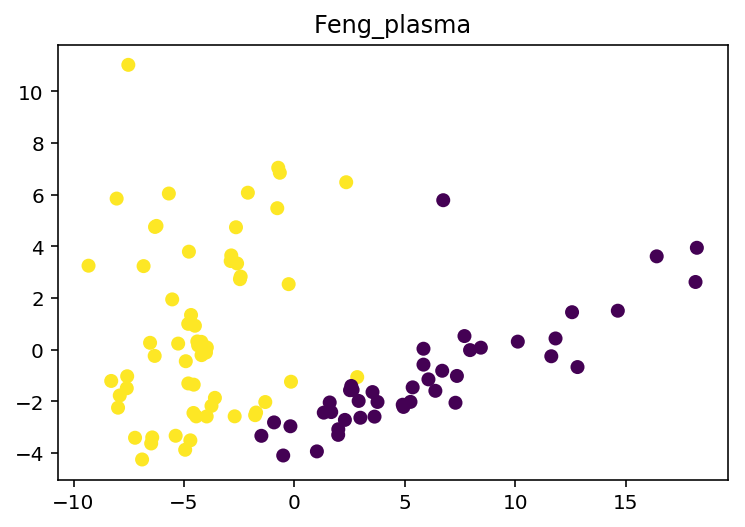

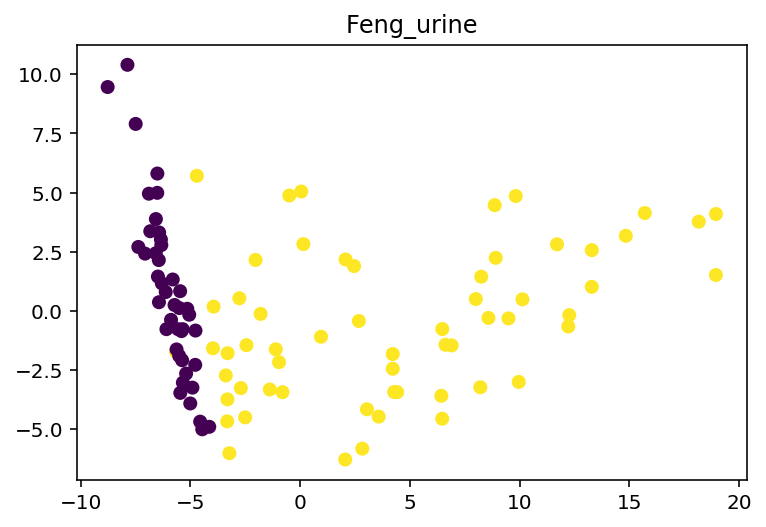

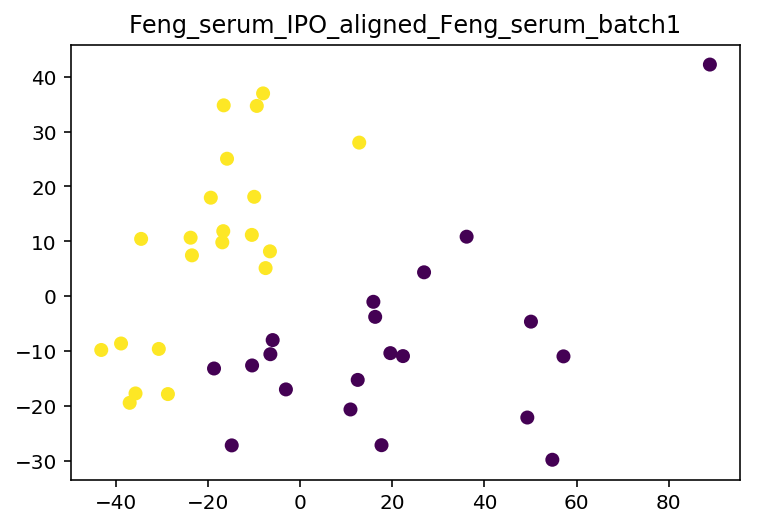

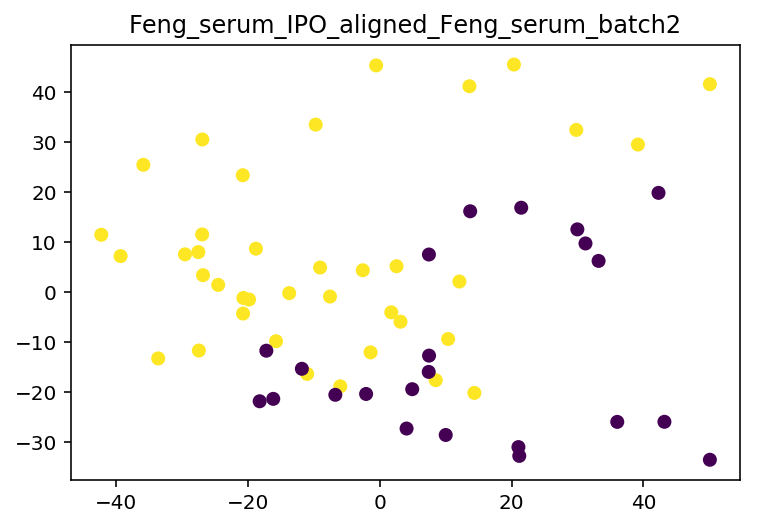

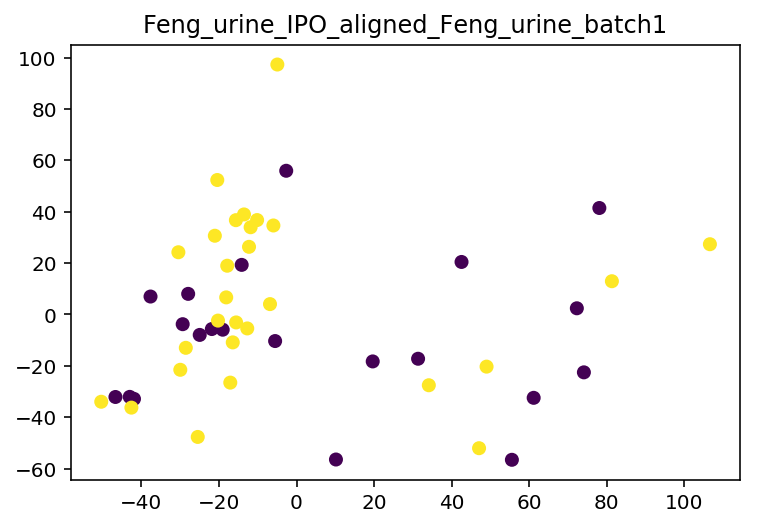

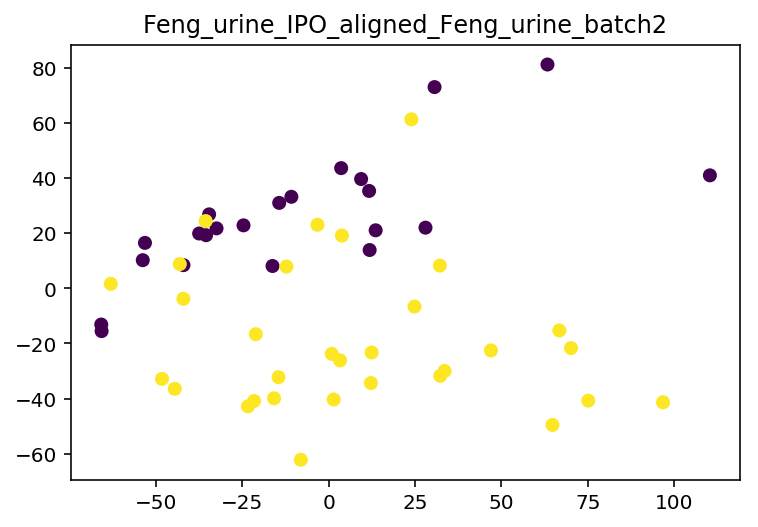

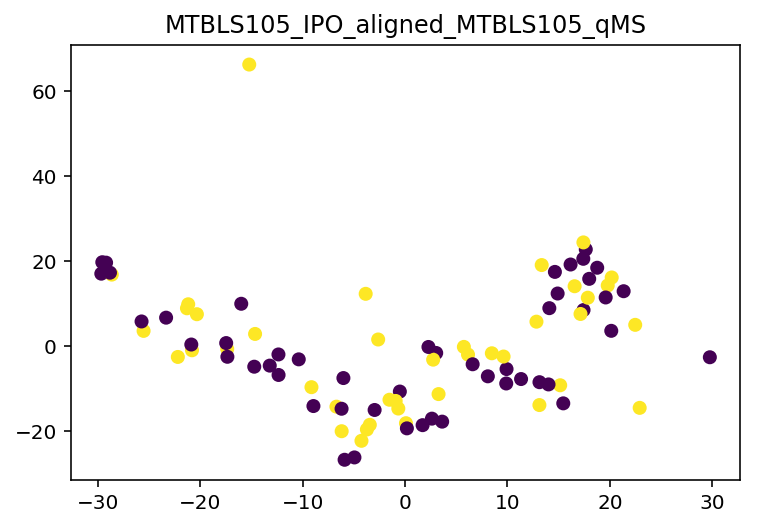

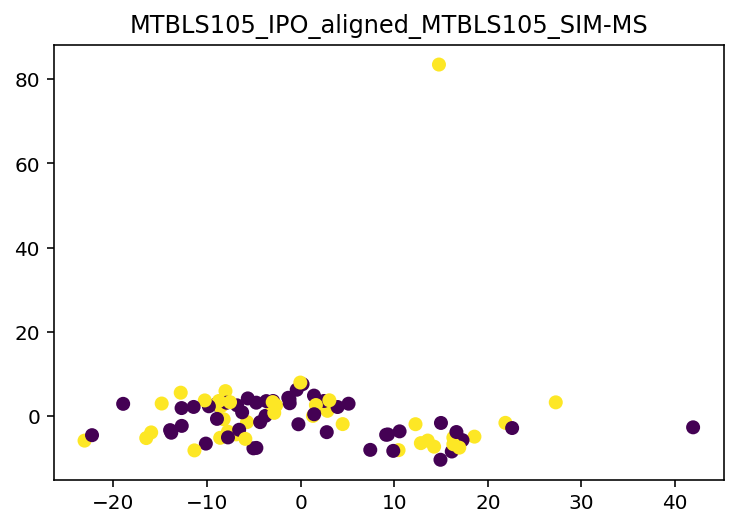

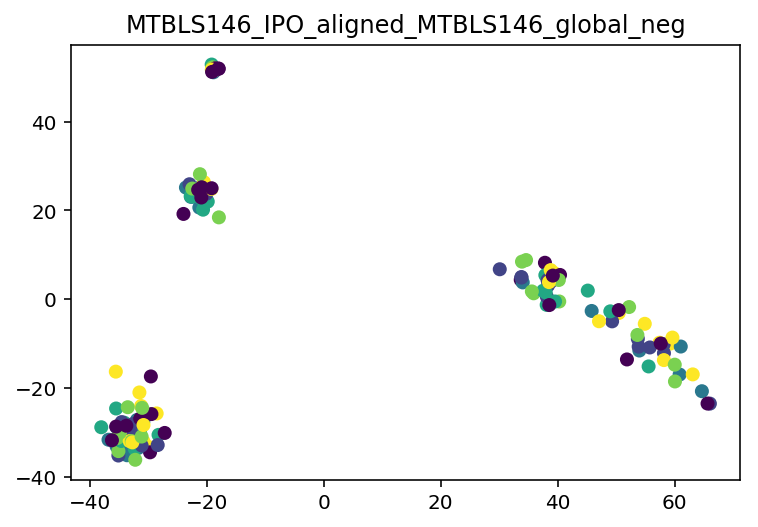

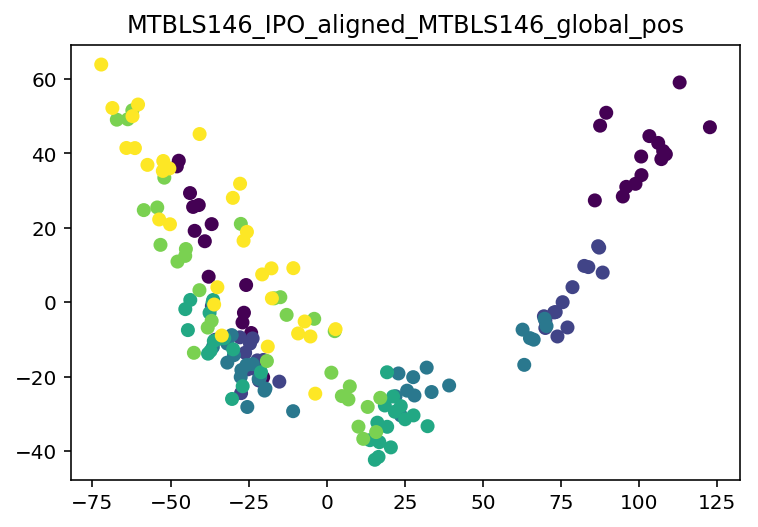

MTBLS148 IPO_aligned_MTBLS148_neg (<class 'ValueError'>, ValueError('c of shape (54,) not acceptable as a color sequence for x with size 27, y with size 27',), <traceback object at 0x7f8c3284bcc8>)
MTBLS148 IPO_aligned_MTBLS148_pos (<class 'ValueError'>, ValueError('c of shape (54,) not acceptable as a color sequence for x with size 27, y with size 27',), <traceback object at 0x7f8c3284b708>)


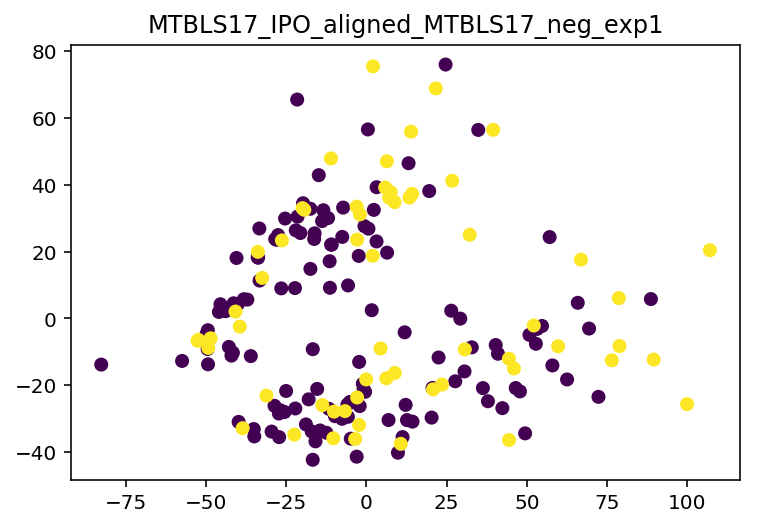

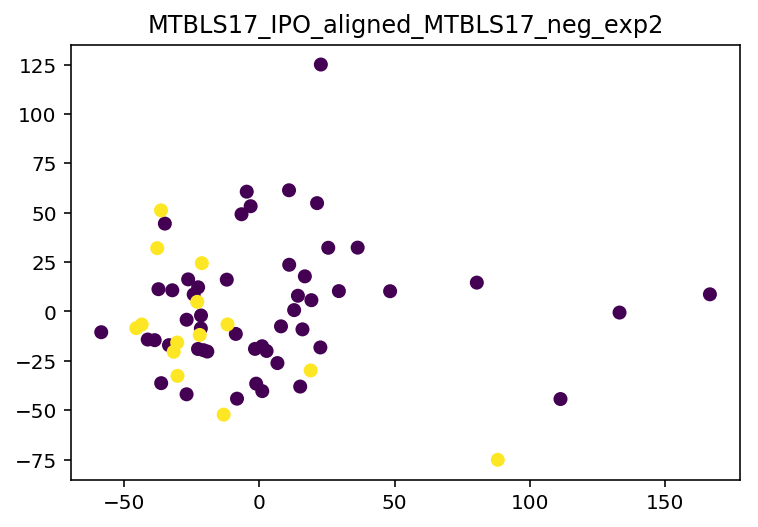

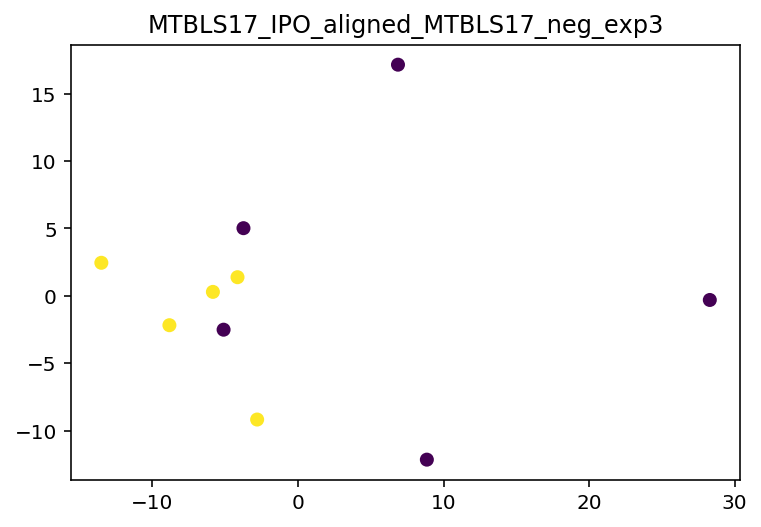

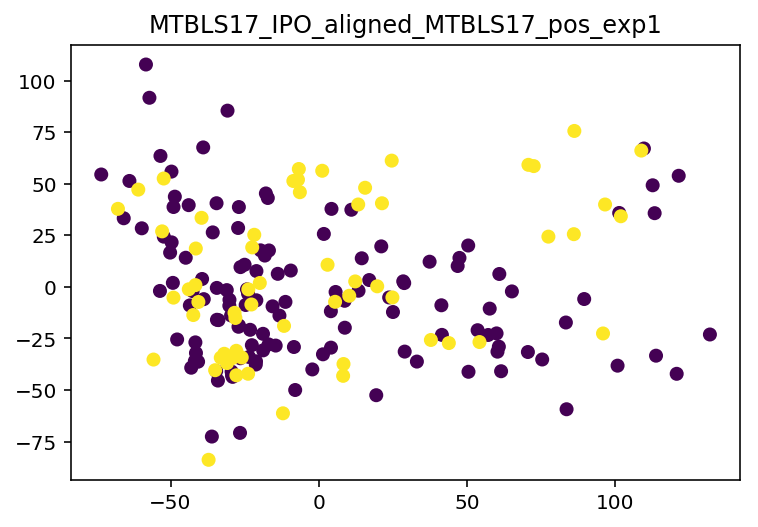

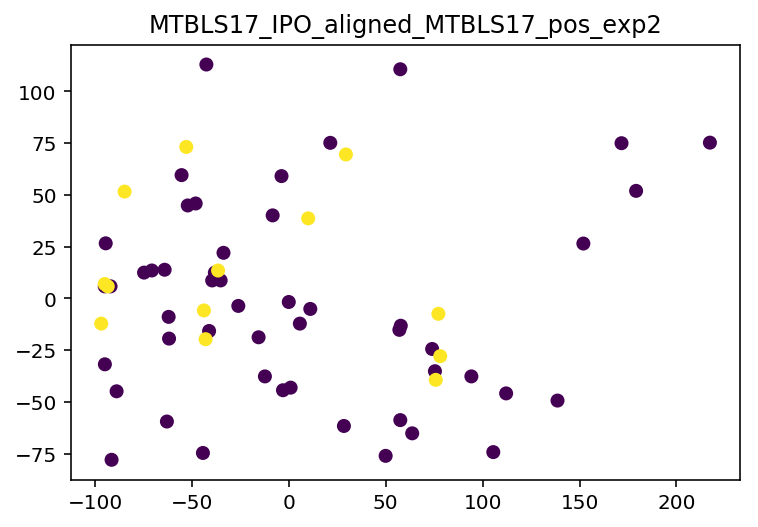

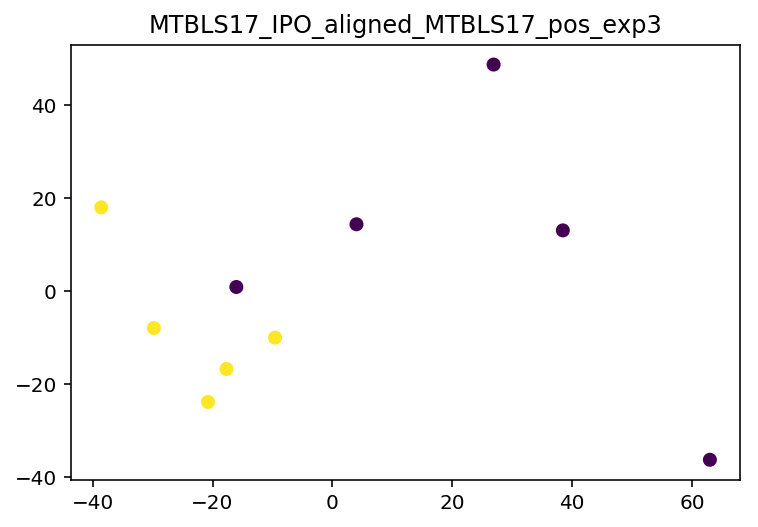

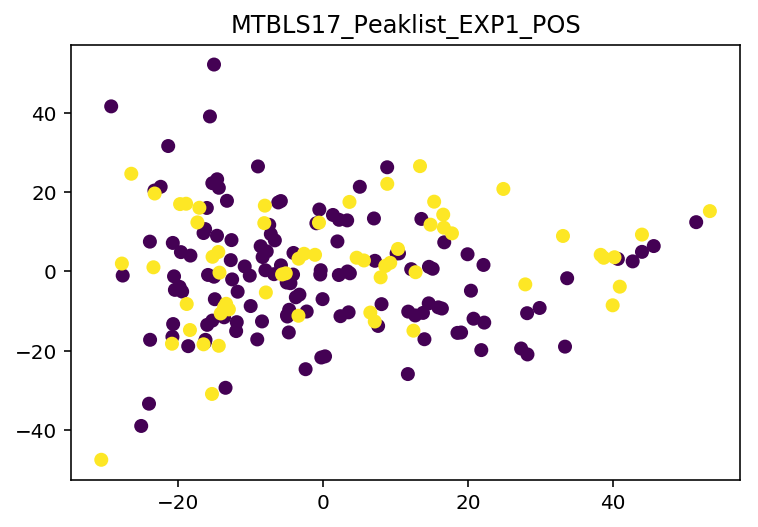

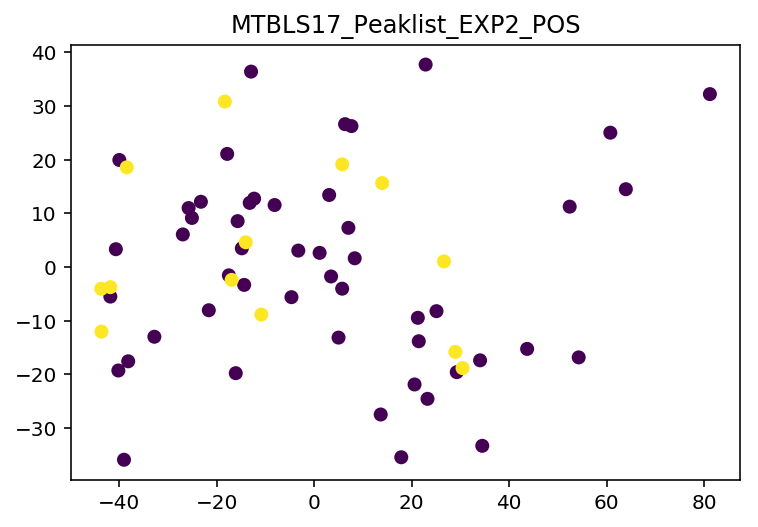

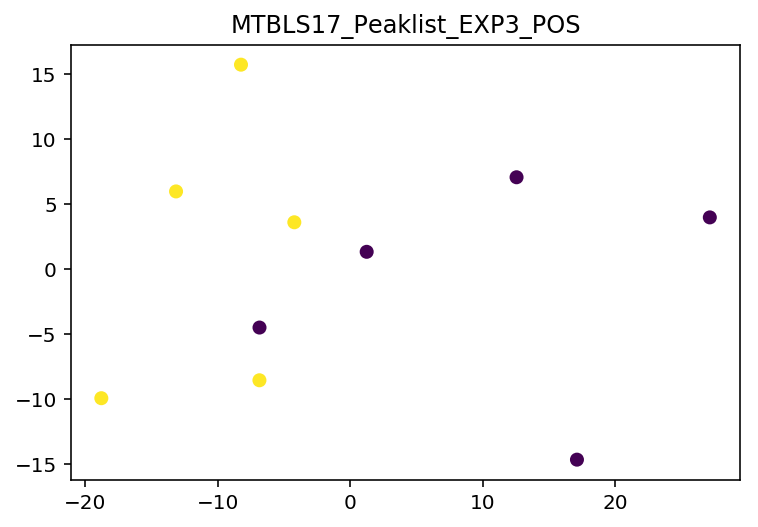

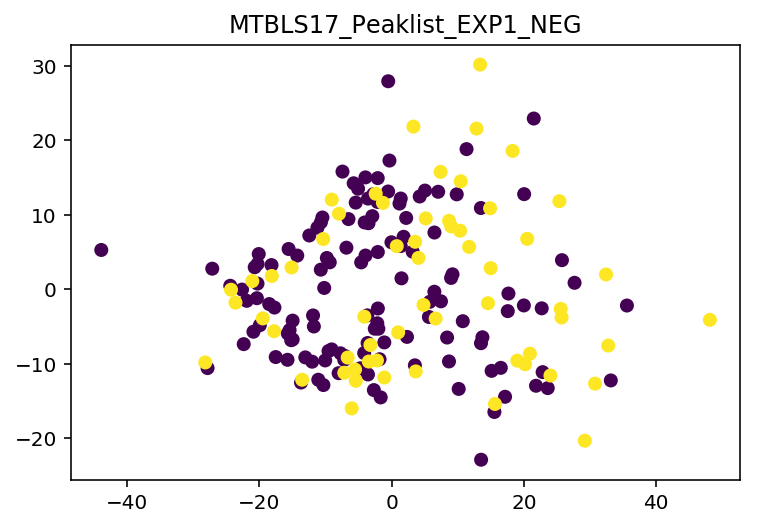

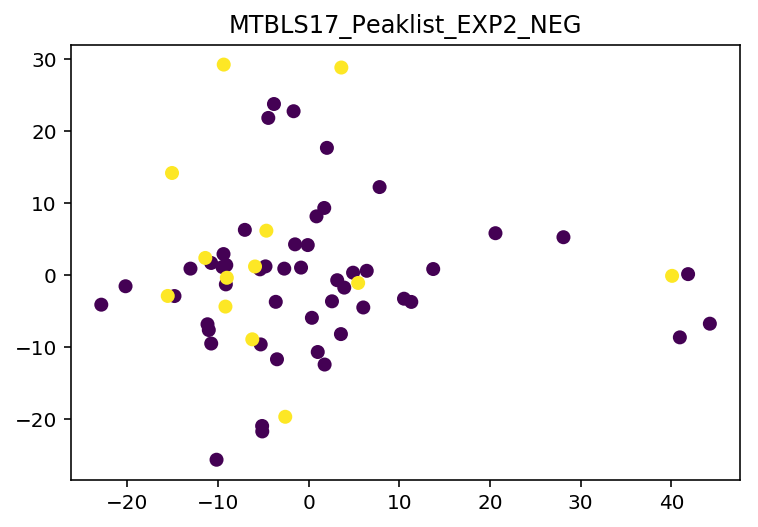

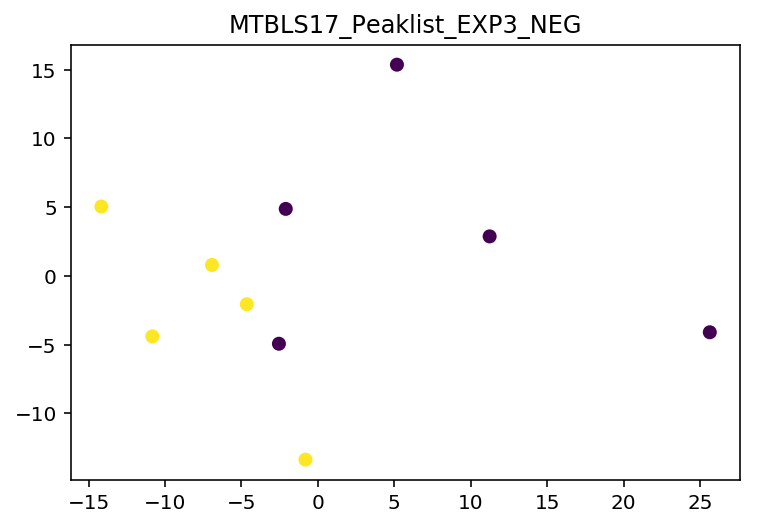

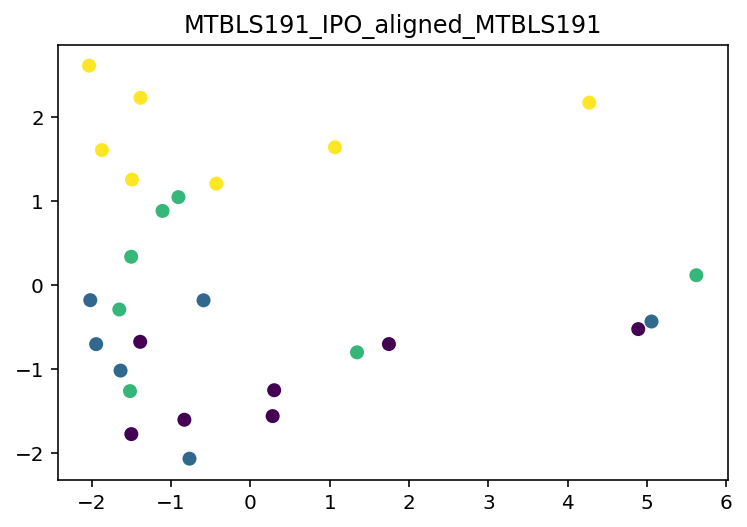

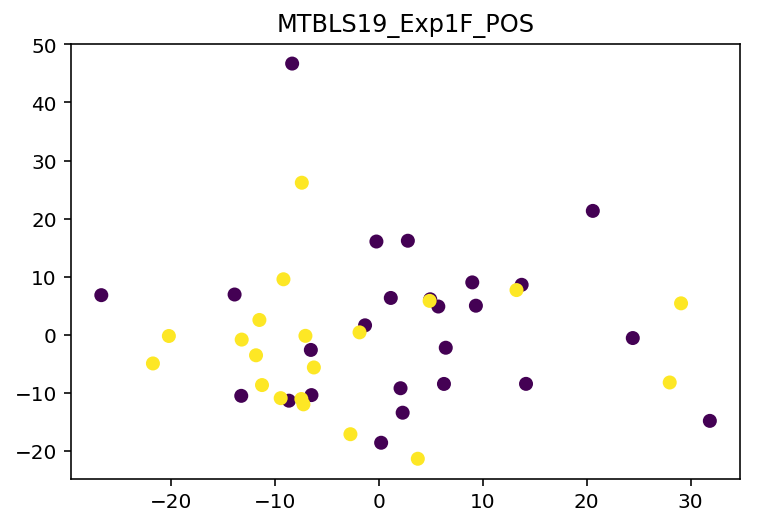

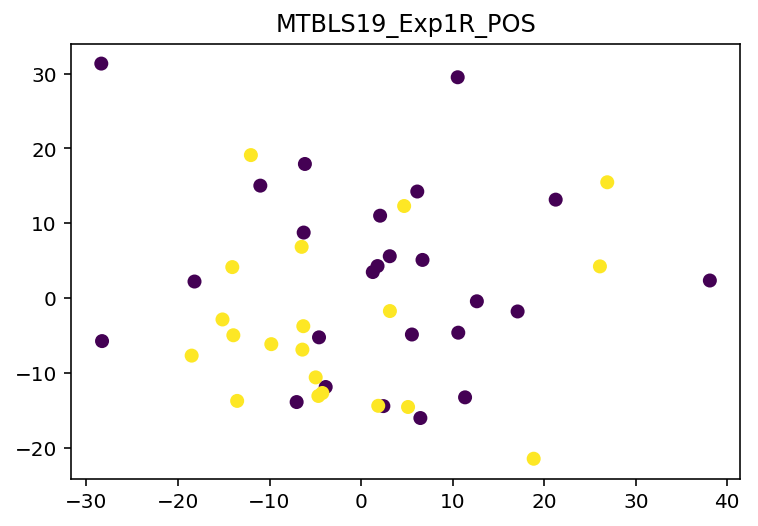

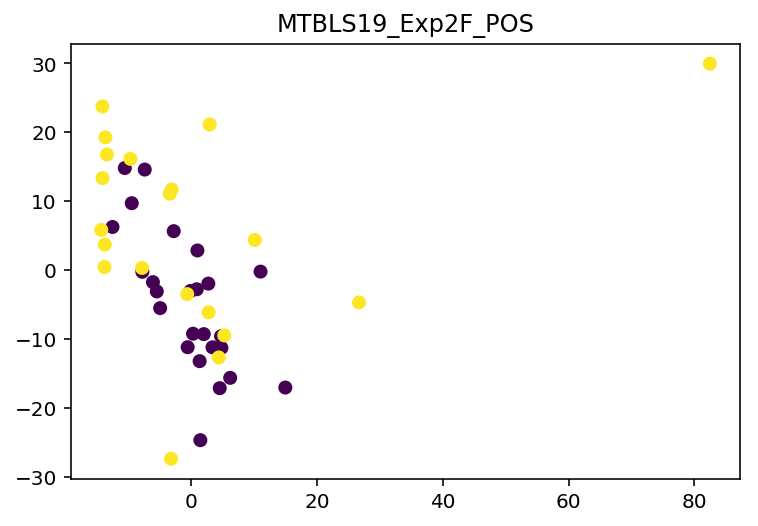

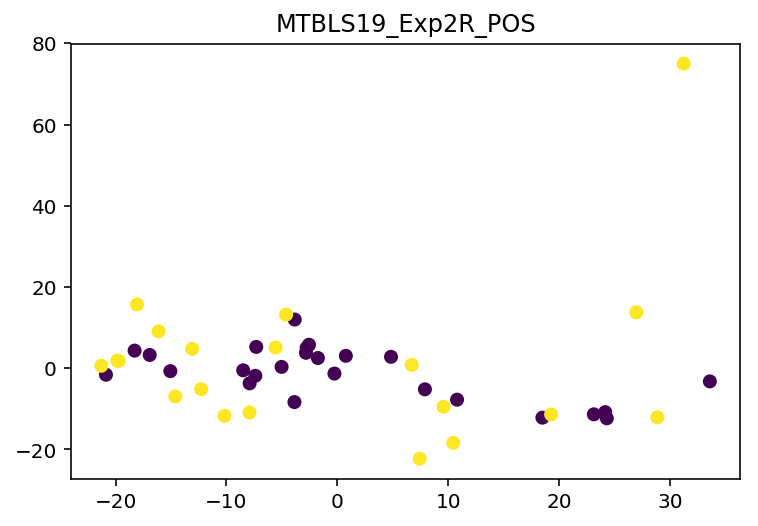

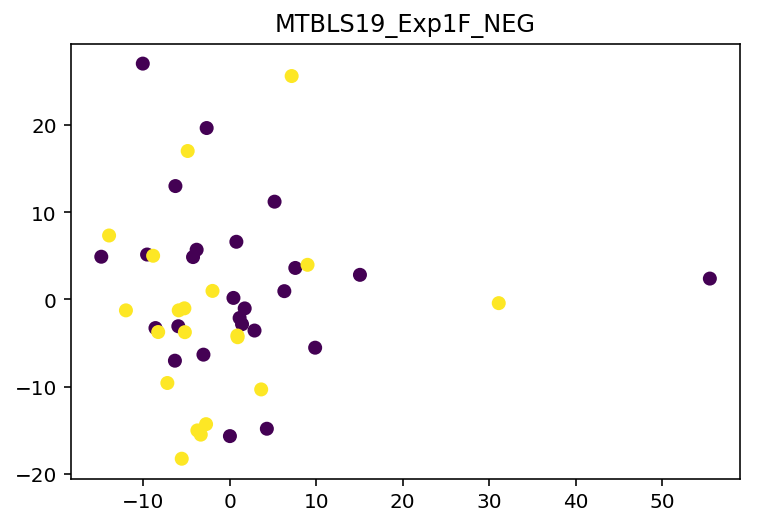

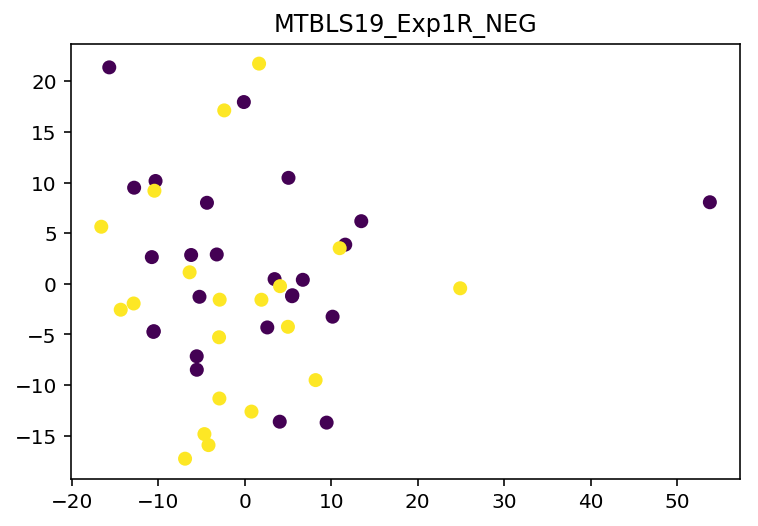

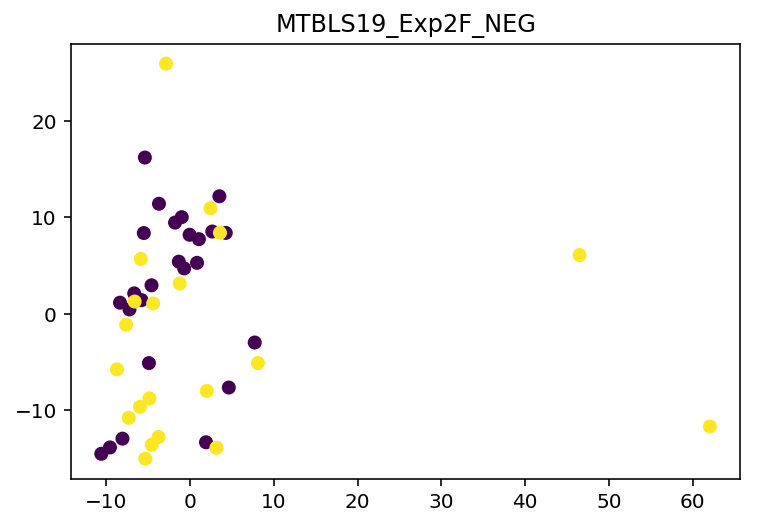

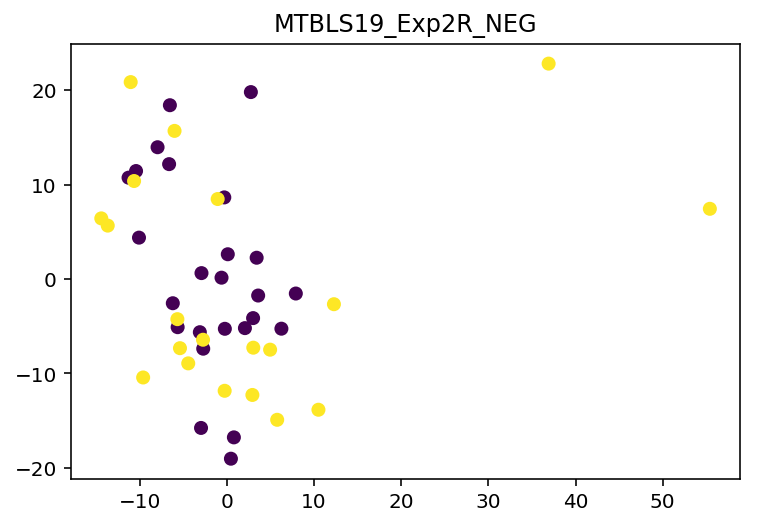

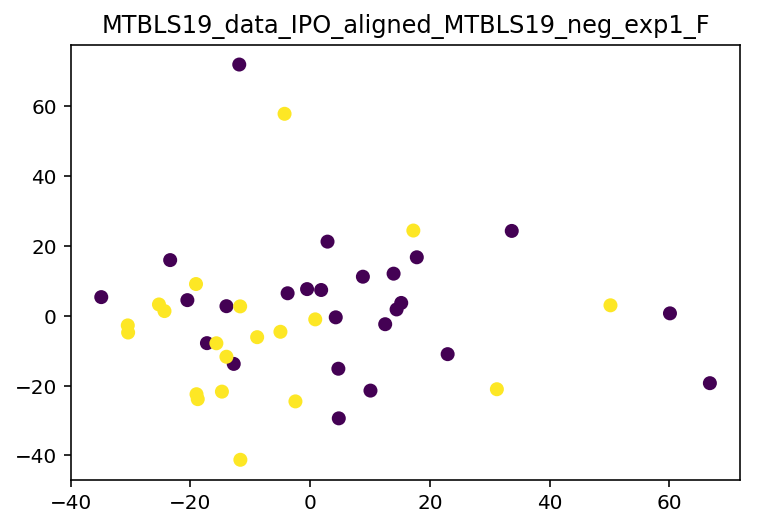

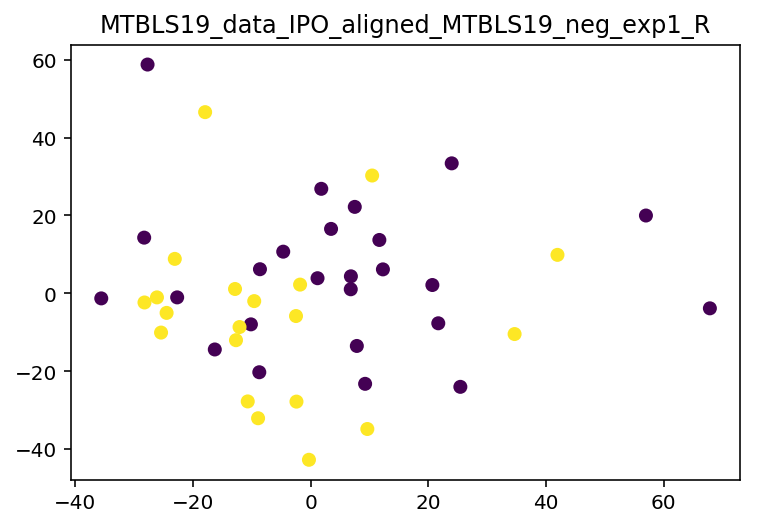

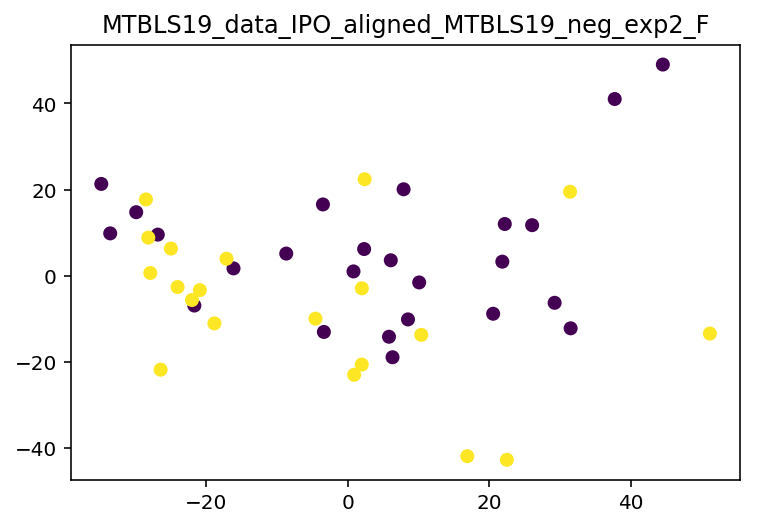

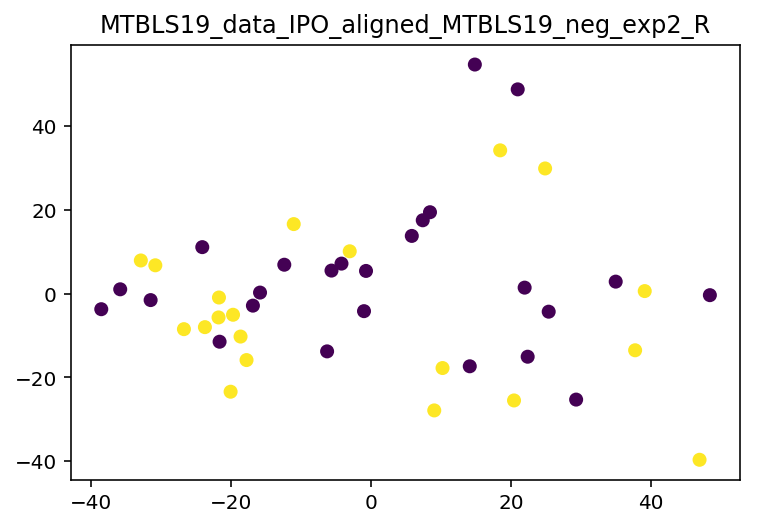

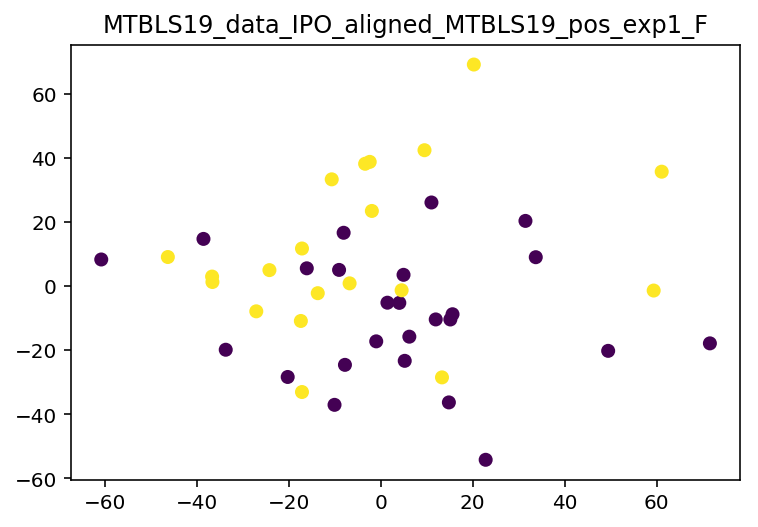

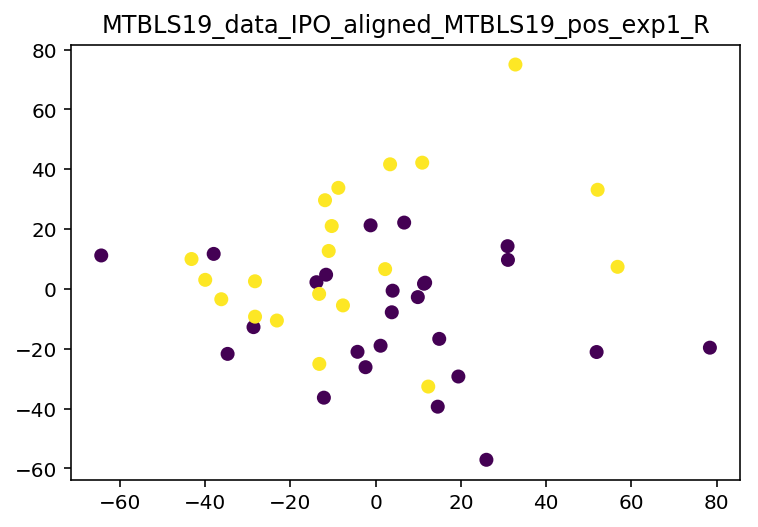

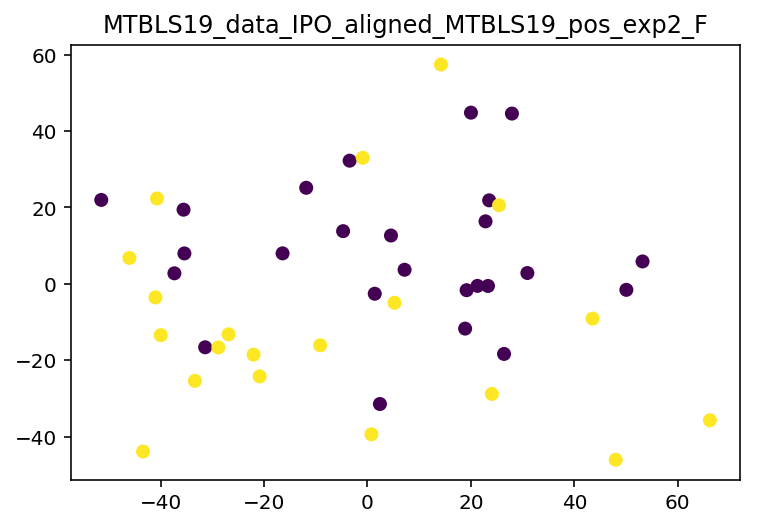

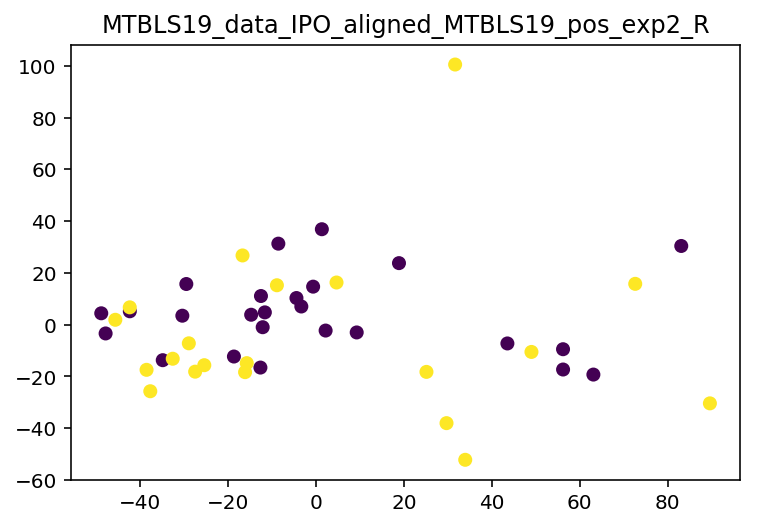

MTBLS200 IPO_aligned_MTBLS200_dilute (<class 'ValueError'>, ValueError('c of shape (111,) not acceptable as a color sequence for x with size 37, y with size 37',), <traceback object at 0x7f8c2fbe0a88>)
MTBLS200 IPO_aligned_MTBLS200_not_dilute (<class 'ValueError'>, ValueError('c of shape (84,) not acceptable as a color sequence for x with size 28, y with size 28',), <traceback object at 0x7f8c2fbe0988>)
MTBLS20 IPO_aligned_MTBLS20_439020_neg (<class 'ValueError'>, ValueError('c of shape (1170,) not acceptable as a color sequence for x with size 26, y with size 26',), <traceback object at 0x7f8c2fbe0dc8>)
MTBLS20 IPO_aligned_MTBLS20_439020_pos (<class 'ValueError'>, ValueError('c of shape (1080,) not acceptable as a color sequence for x with size 24, y with size 24',), <traceback object at 0x7f8c2fbe0488>)


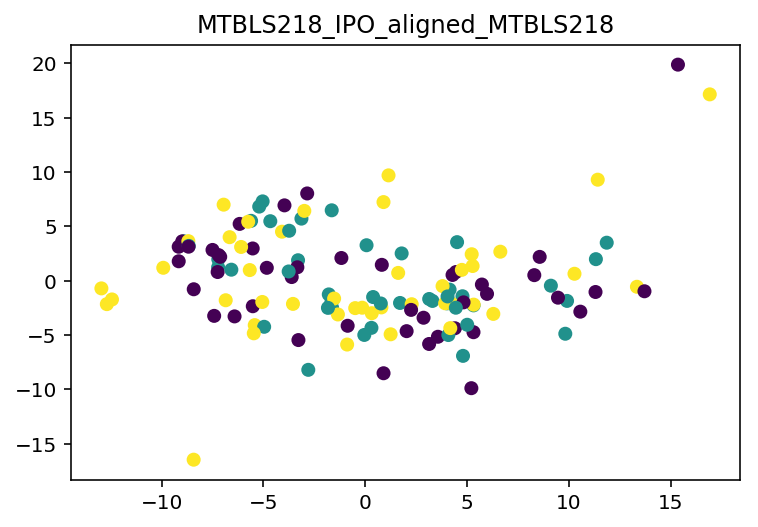

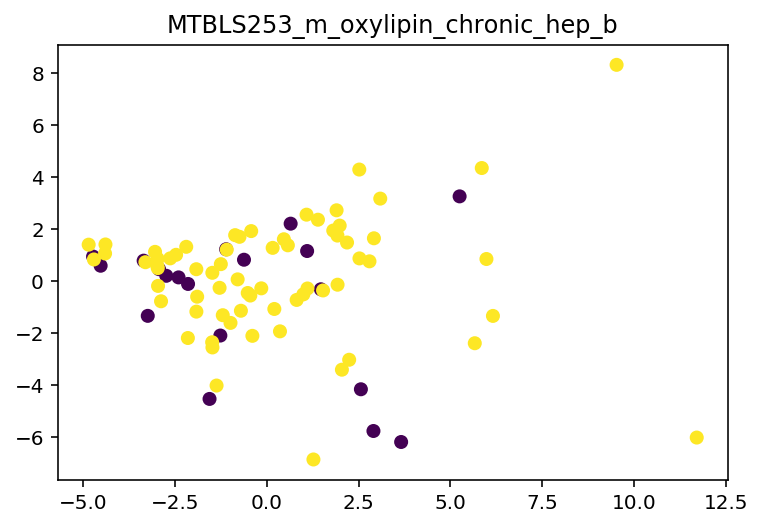

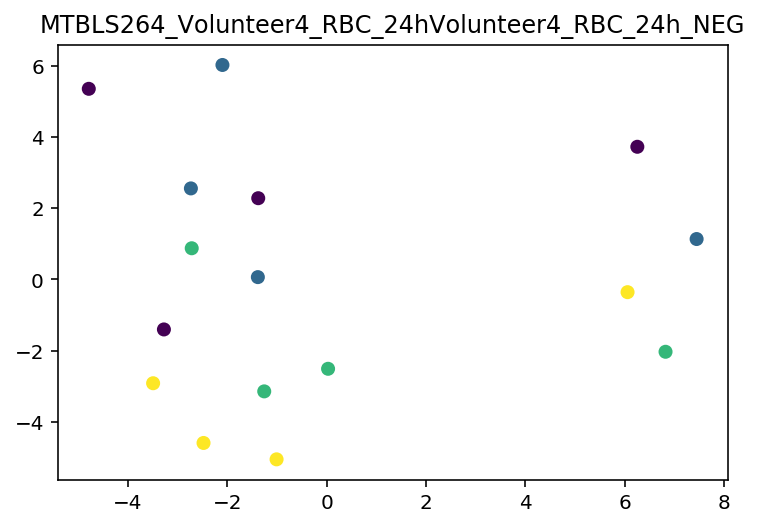

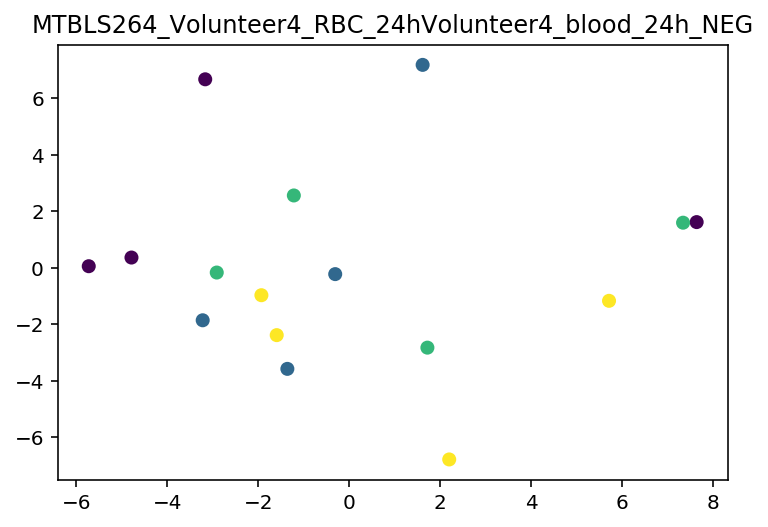

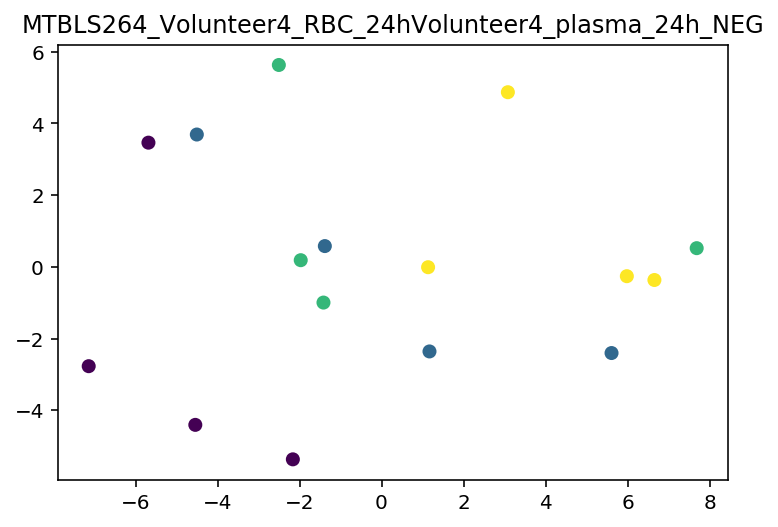

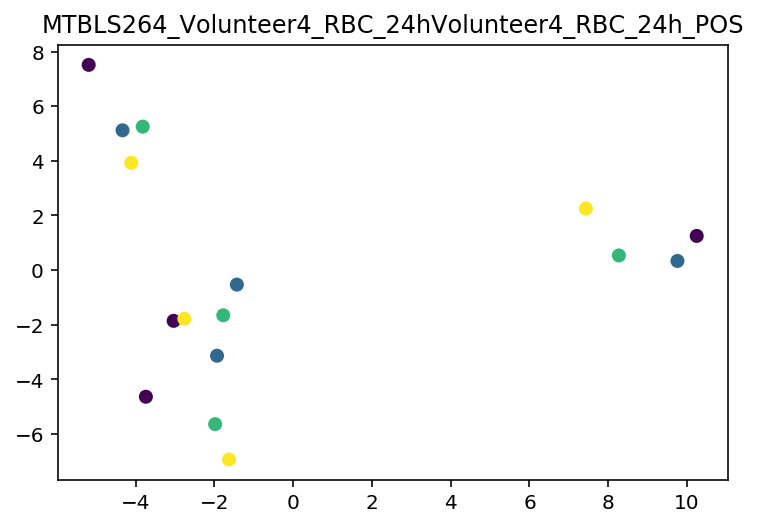

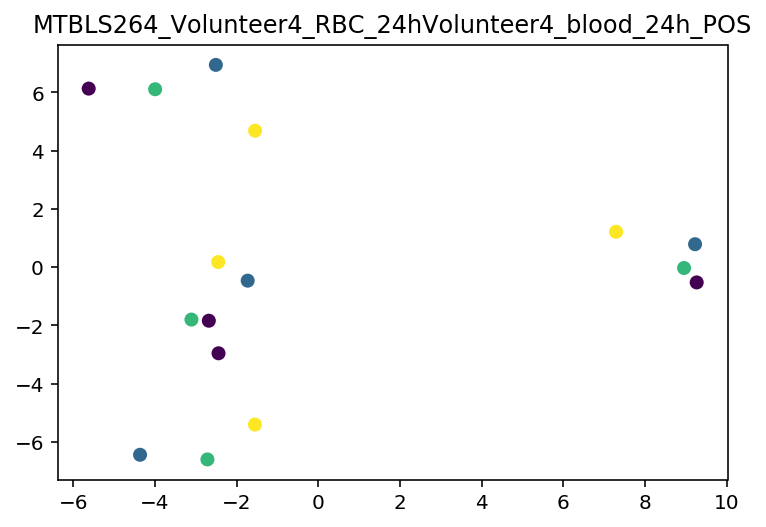

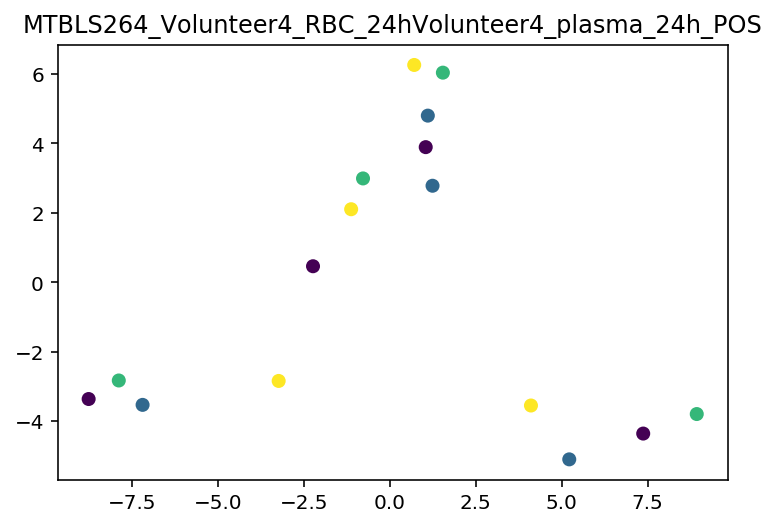

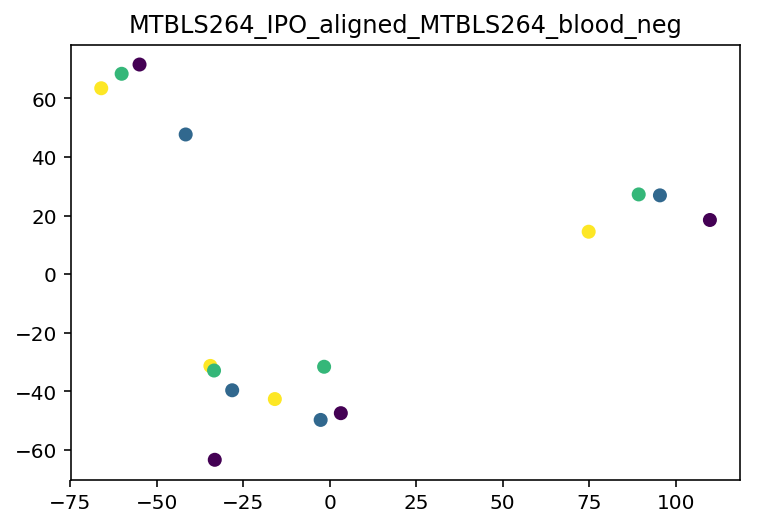

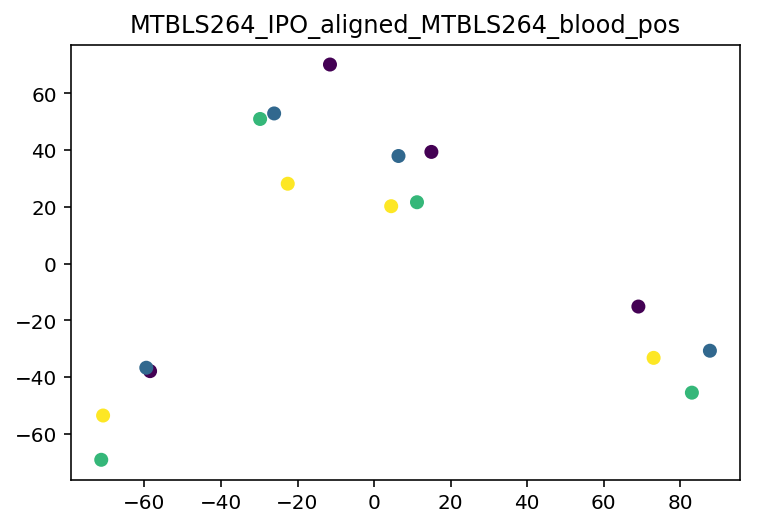

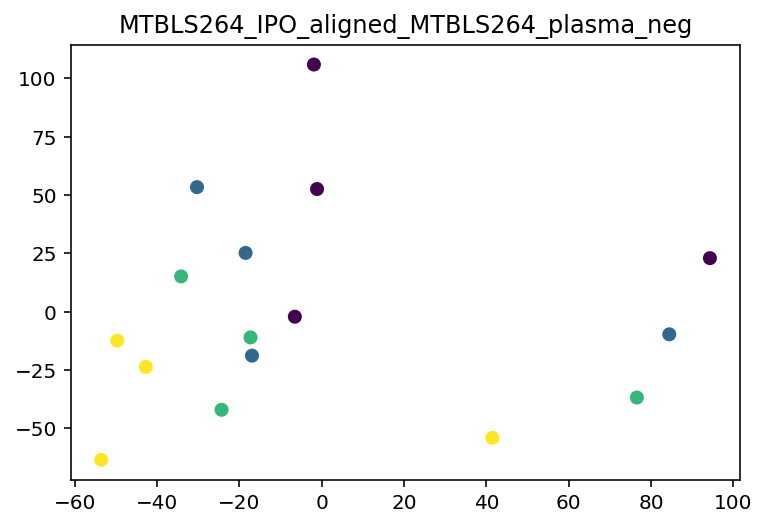

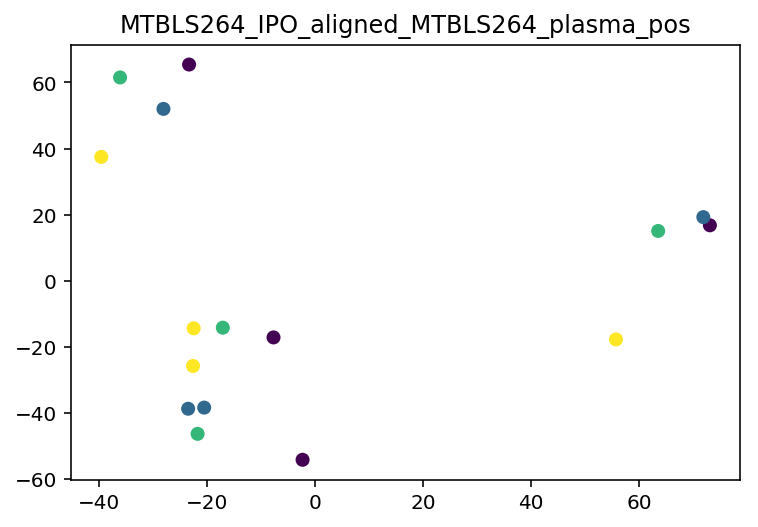

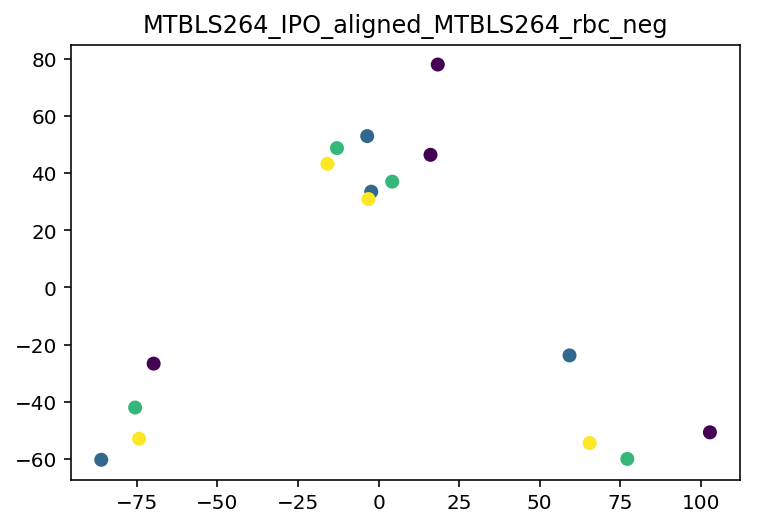

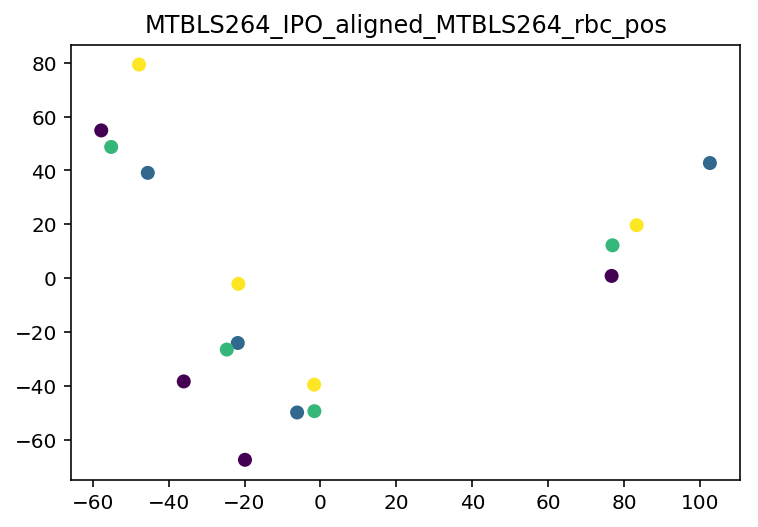

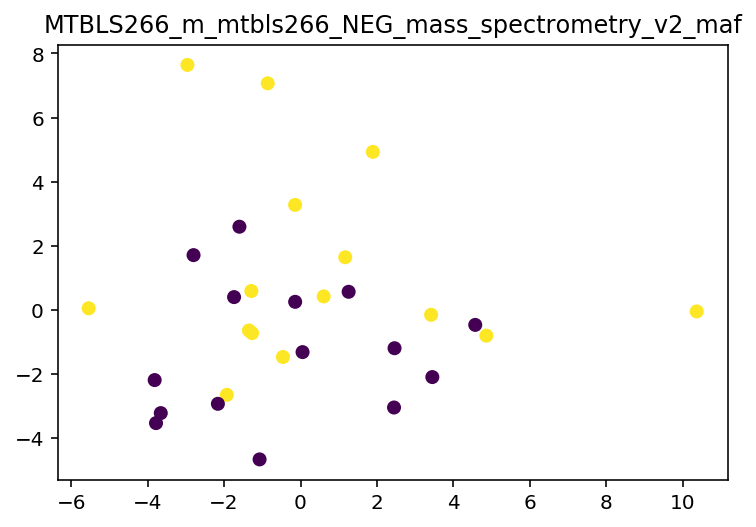

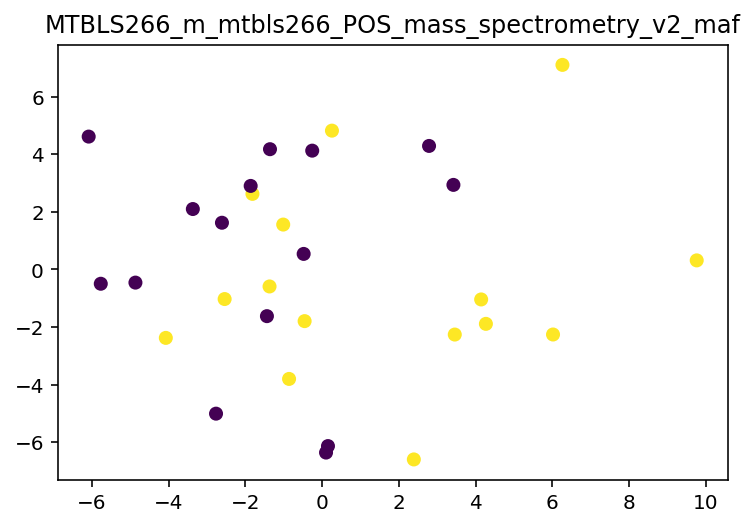

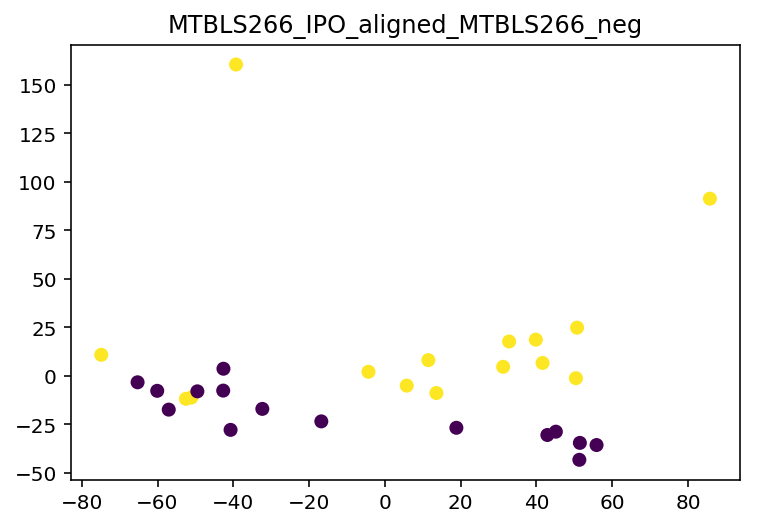

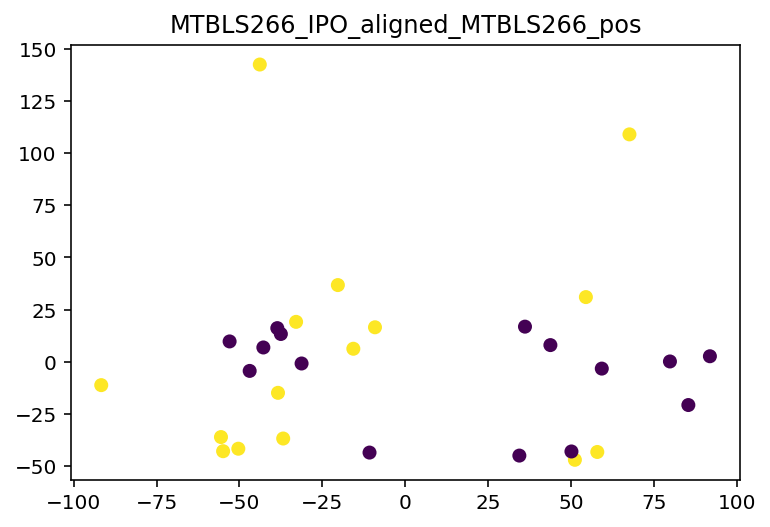

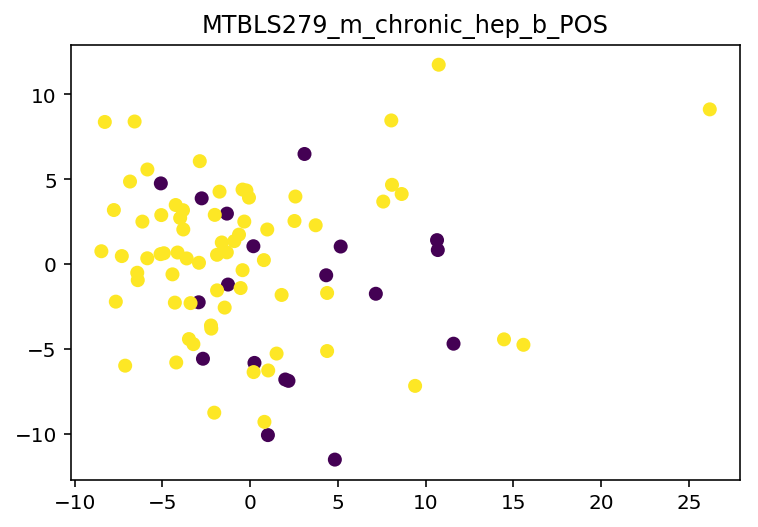

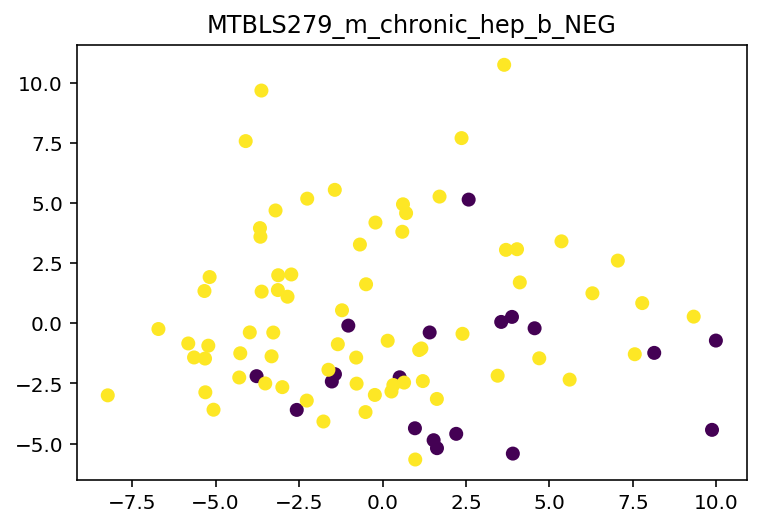

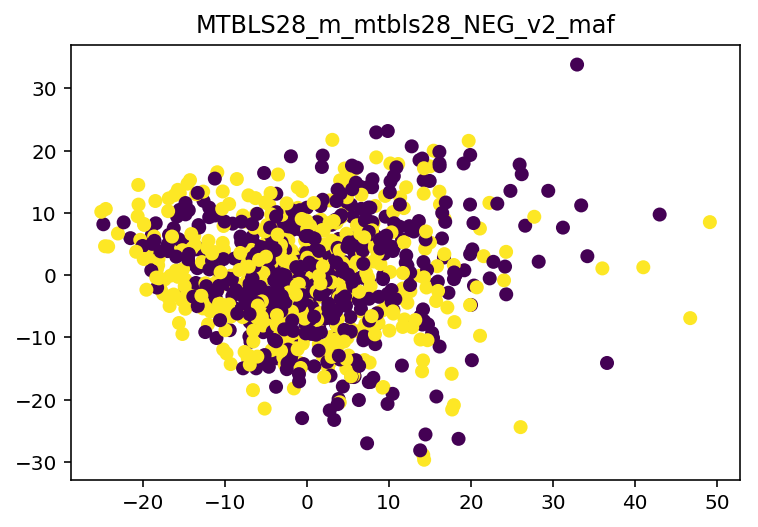

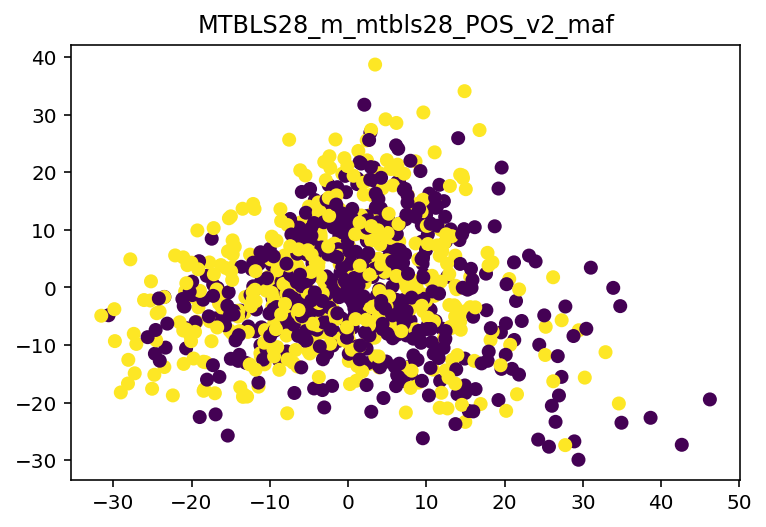

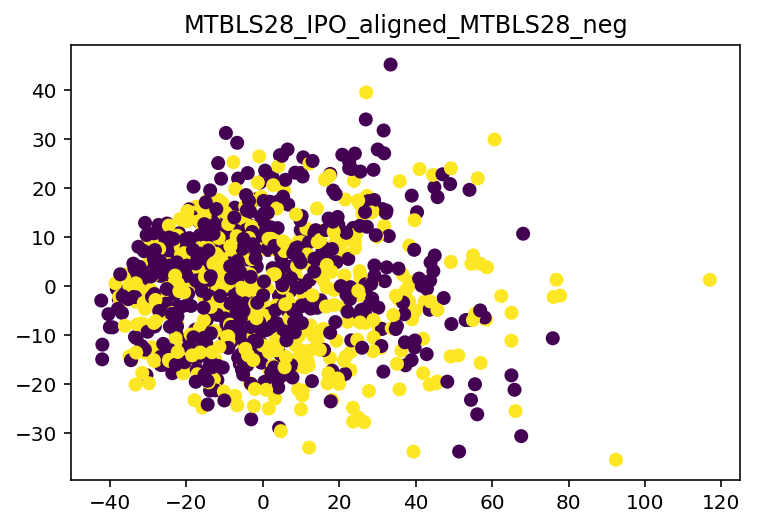

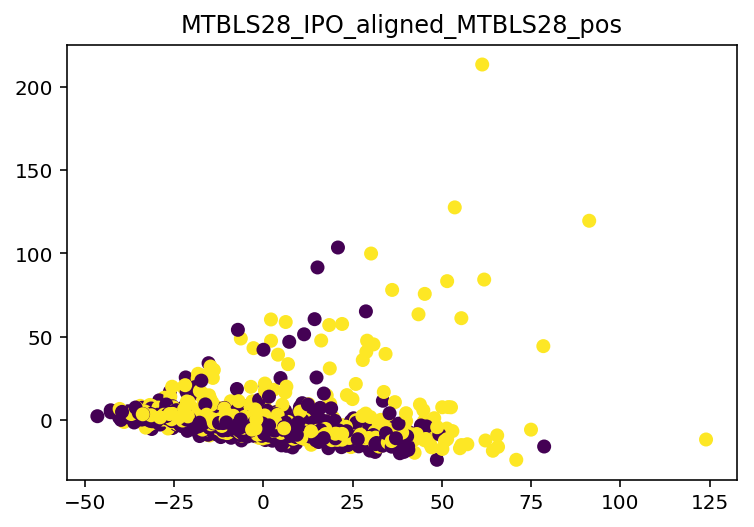

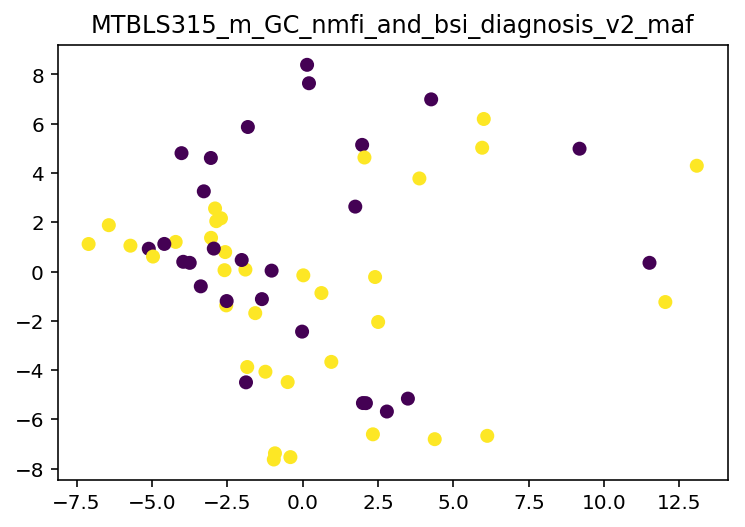

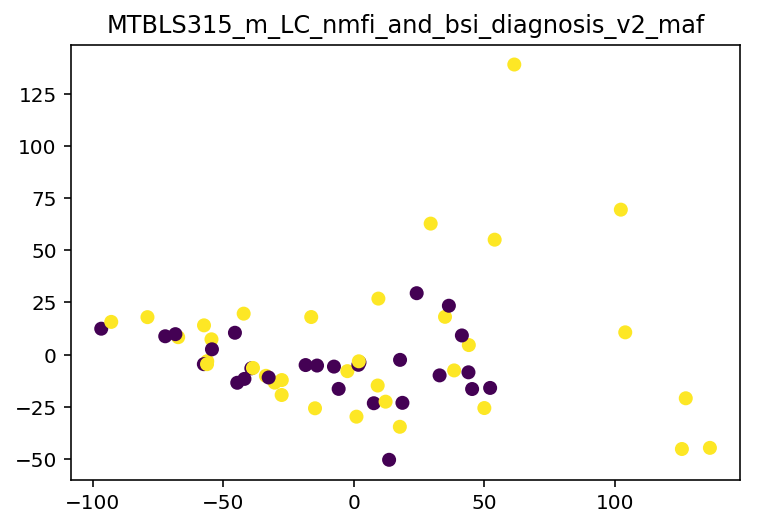

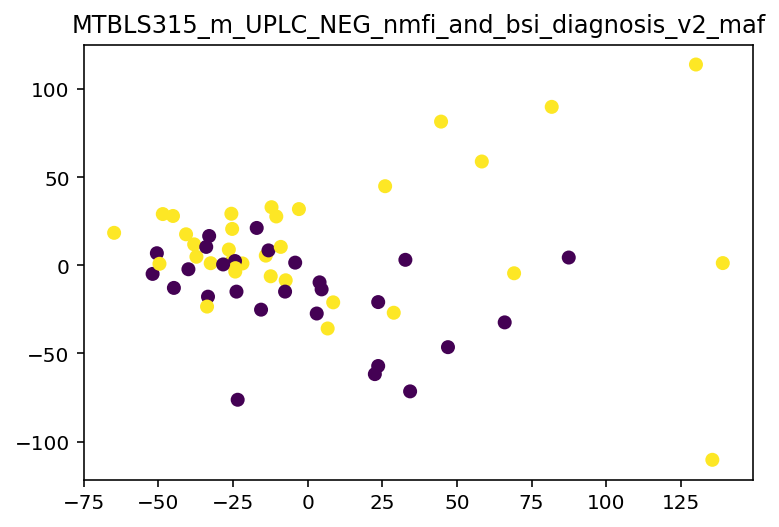

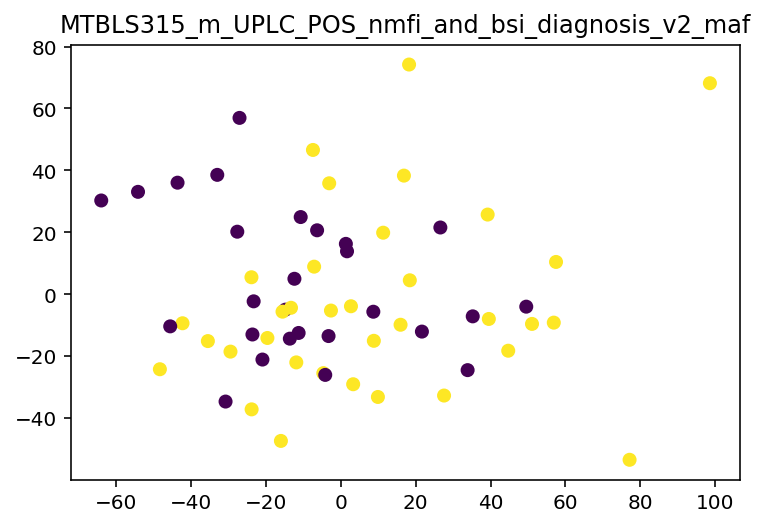

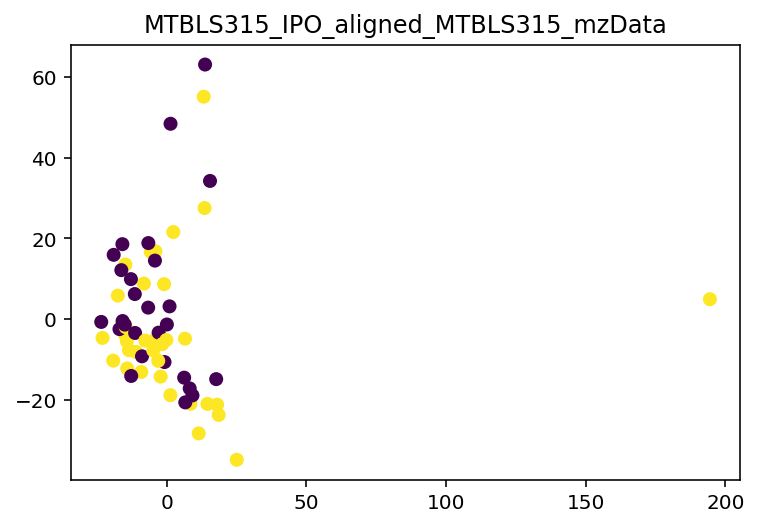

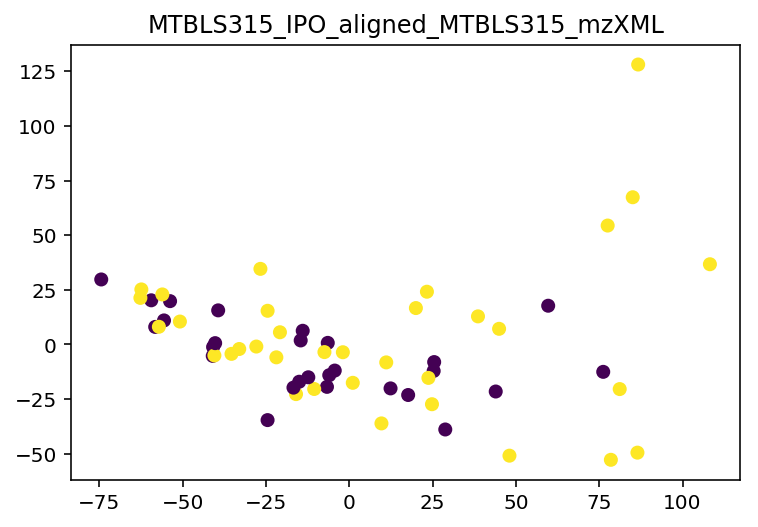

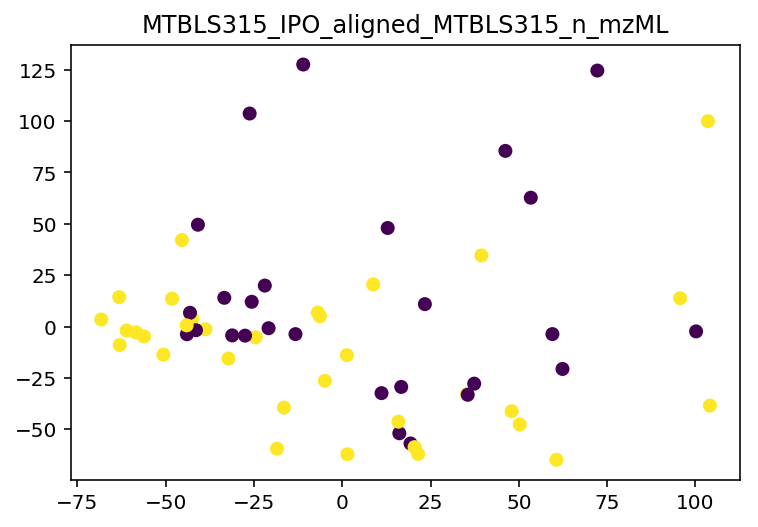

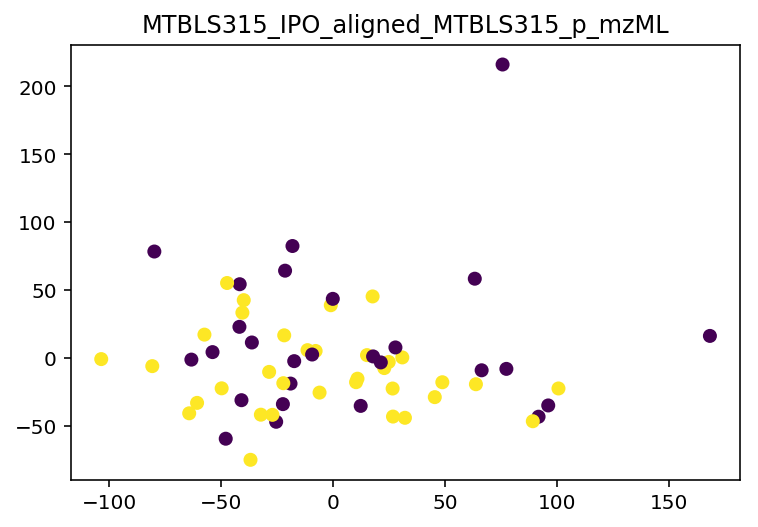

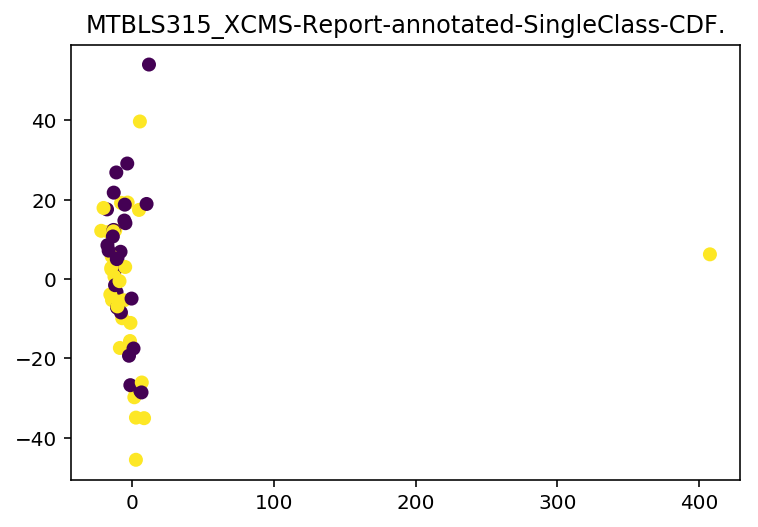

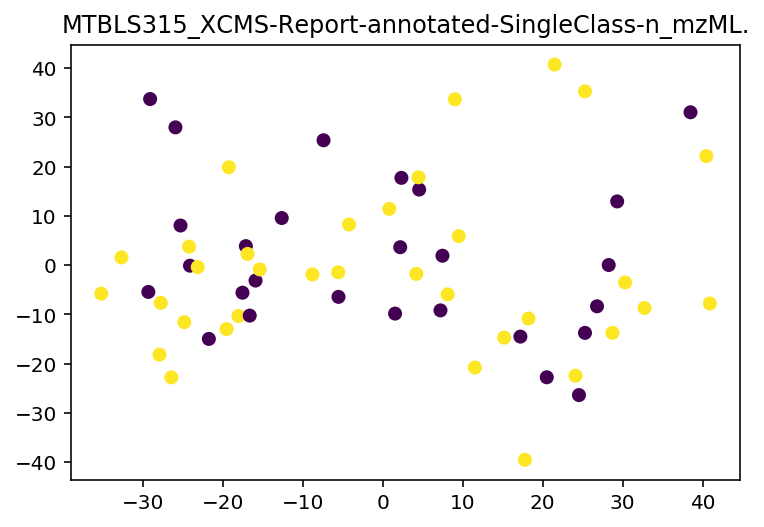

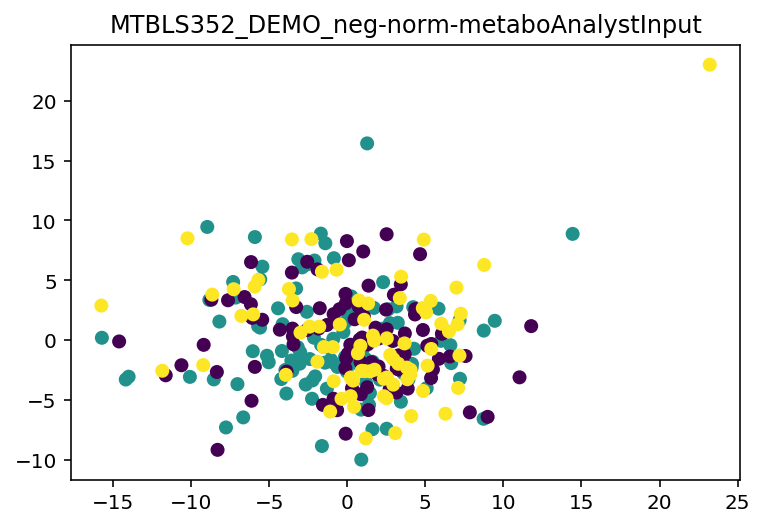

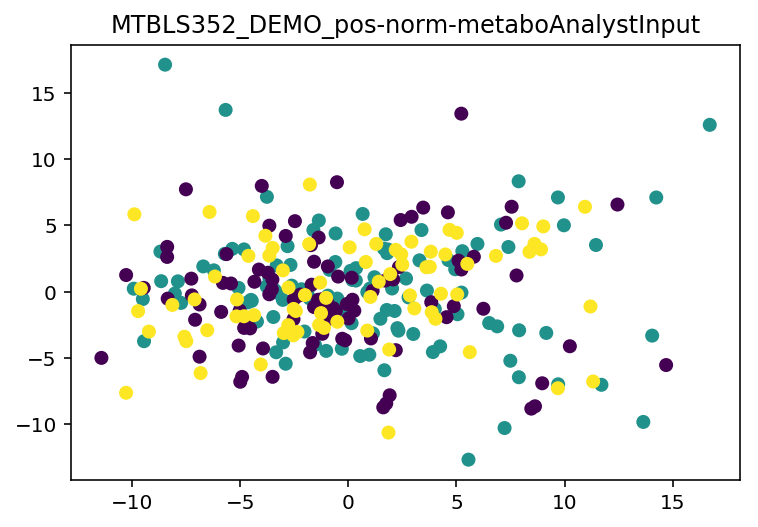

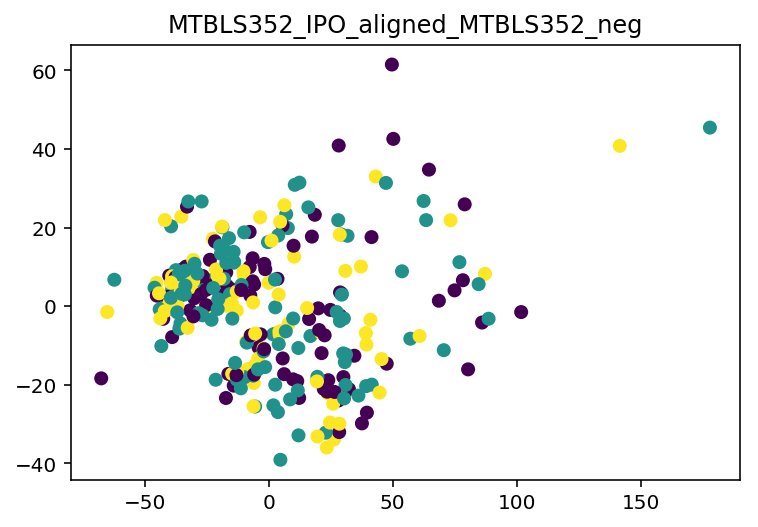

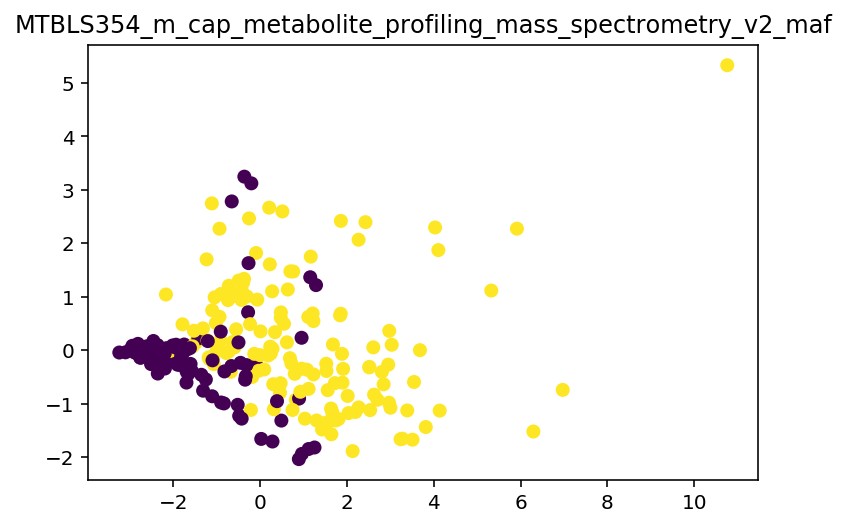

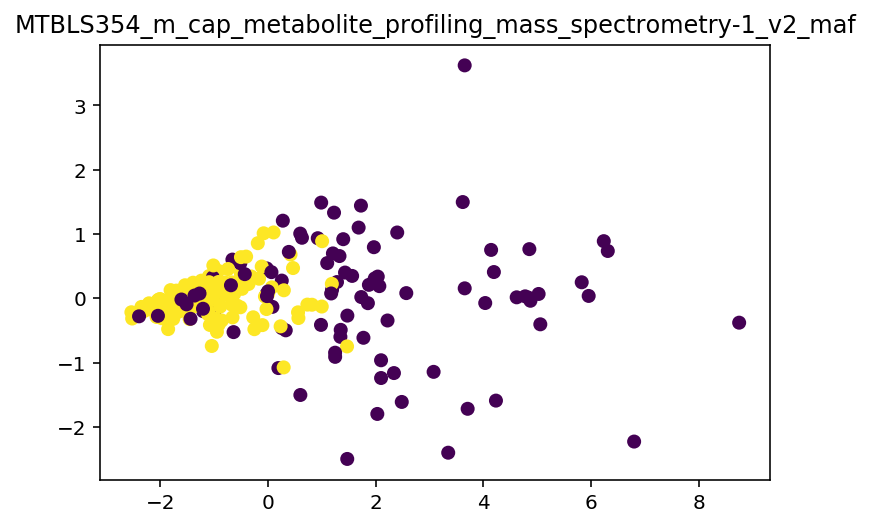

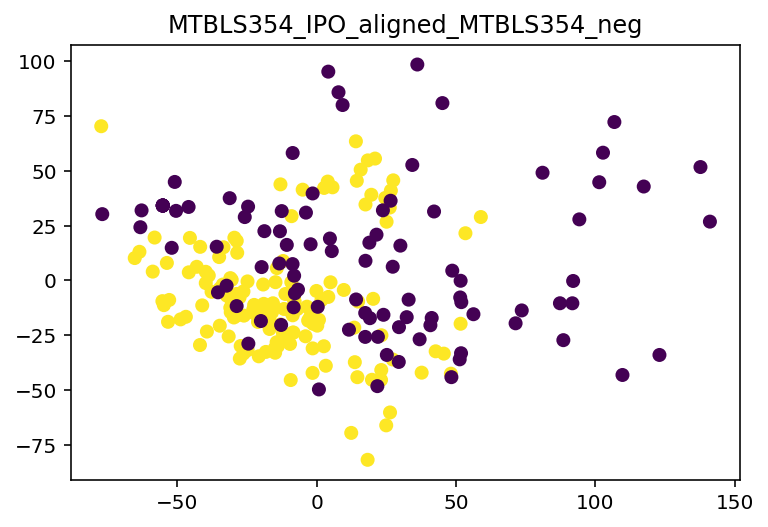

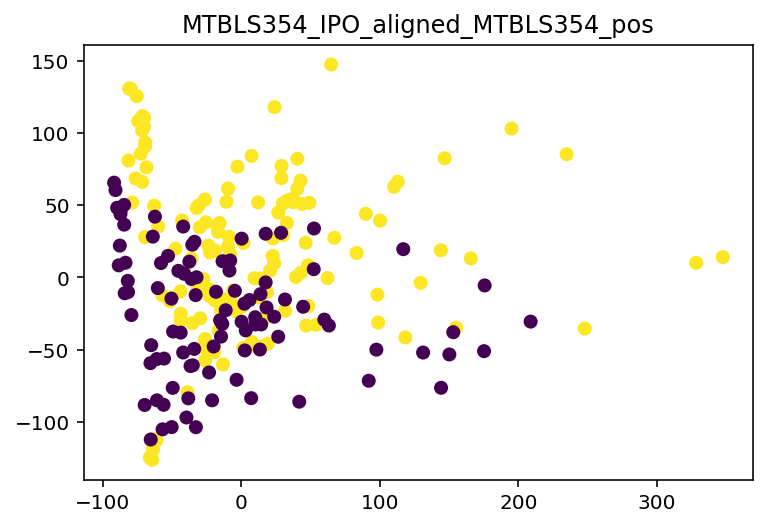

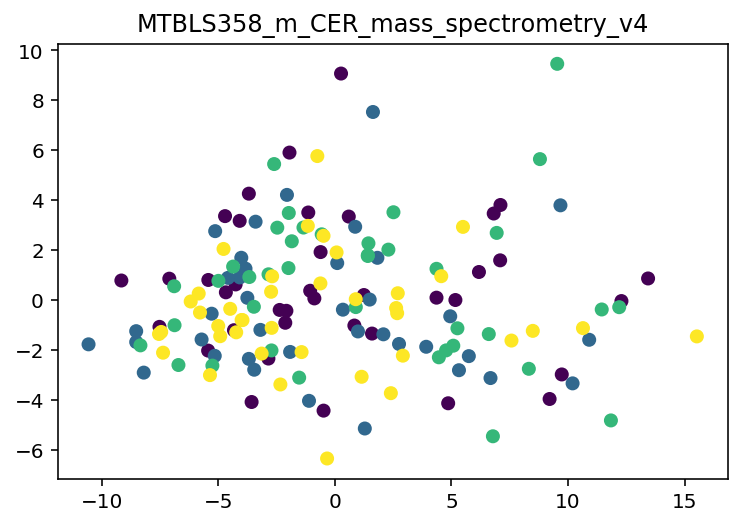

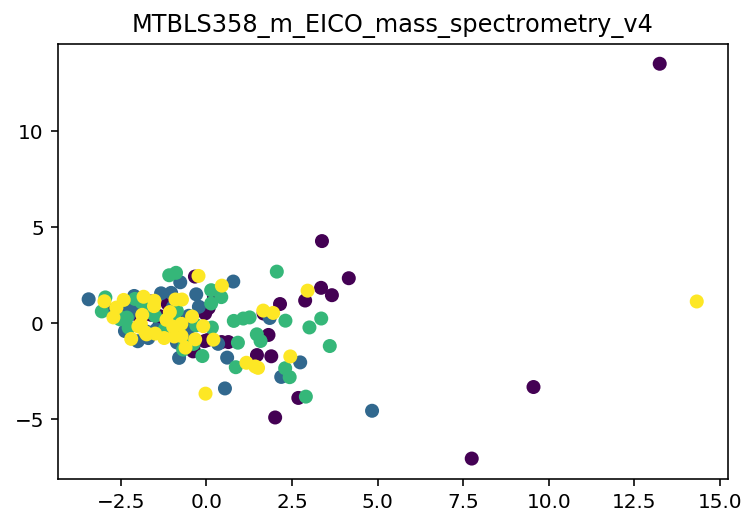

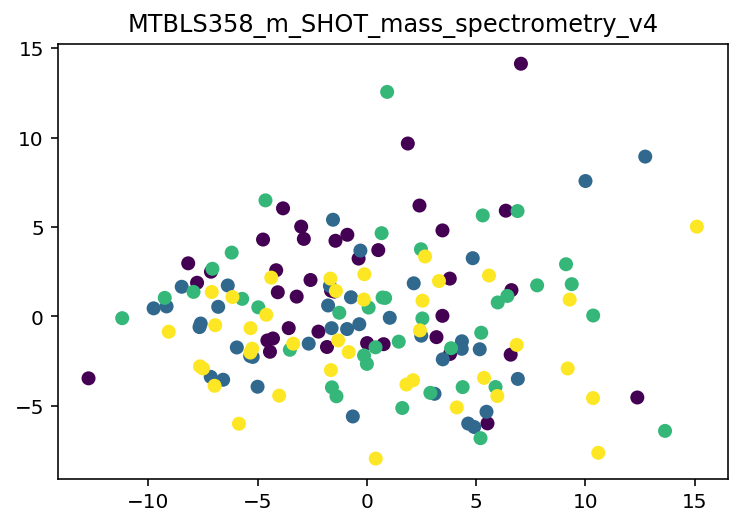

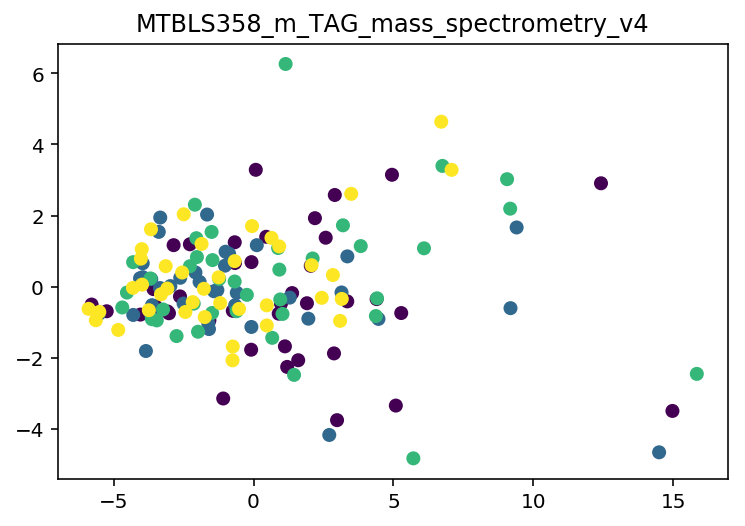

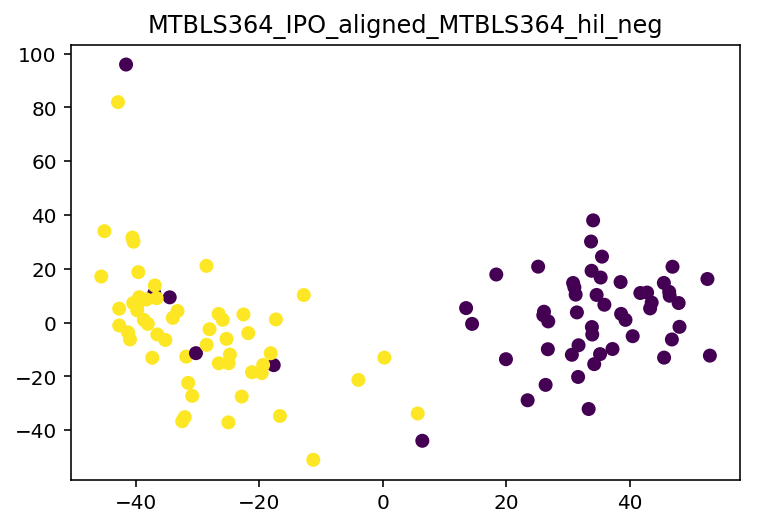

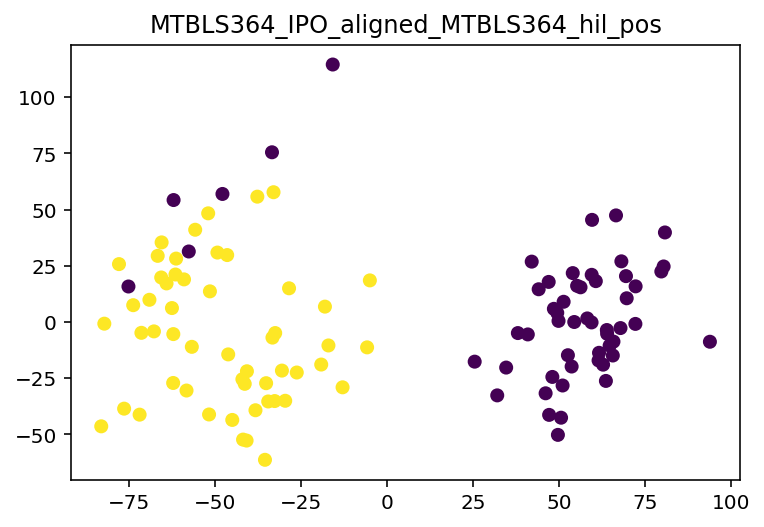

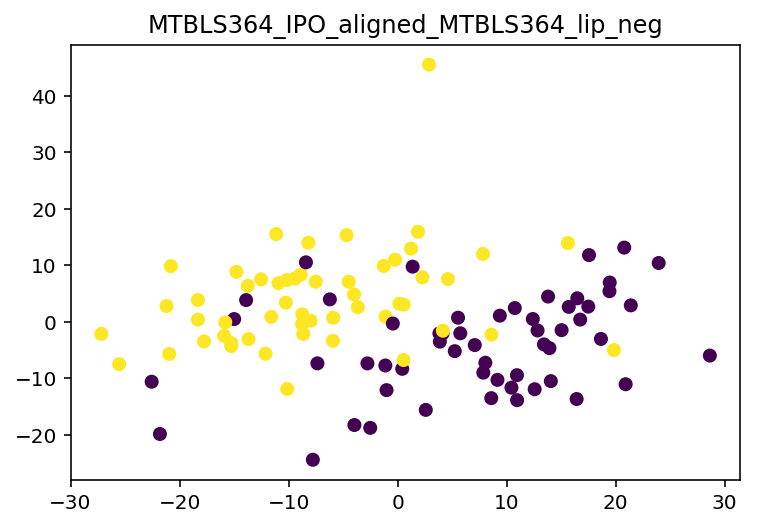

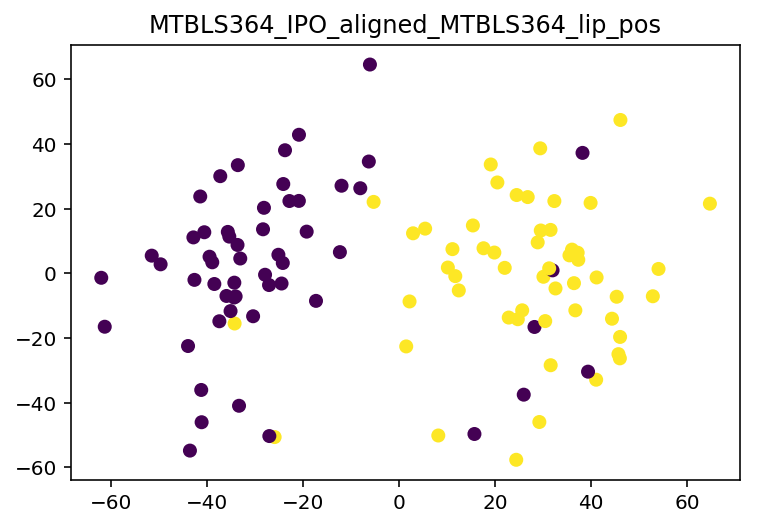

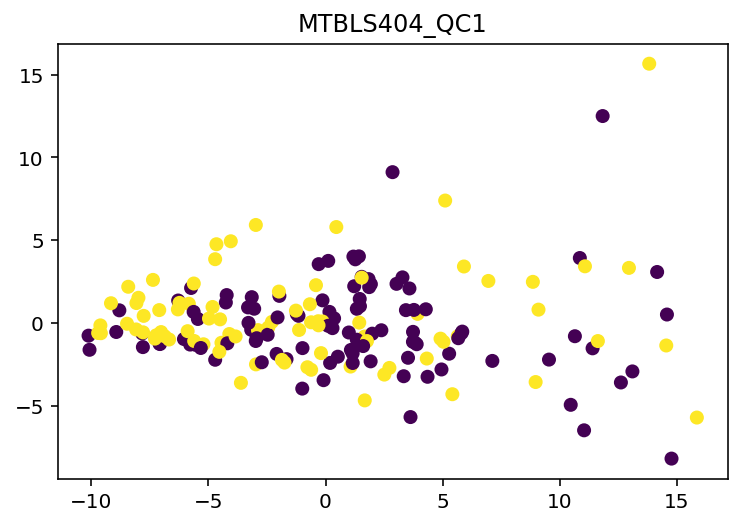

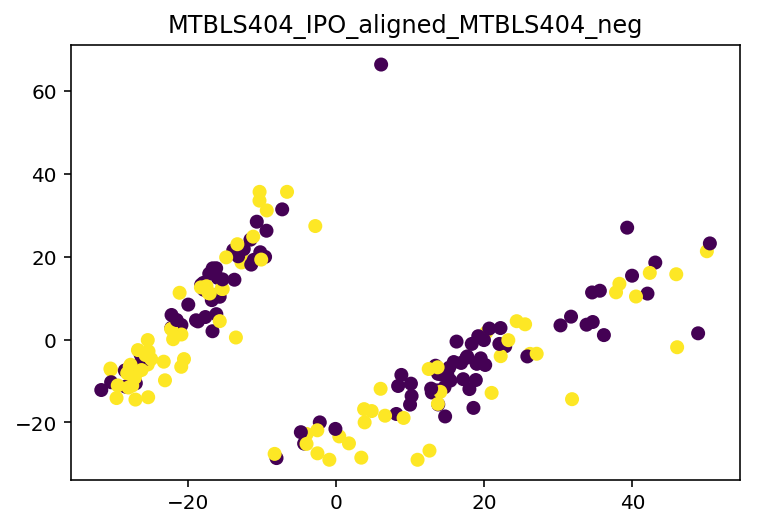

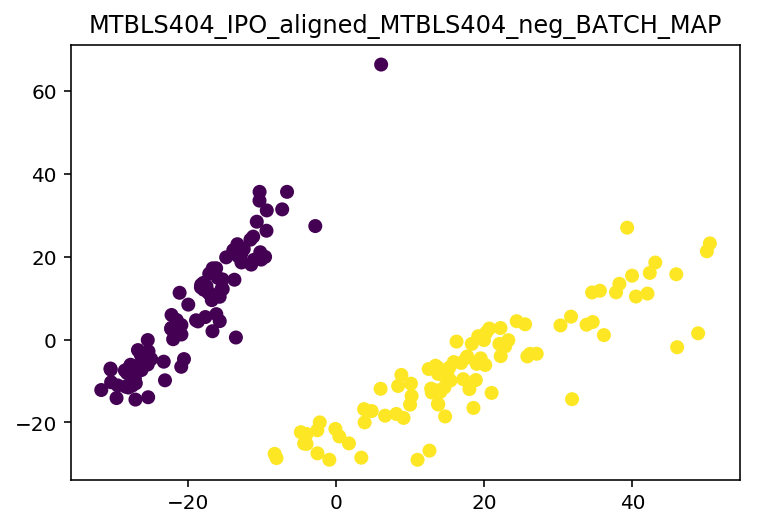

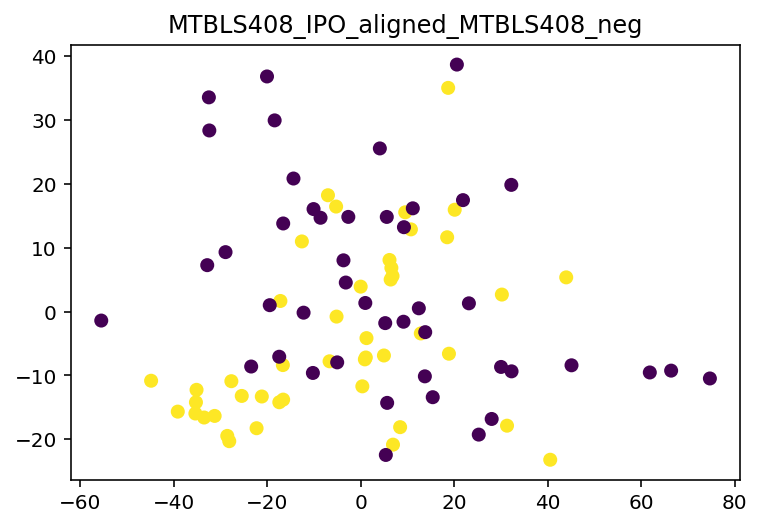

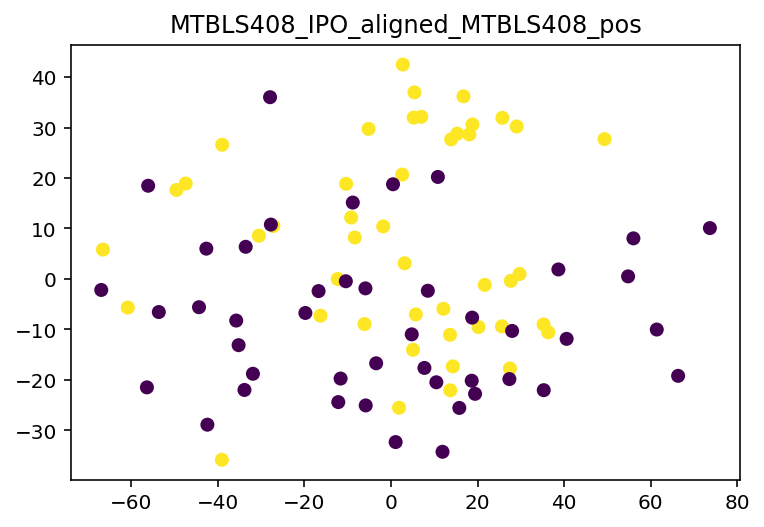

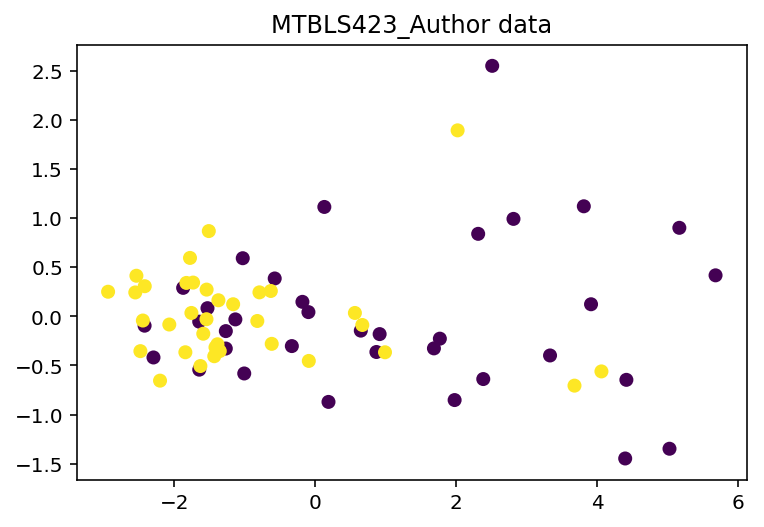

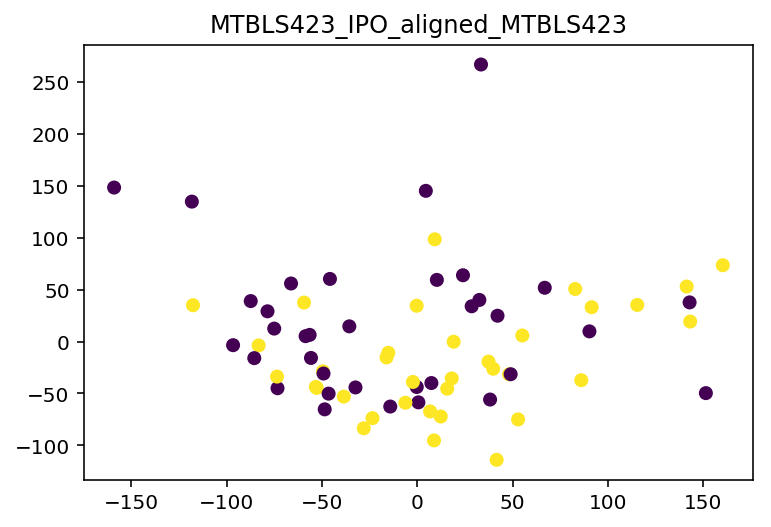

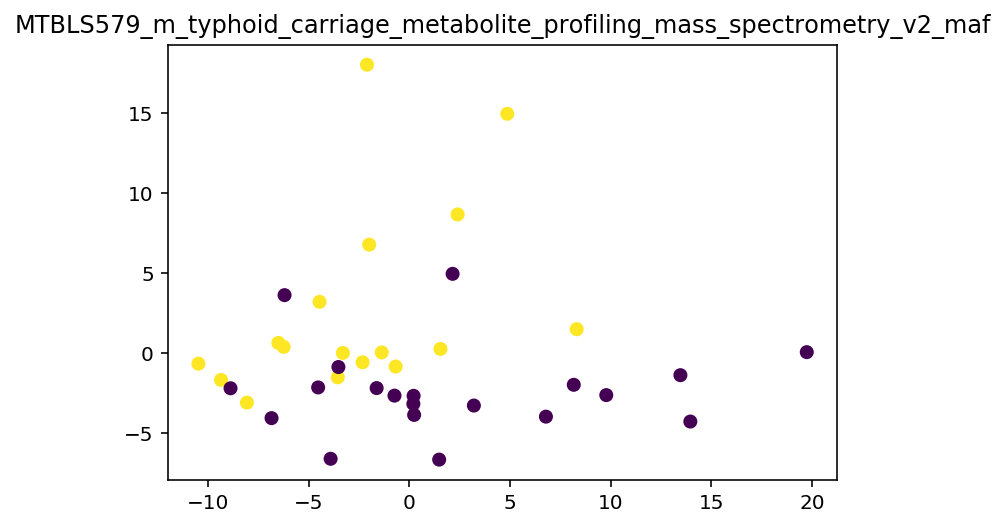

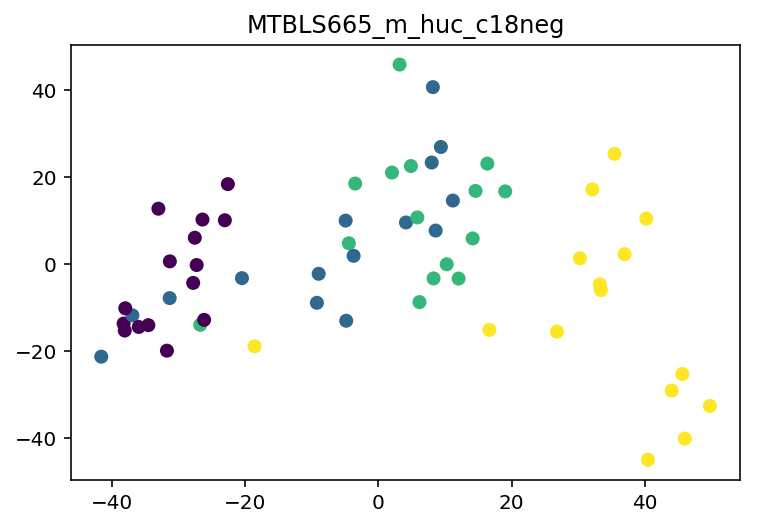

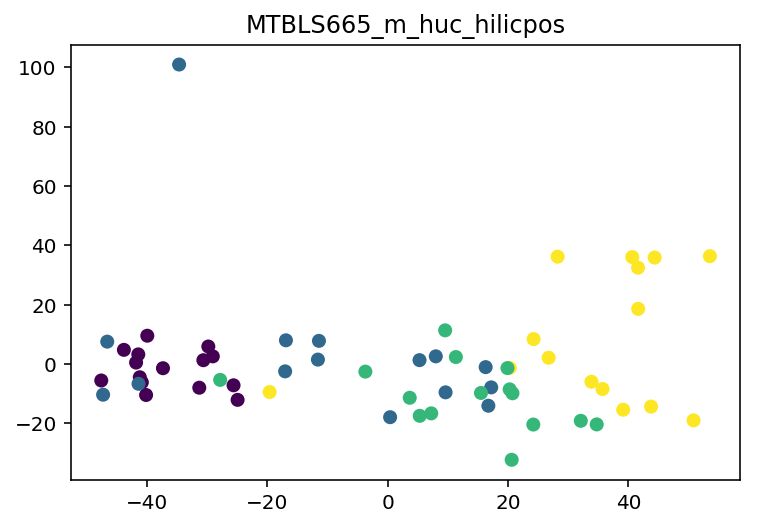

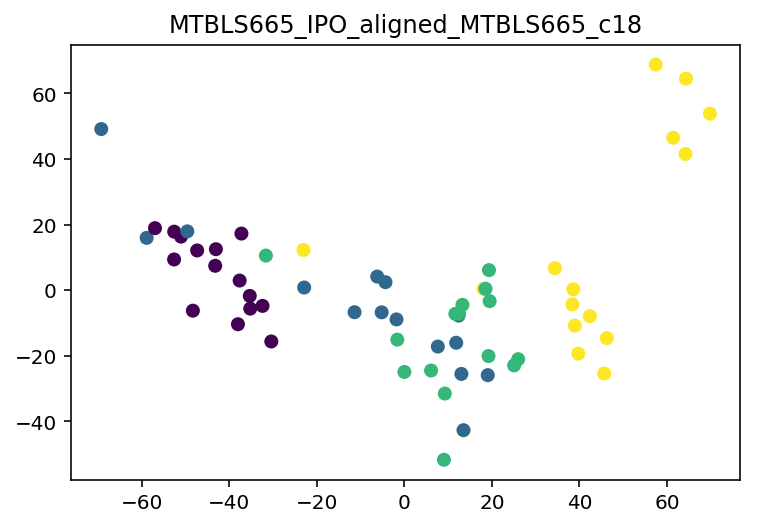

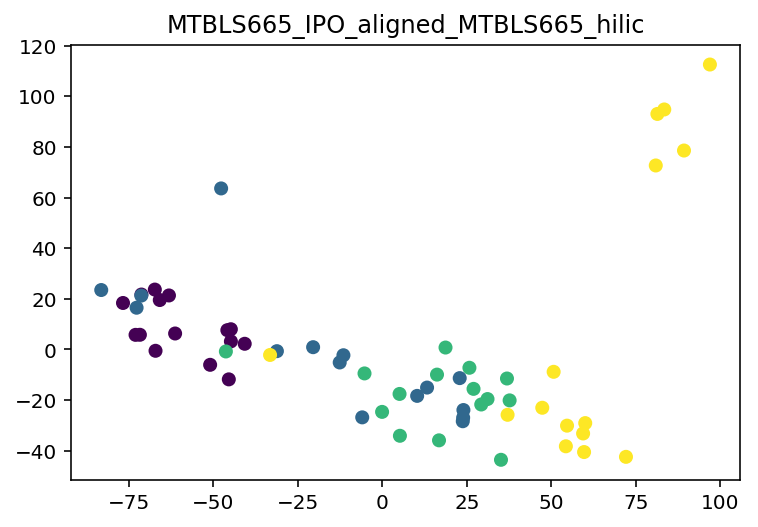

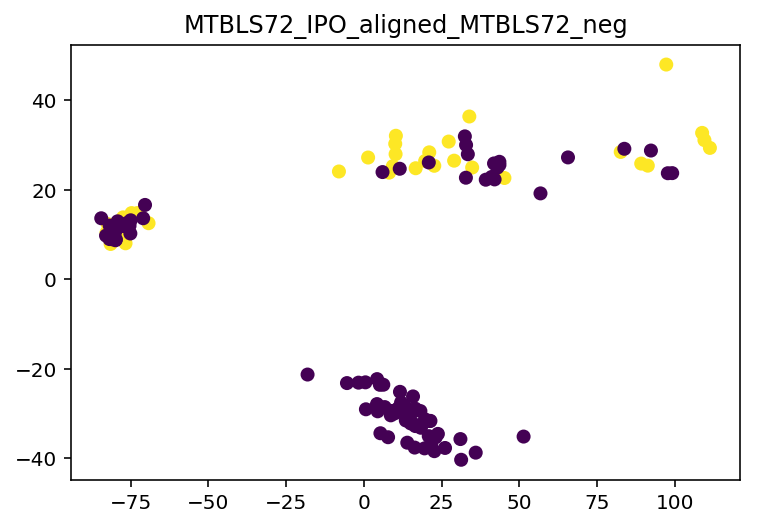

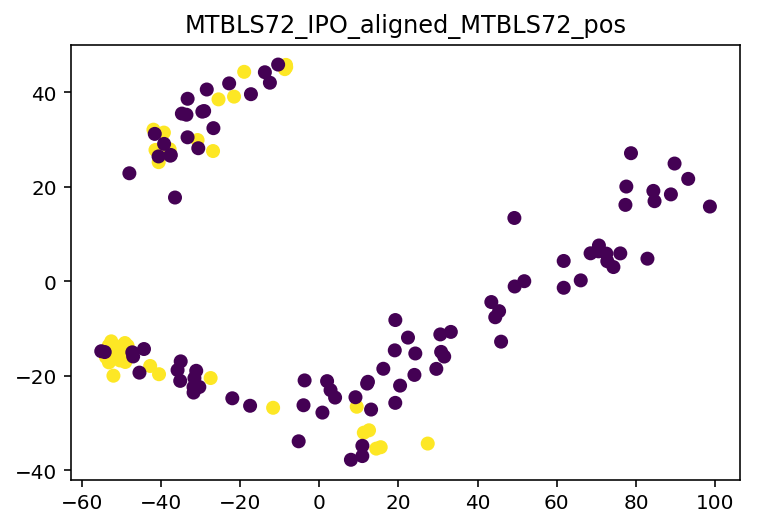

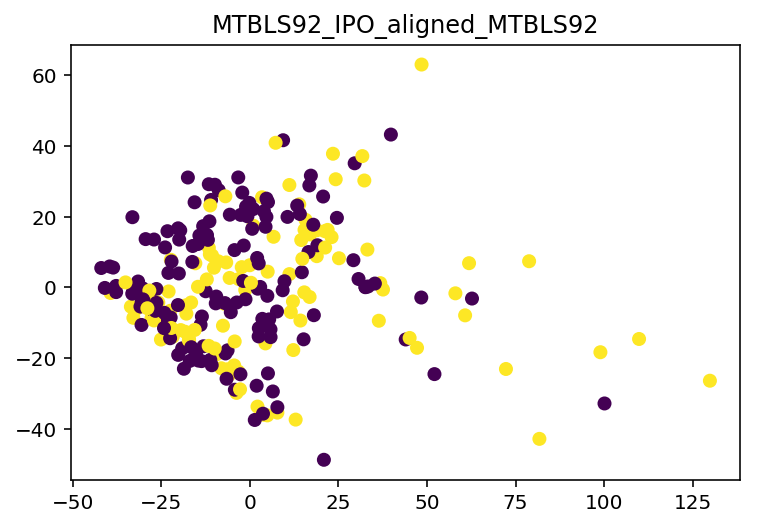

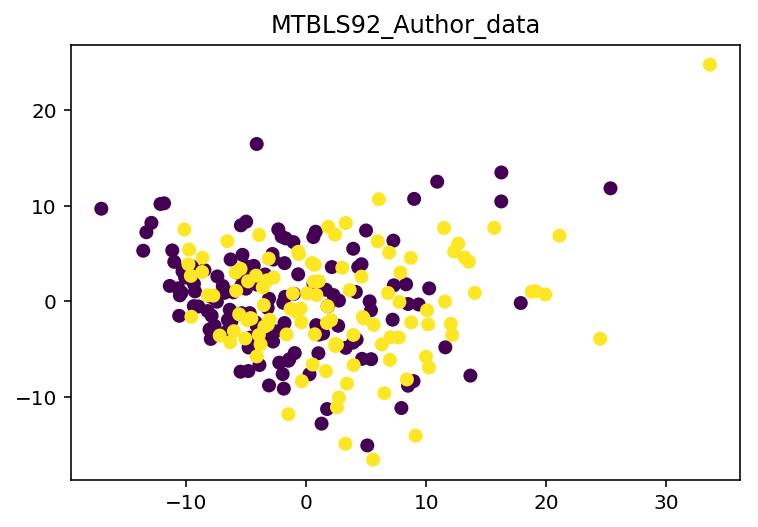

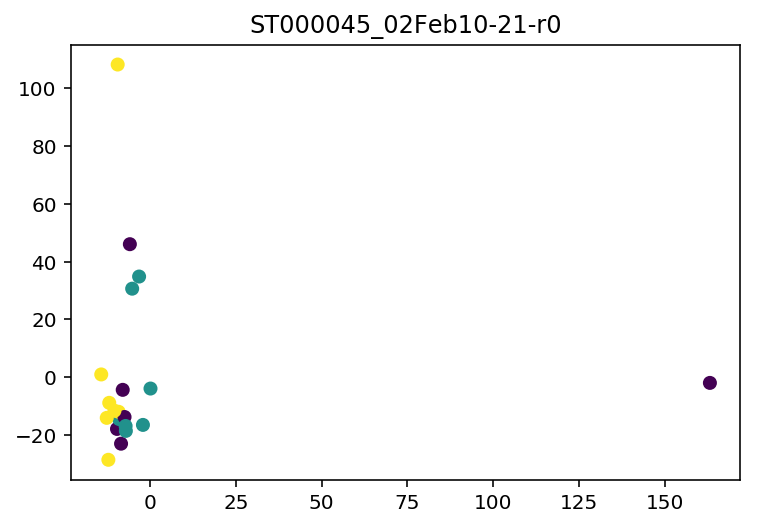

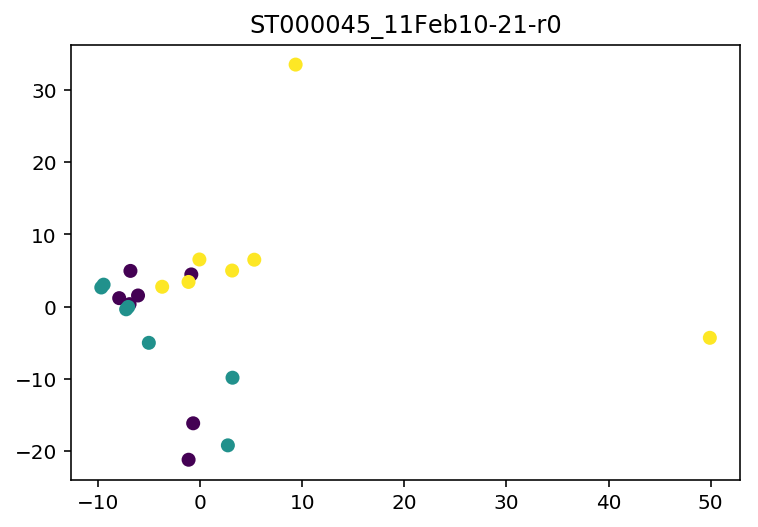

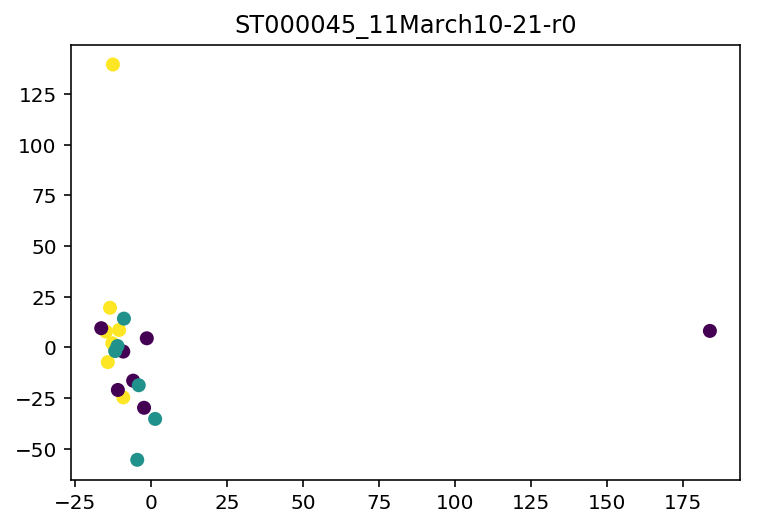

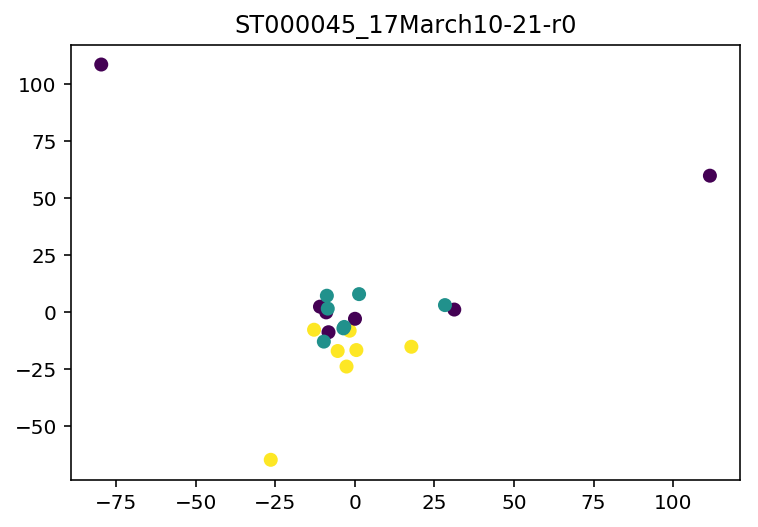

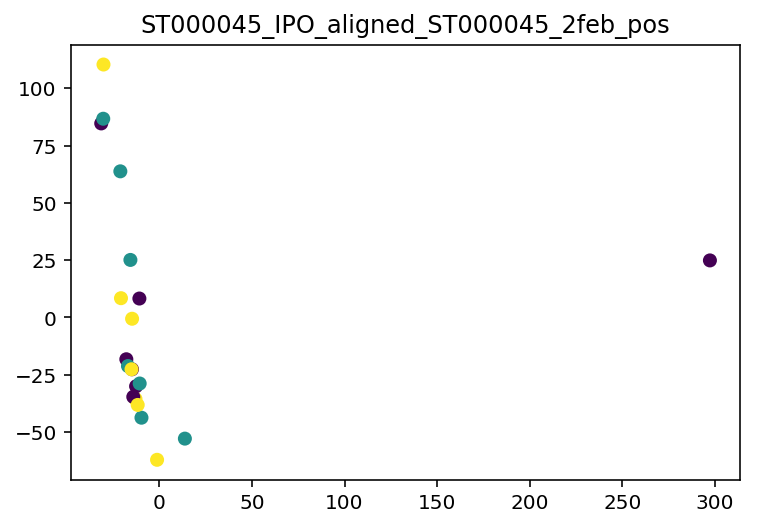

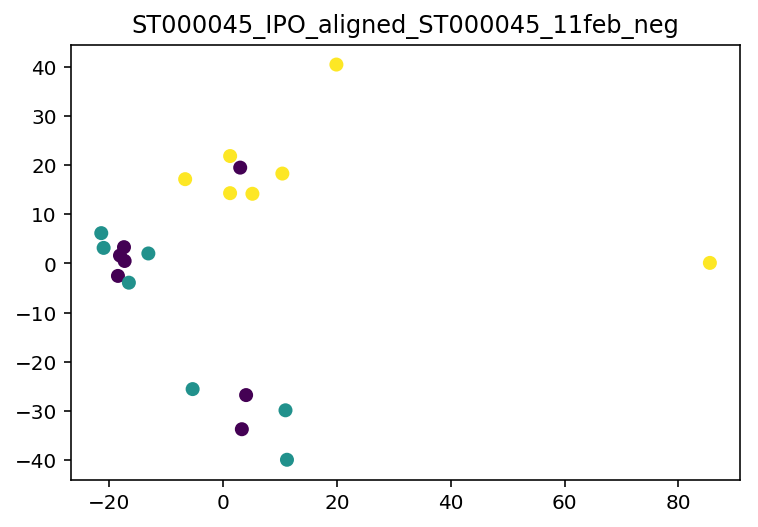

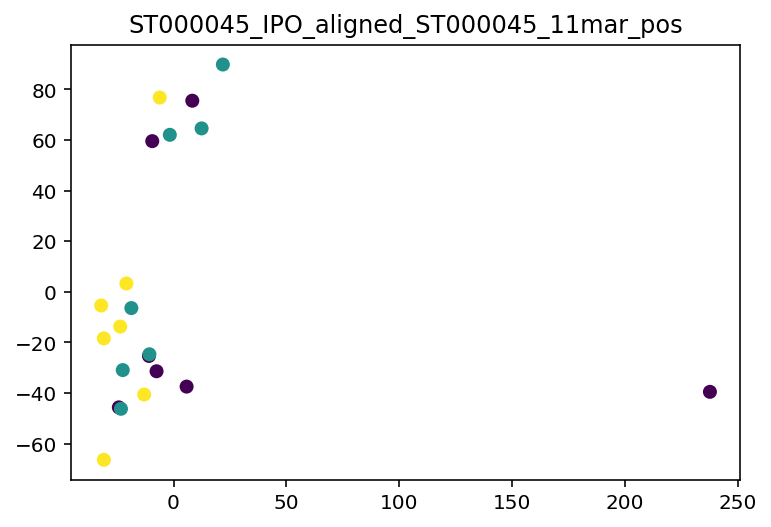

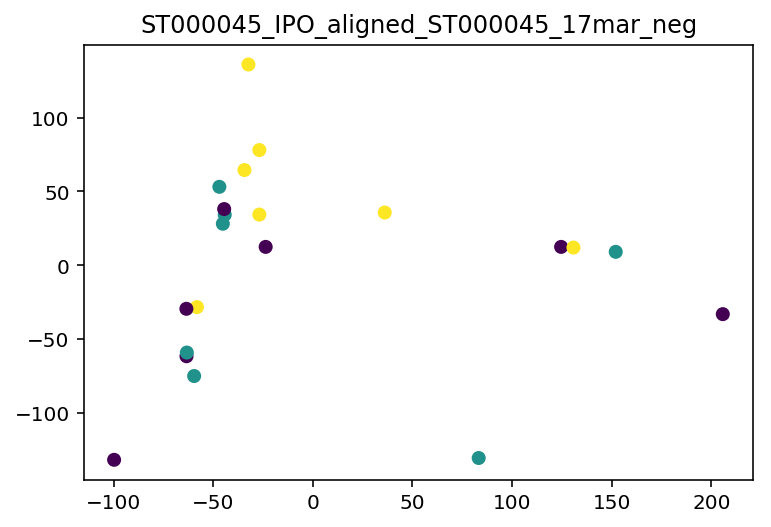

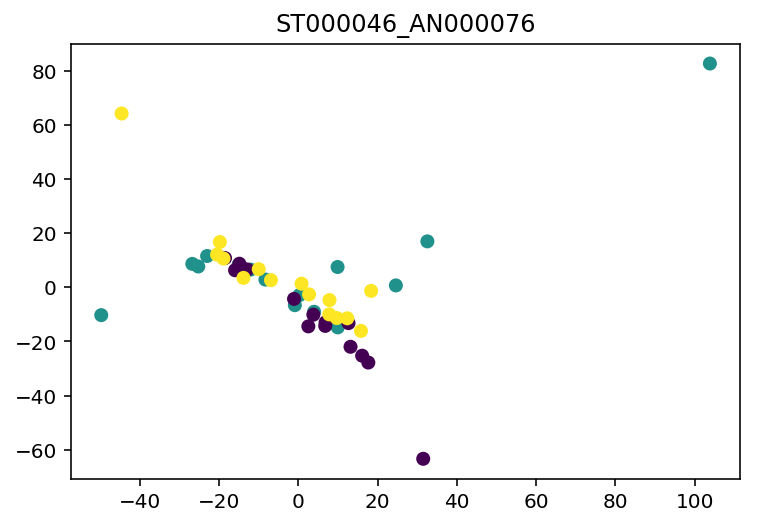

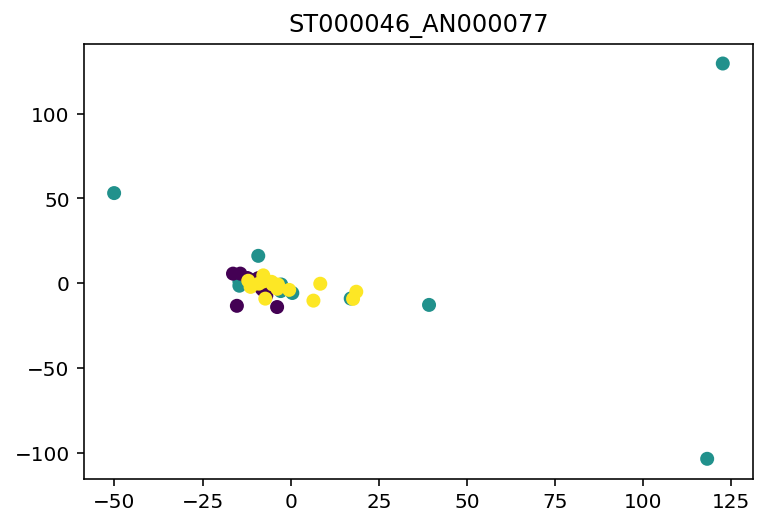

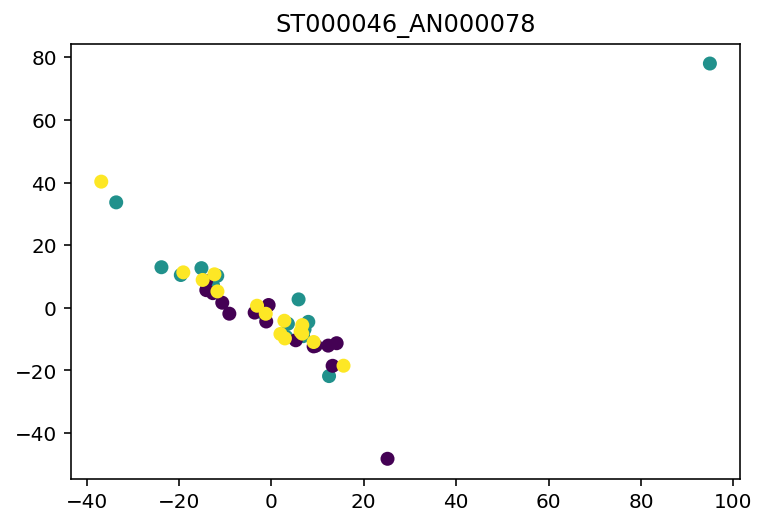

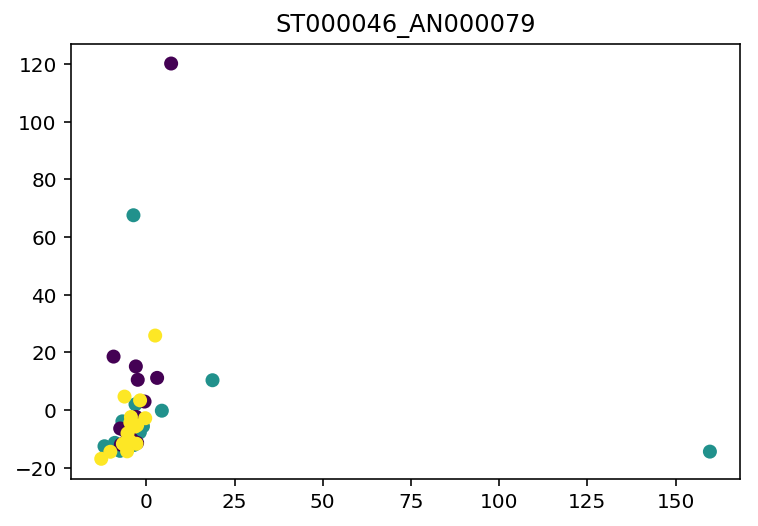

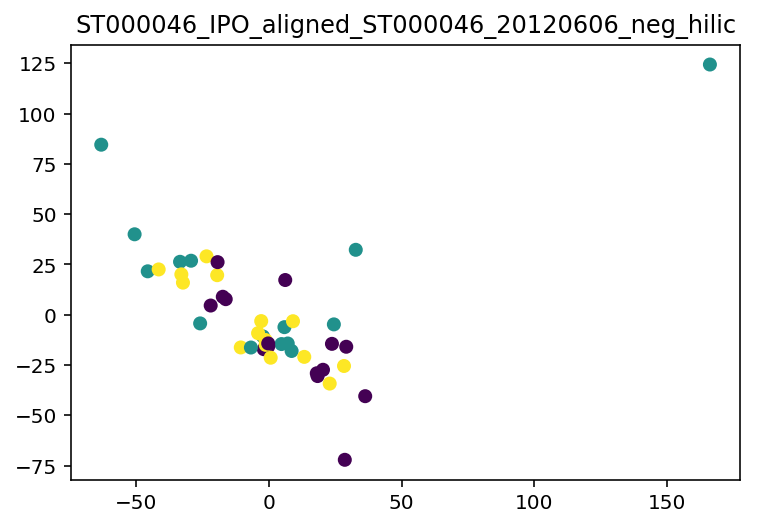

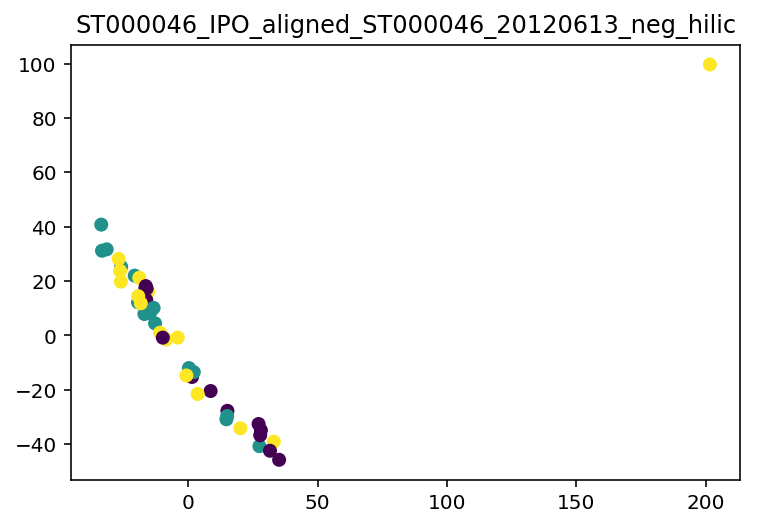

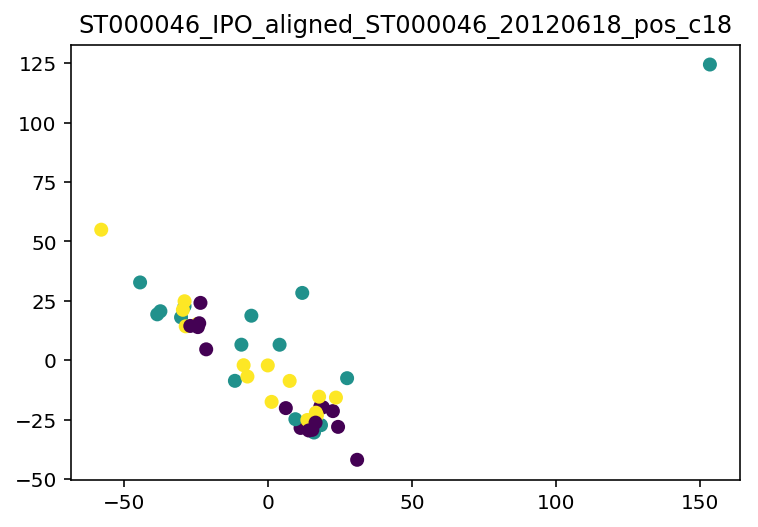

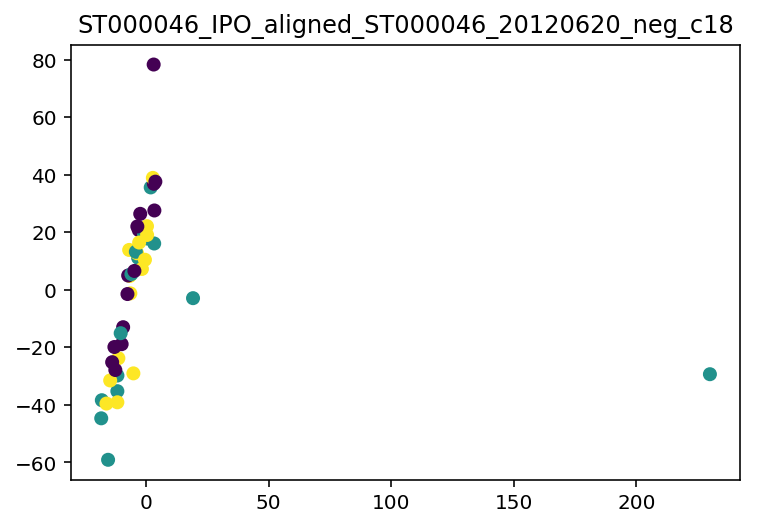

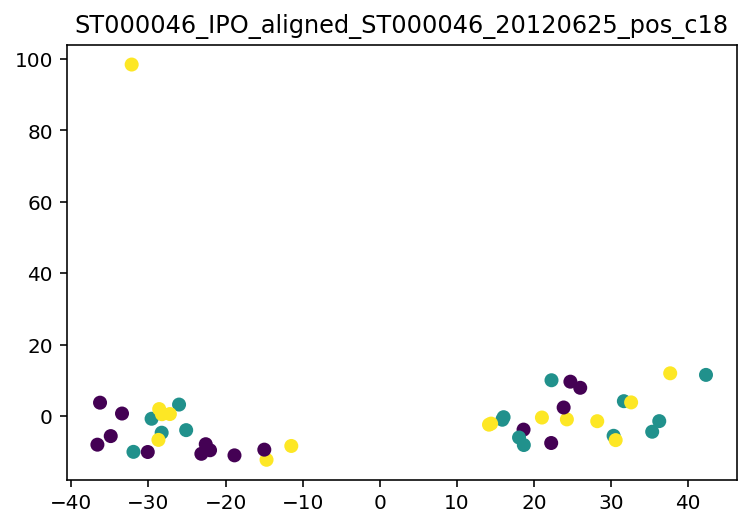

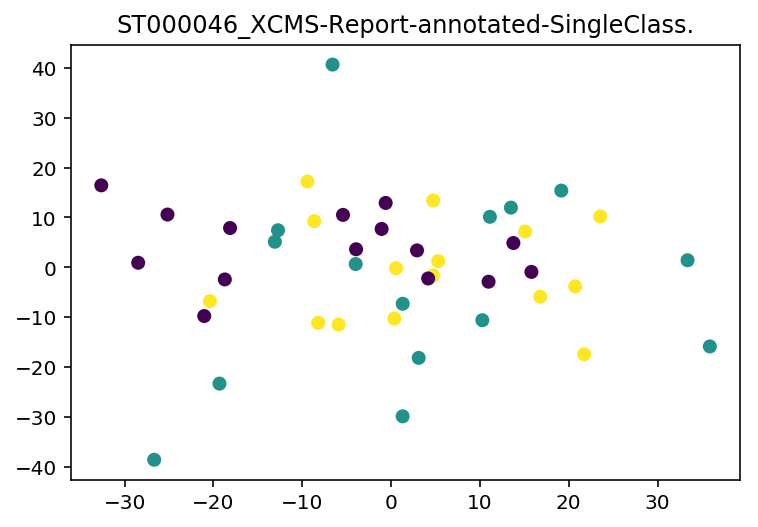

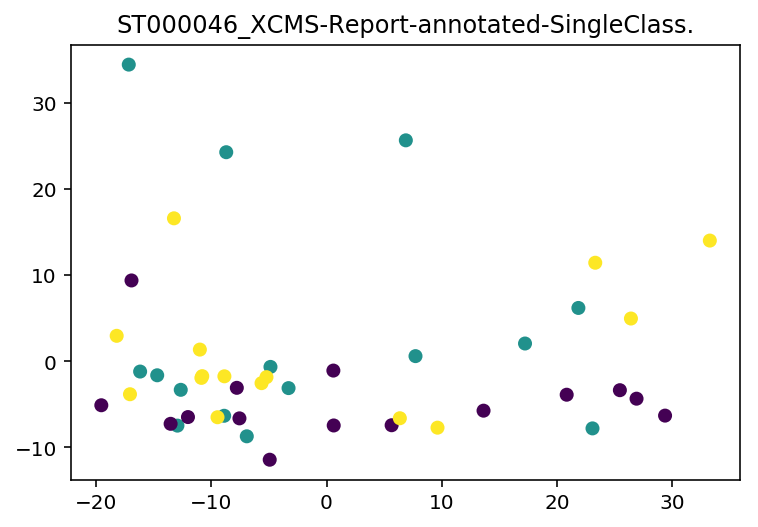

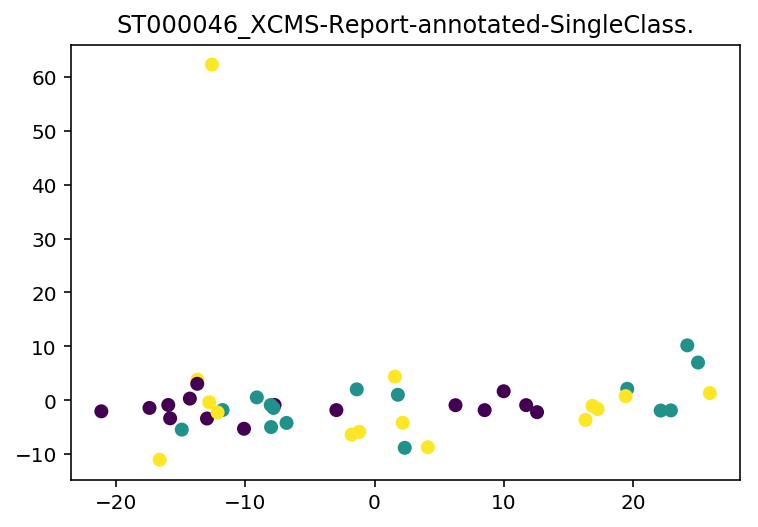

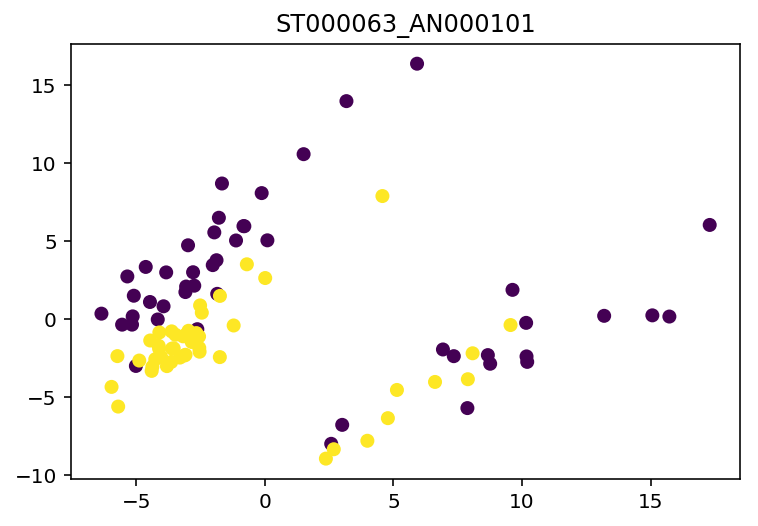

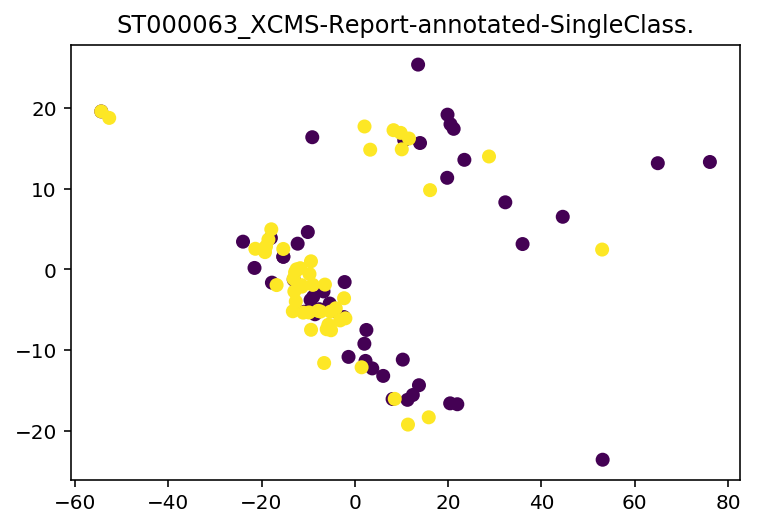

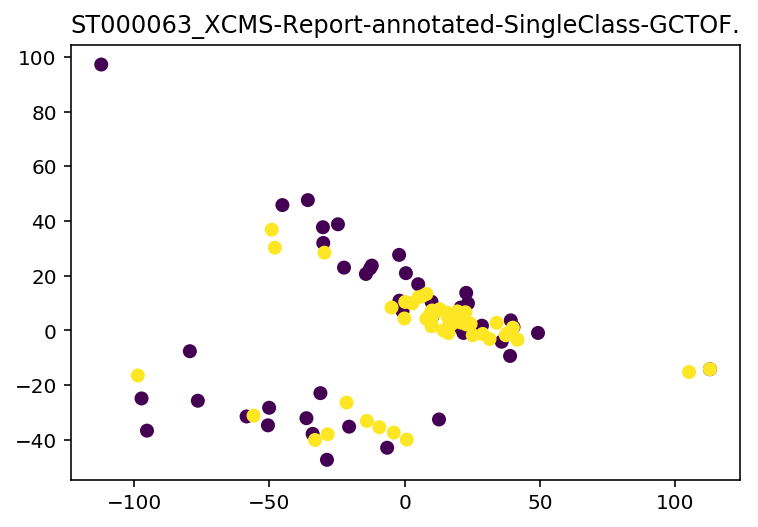

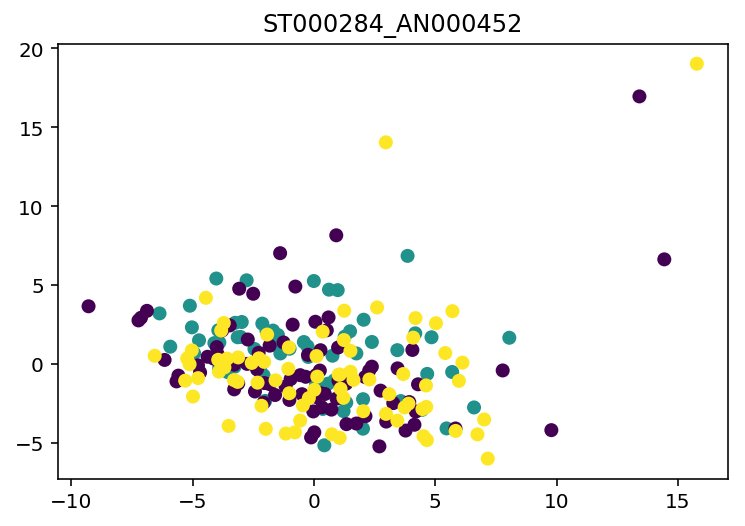

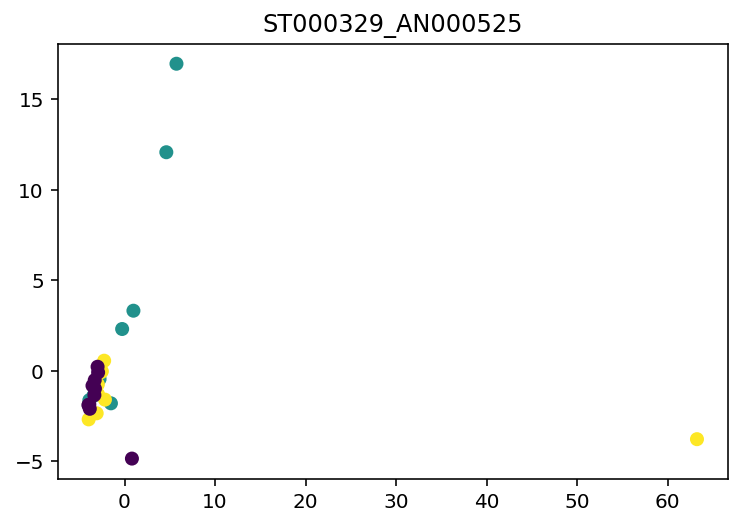

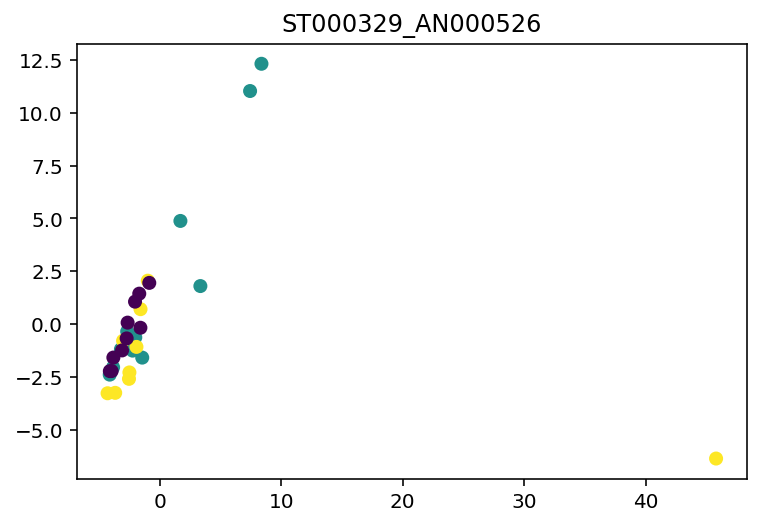

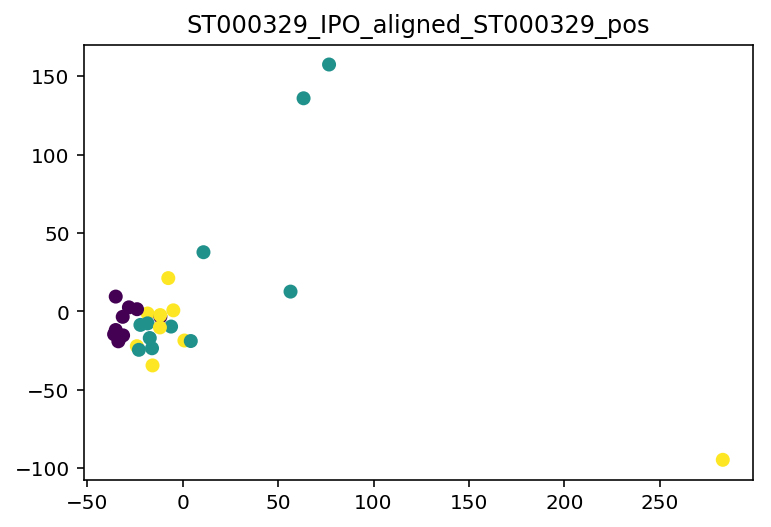

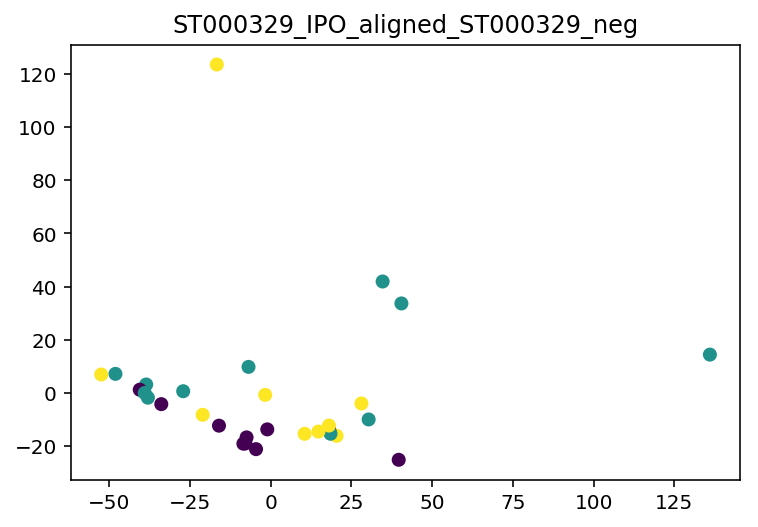

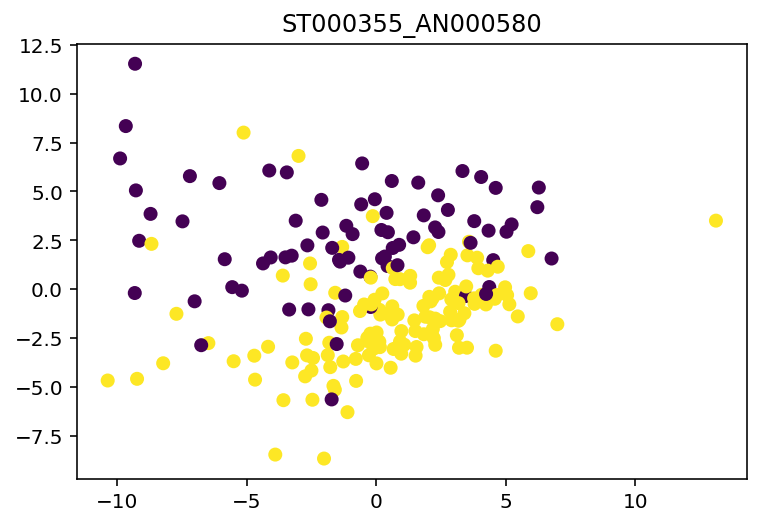

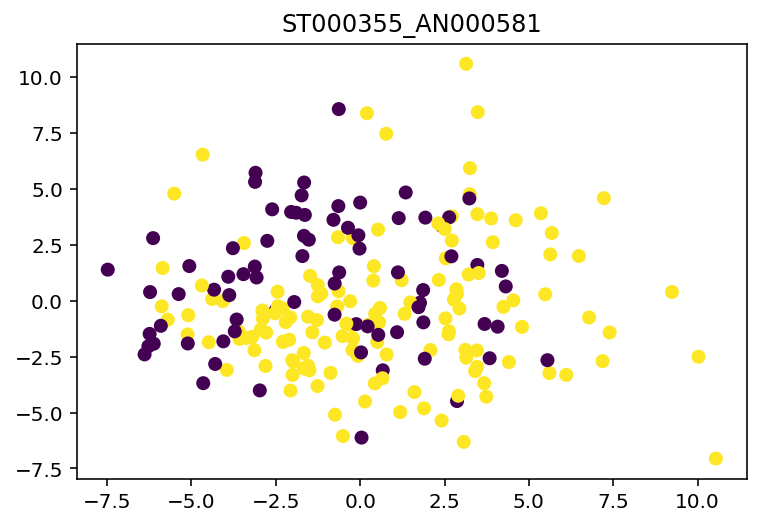

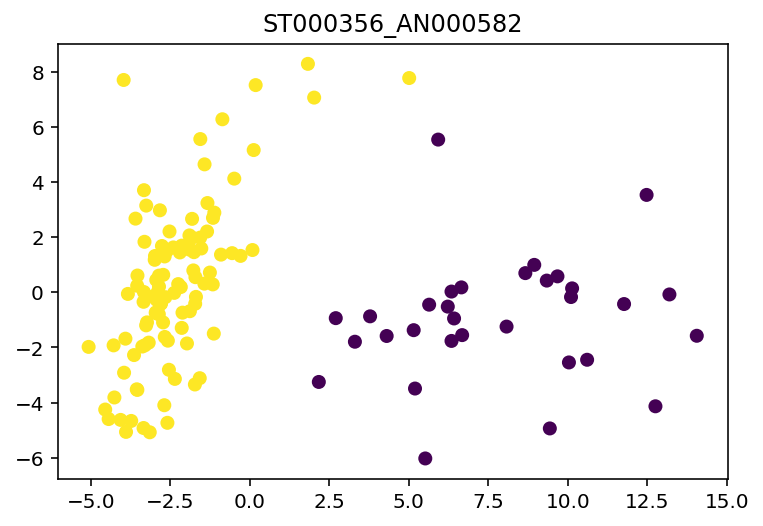

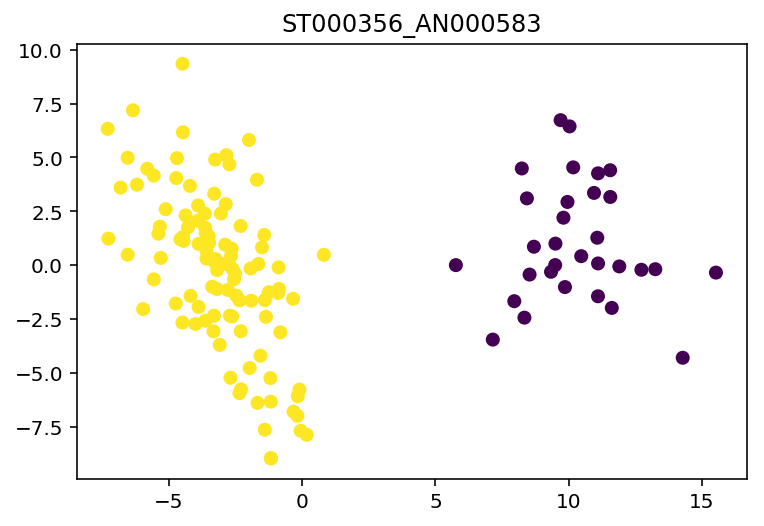

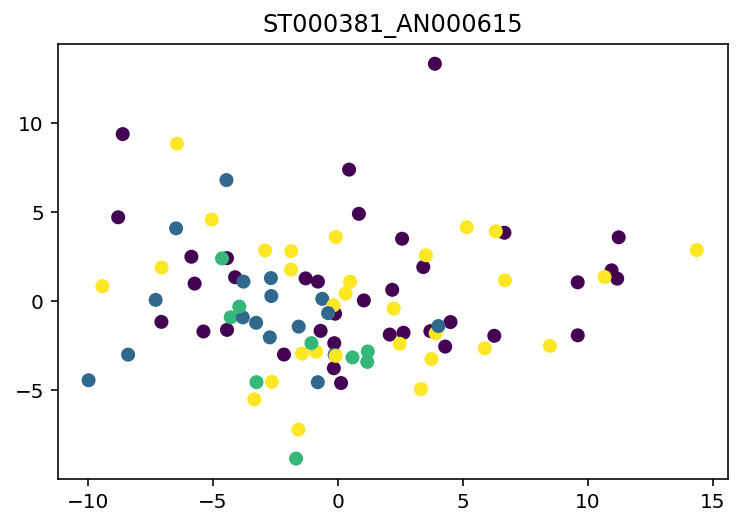

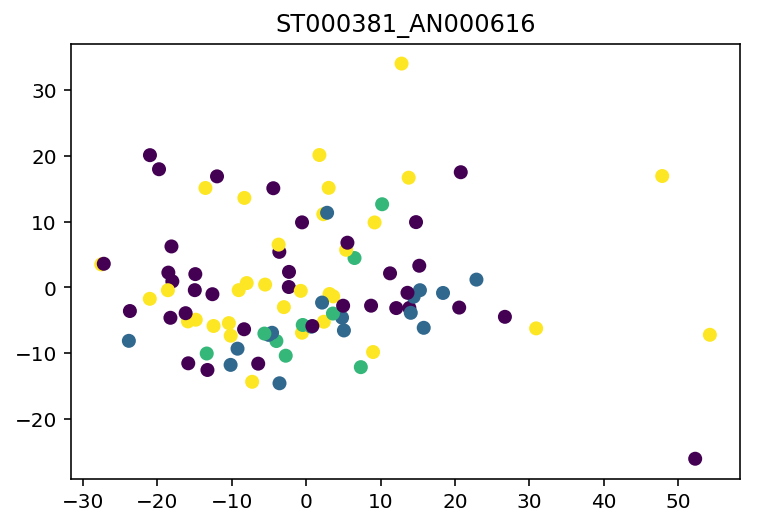

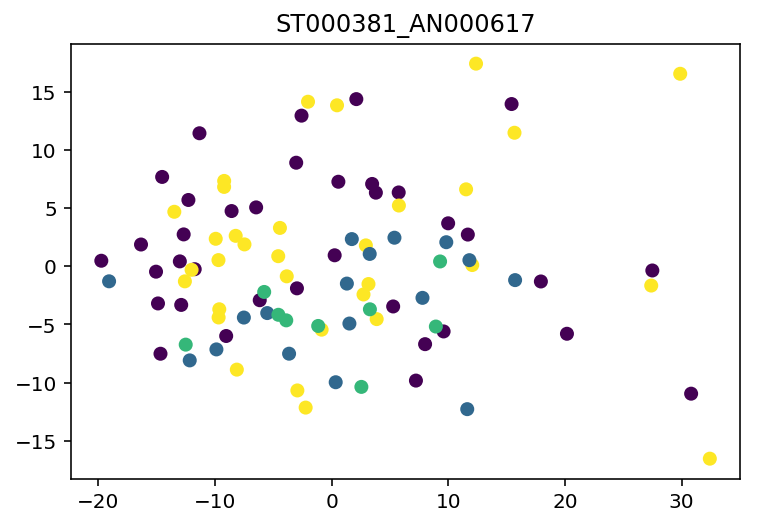

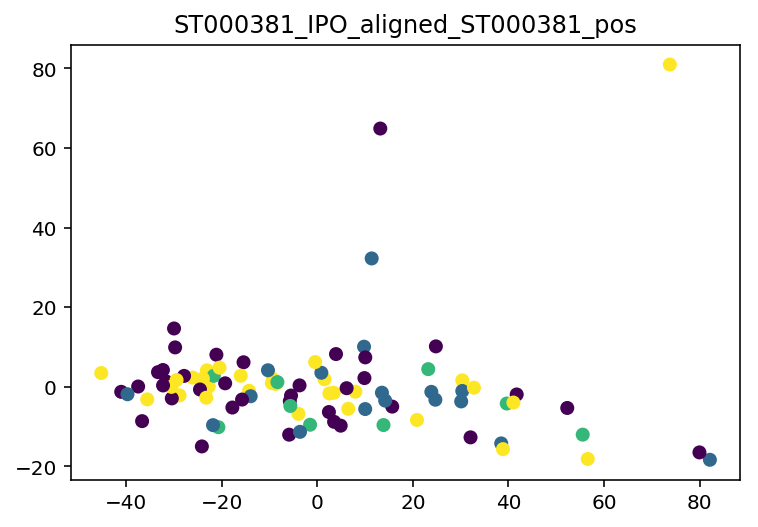

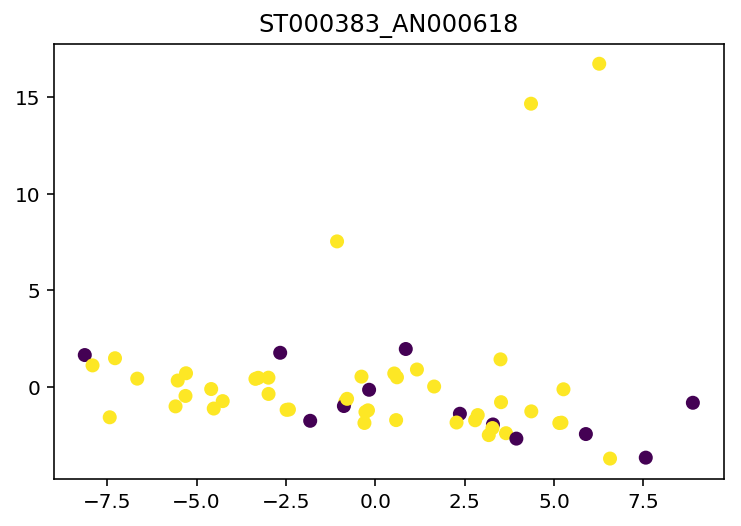

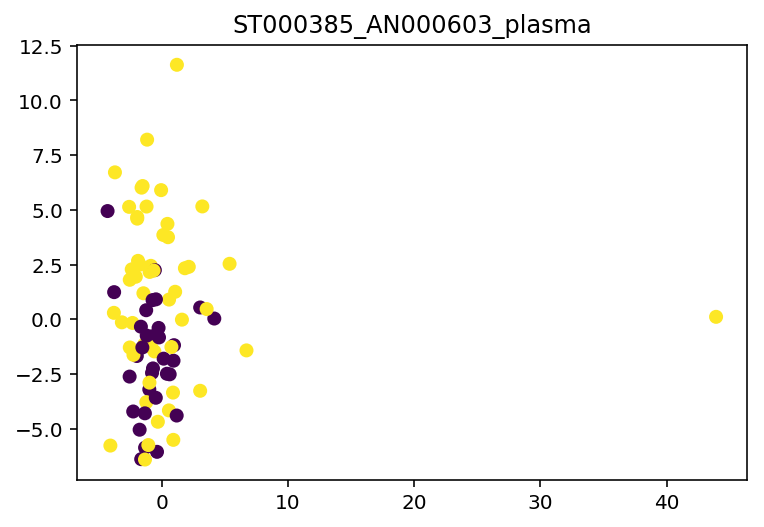

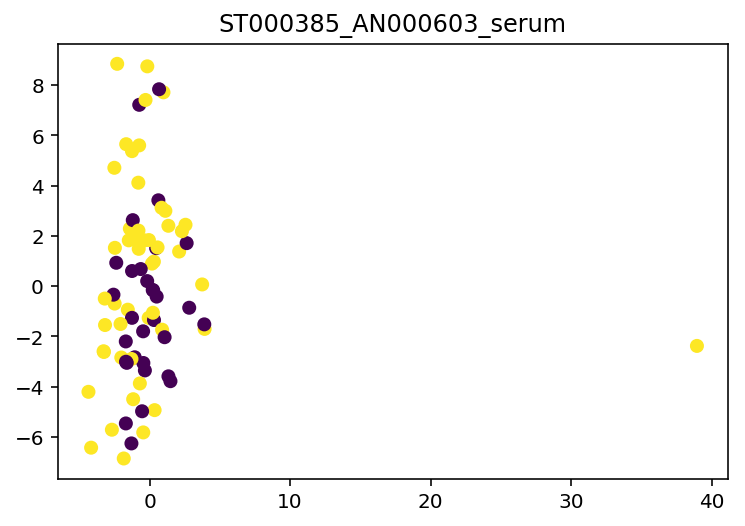

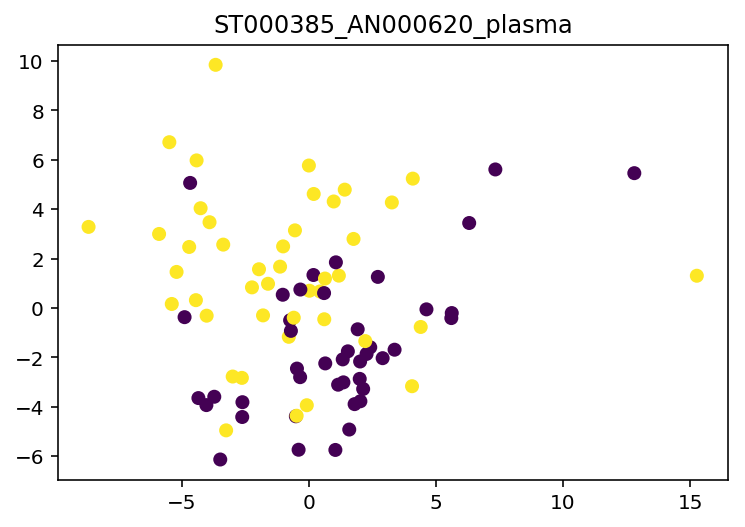

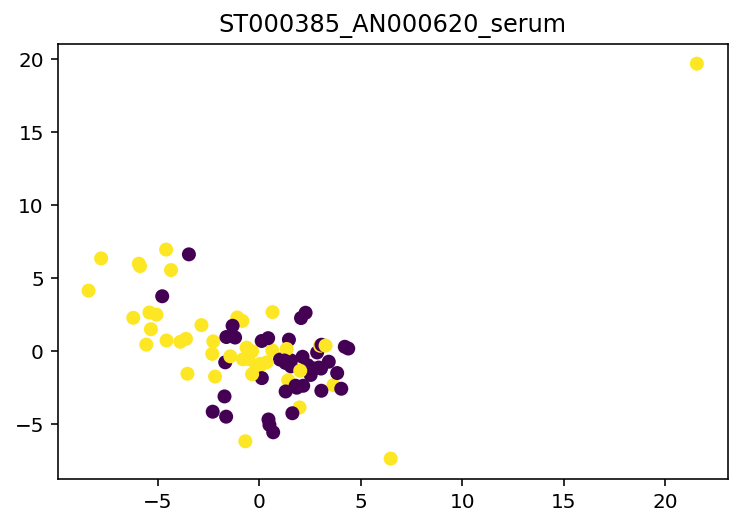

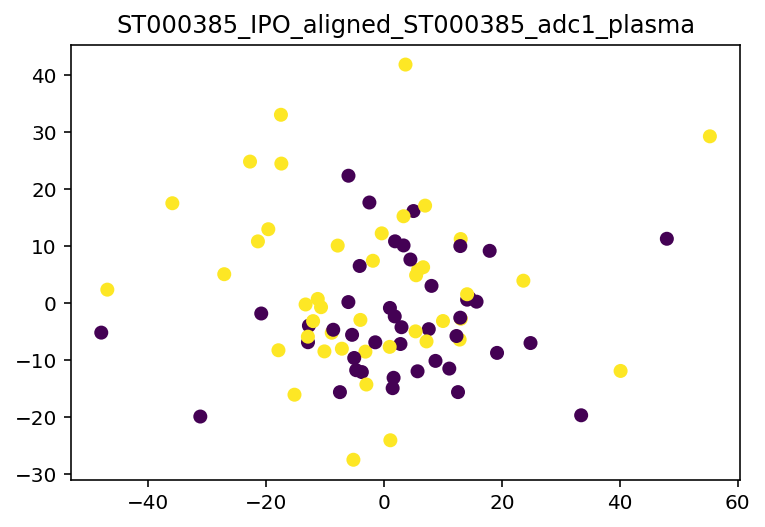

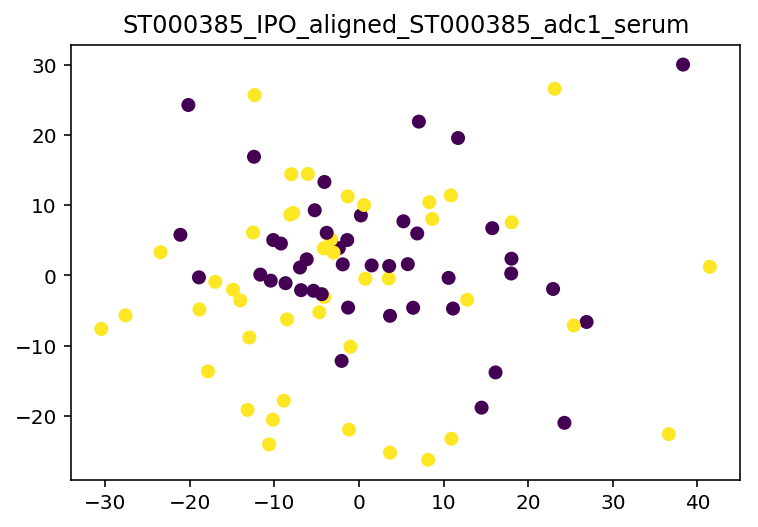

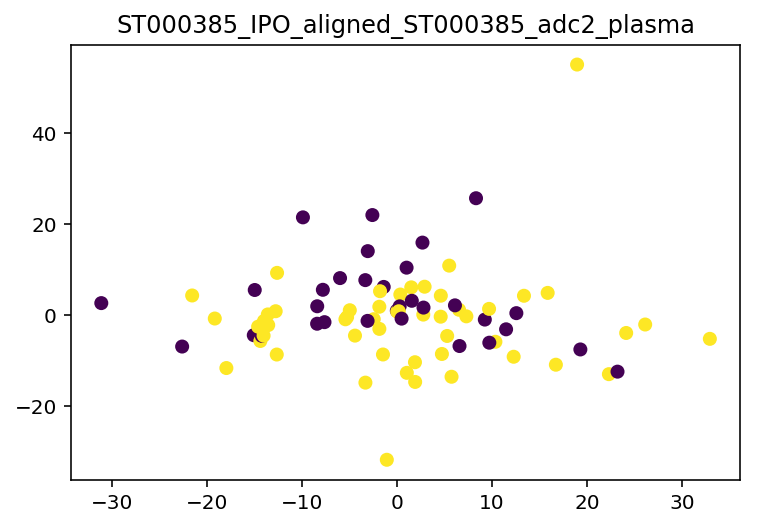

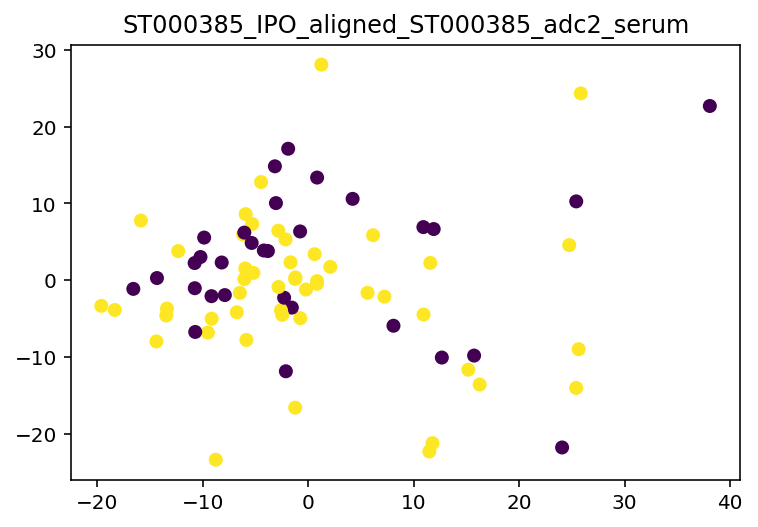

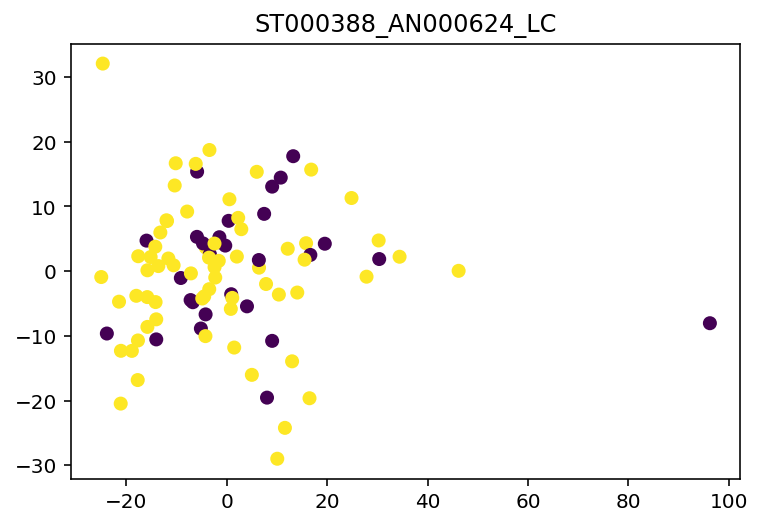

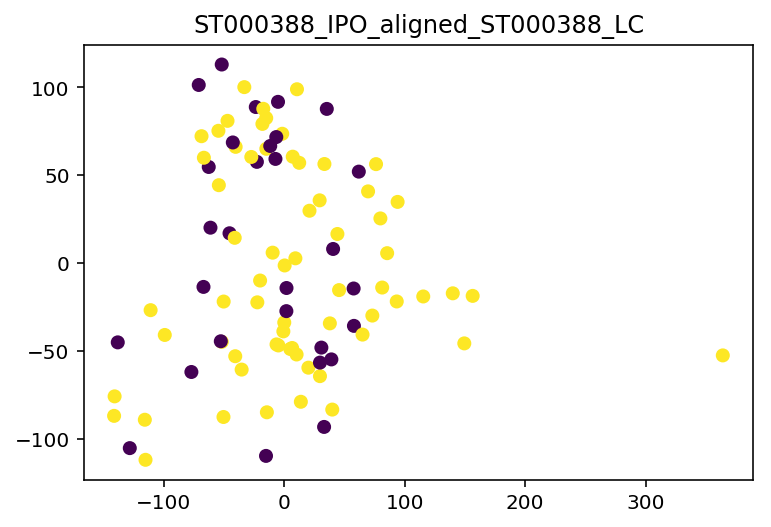

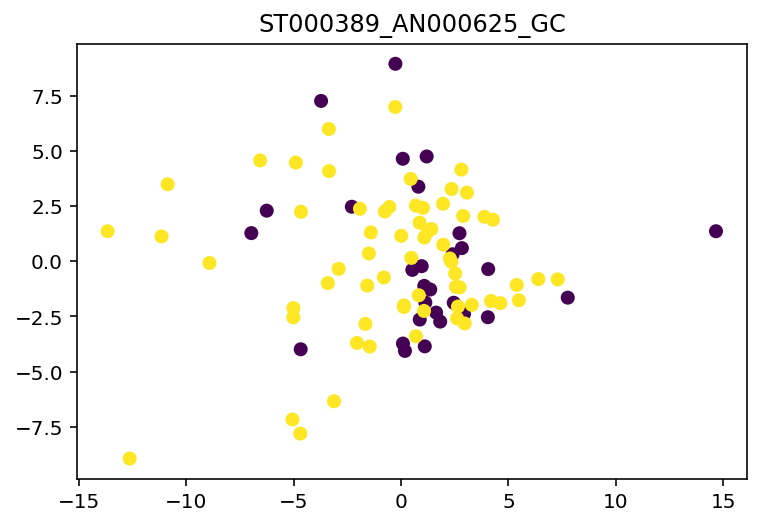

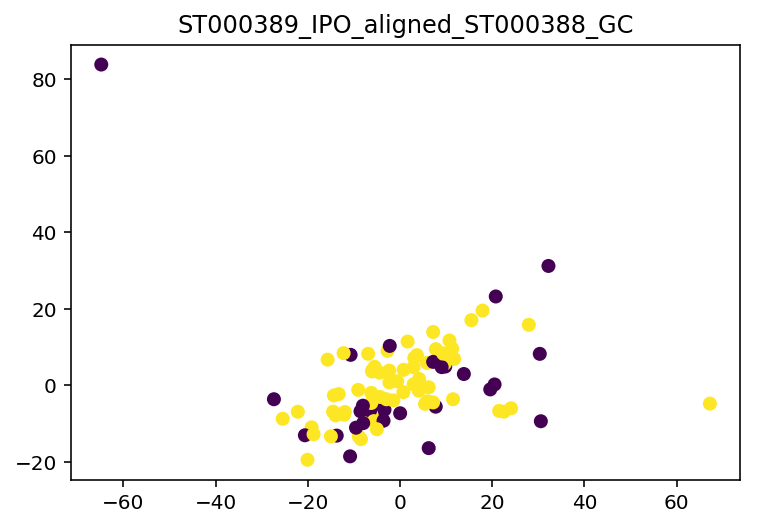

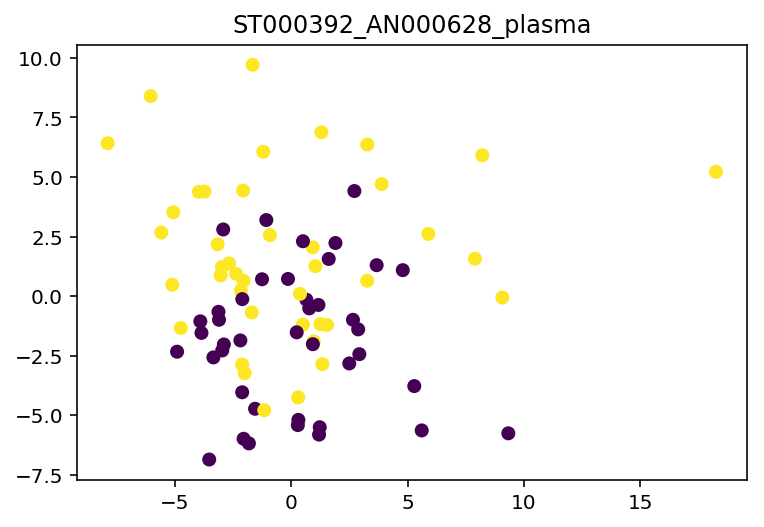

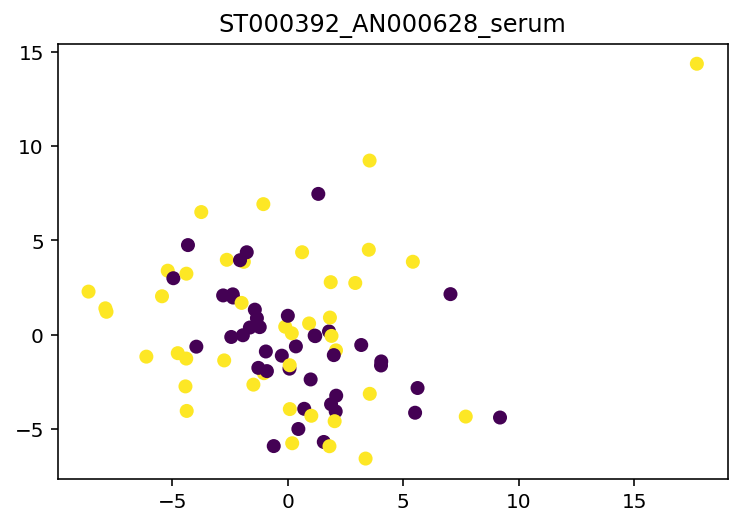

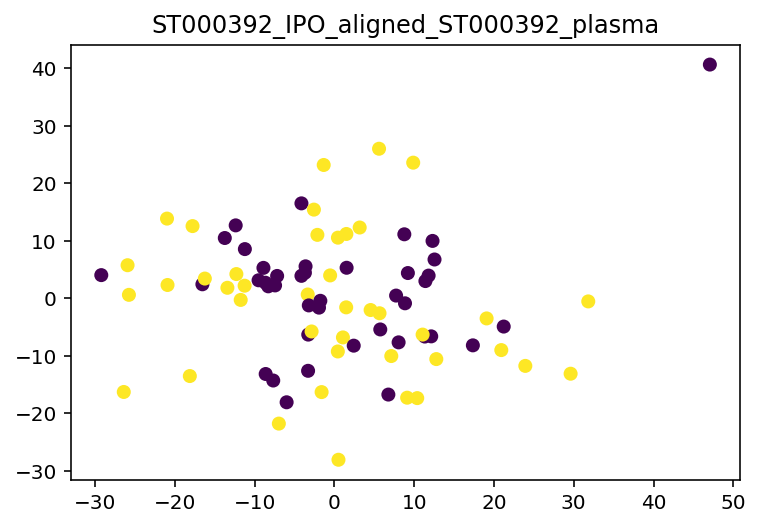

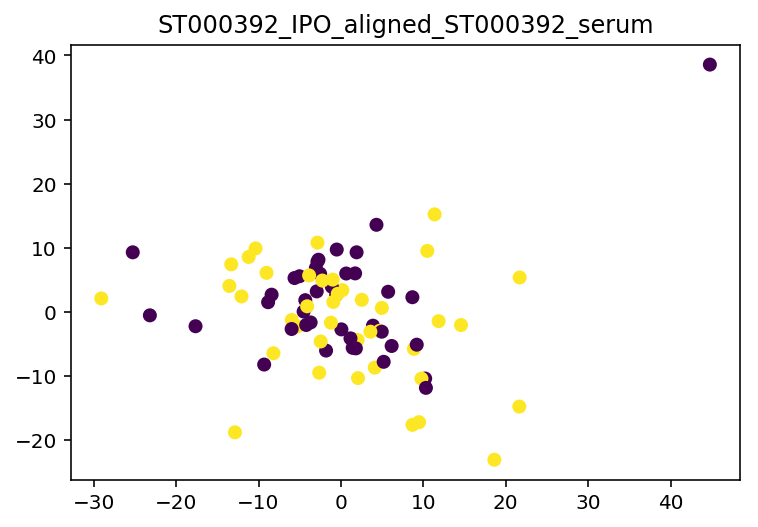

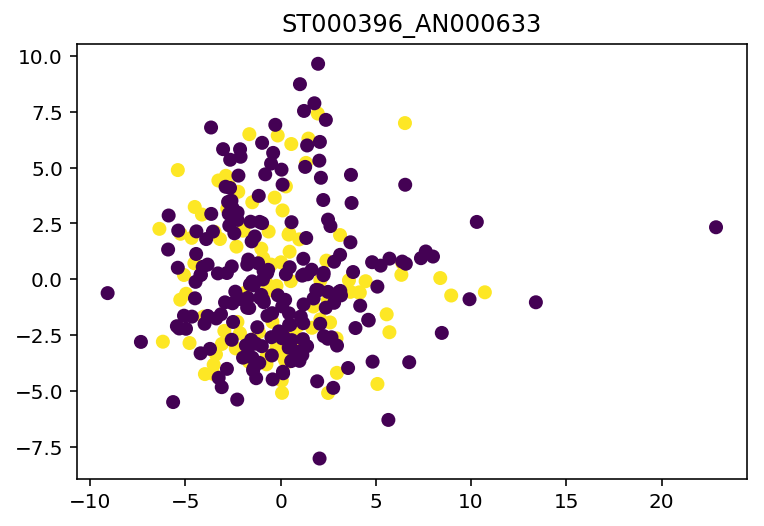

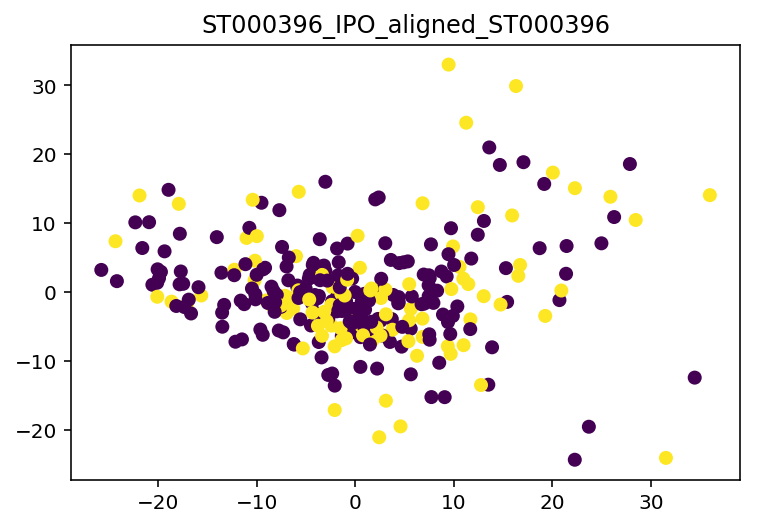

ST000397 AN000634 (<class 'ValueError'>, ValueError('c of shape (48,) not acceptable as a color sequence for x with size 48, y with size 48',), <traceback object at 0x7f8c2fa9ac88>)
ST000397 IPO_aligned_ST000397_pos (<class 'ValueError'>, ValueError('c of shape (48,) not acceptable as a color sequence for x with size 48, y with size 48',), <traceback object at 0x7f8c2fa9a2c8>)


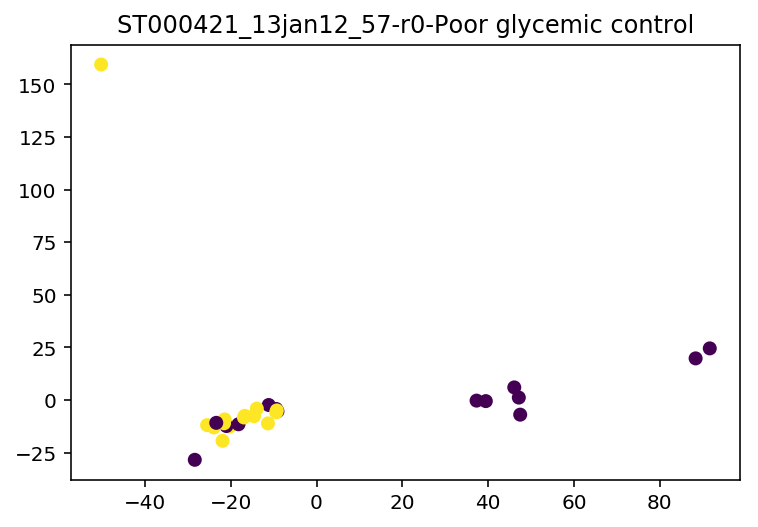

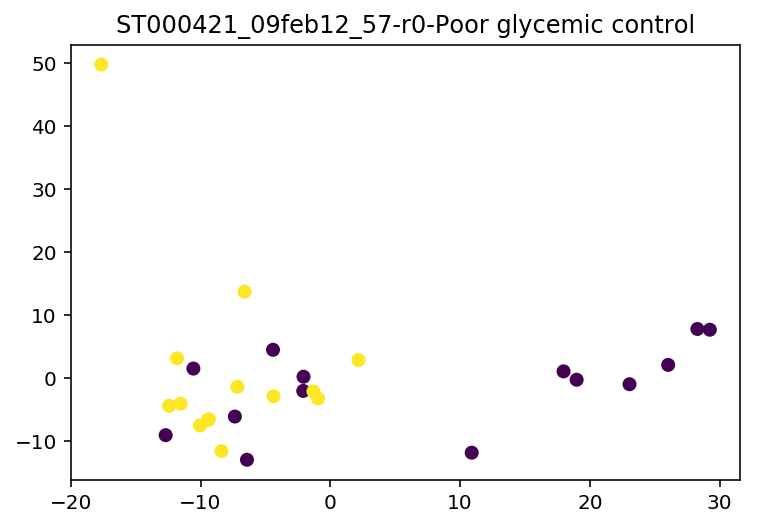

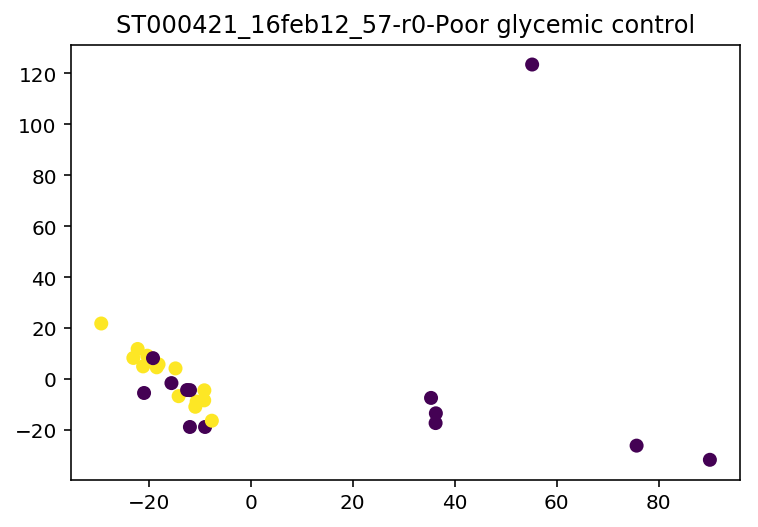

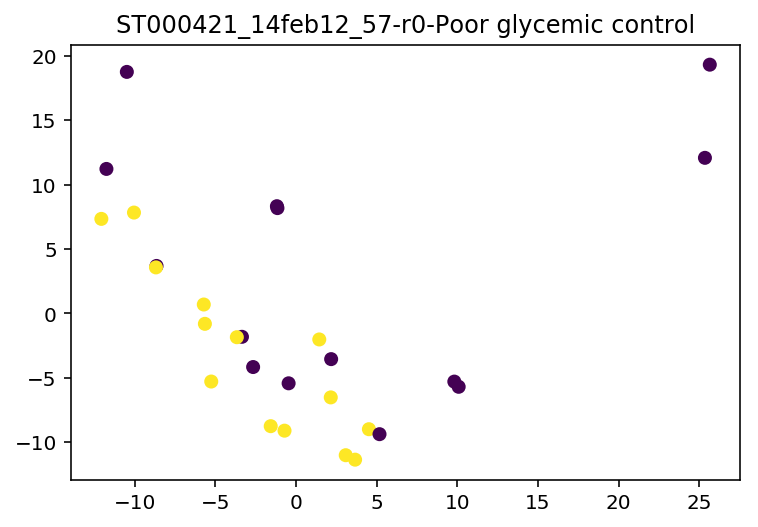

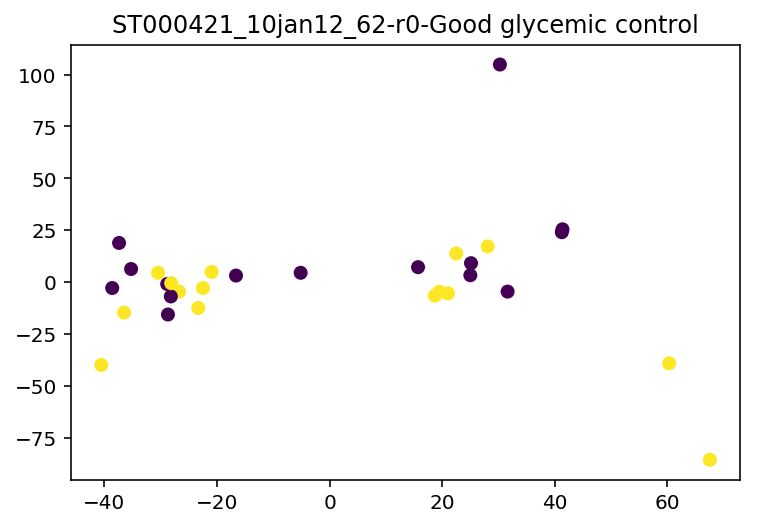

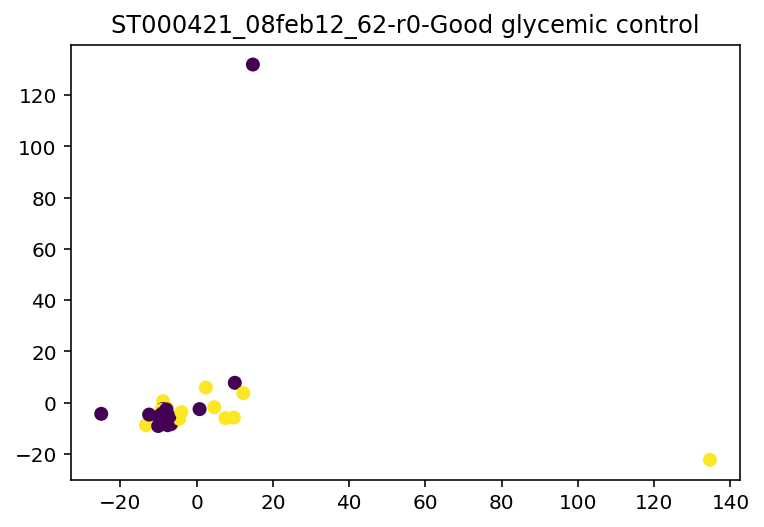

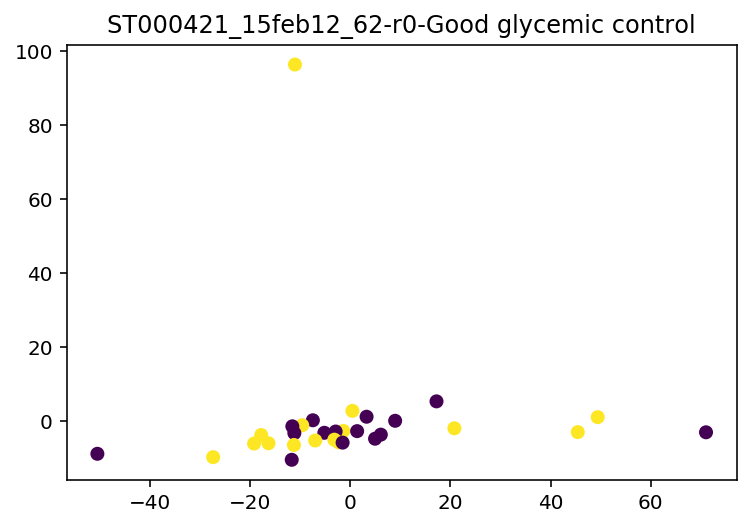

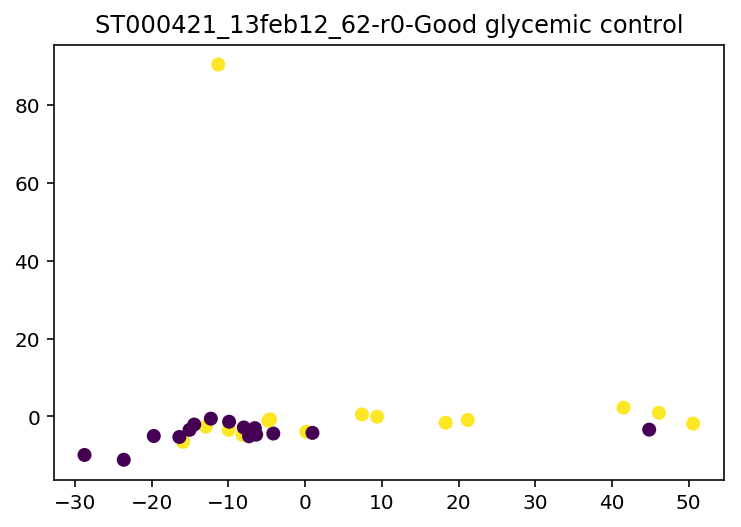

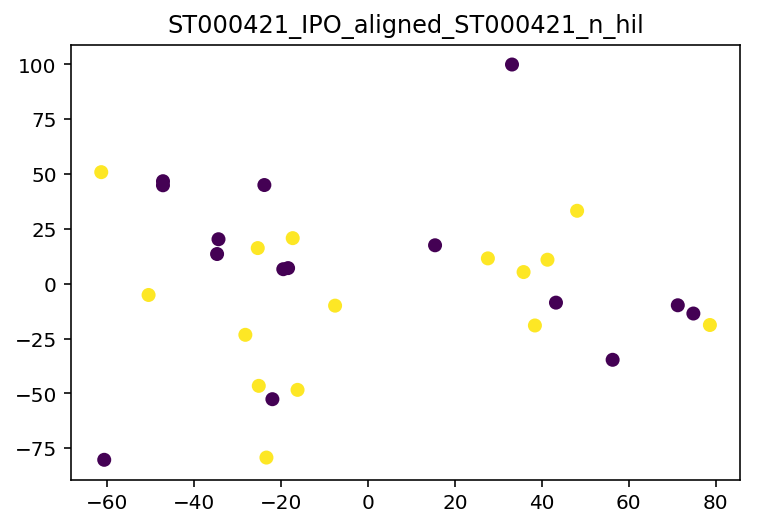

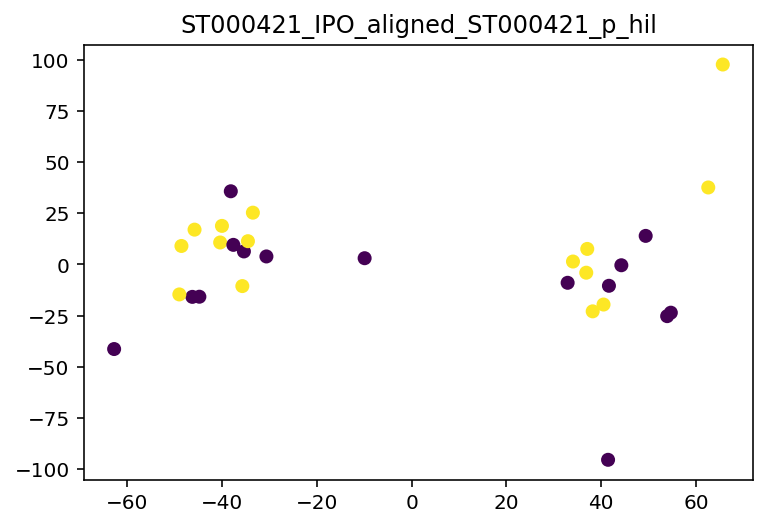

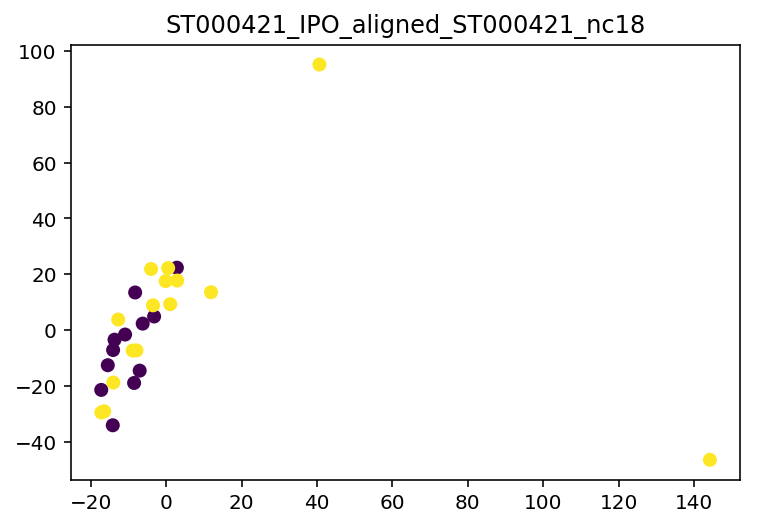

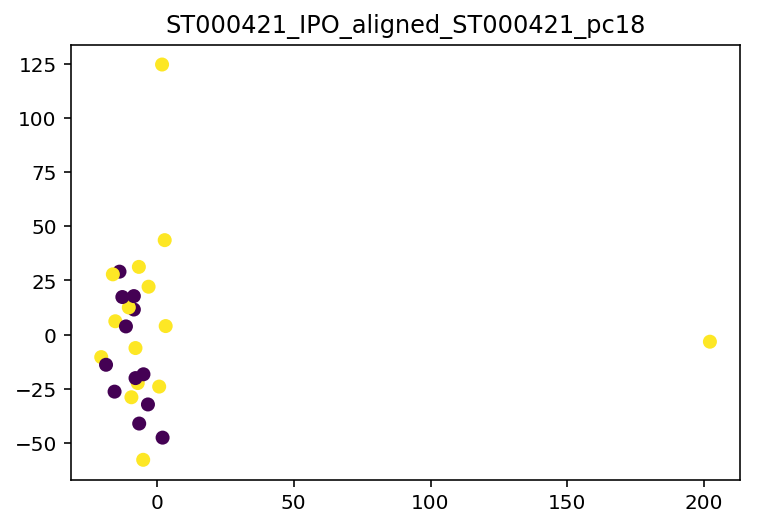

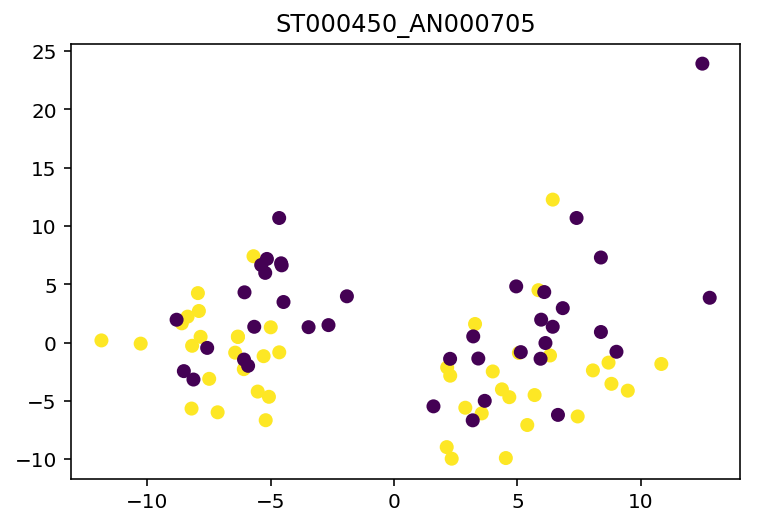

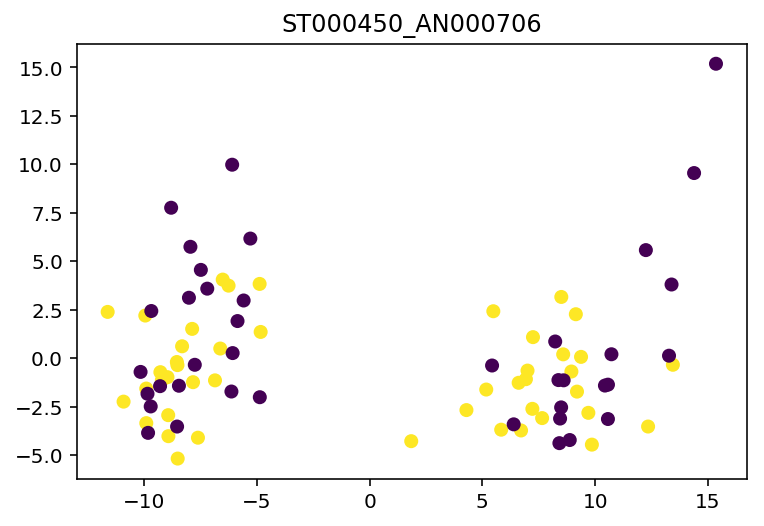

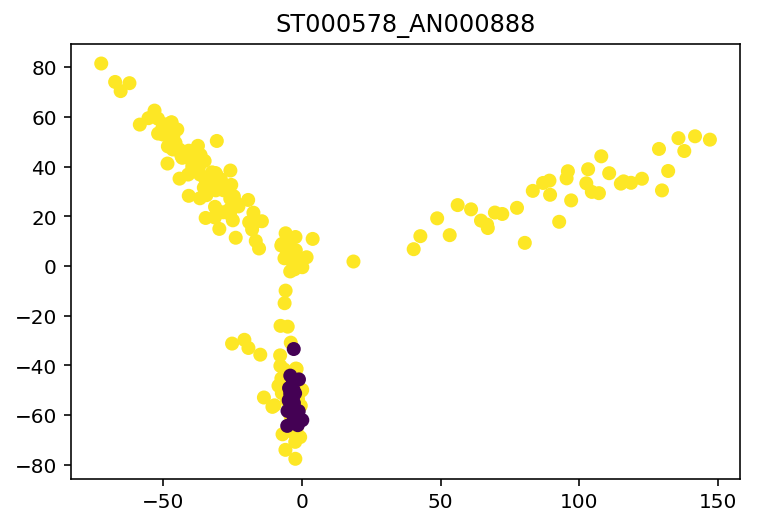

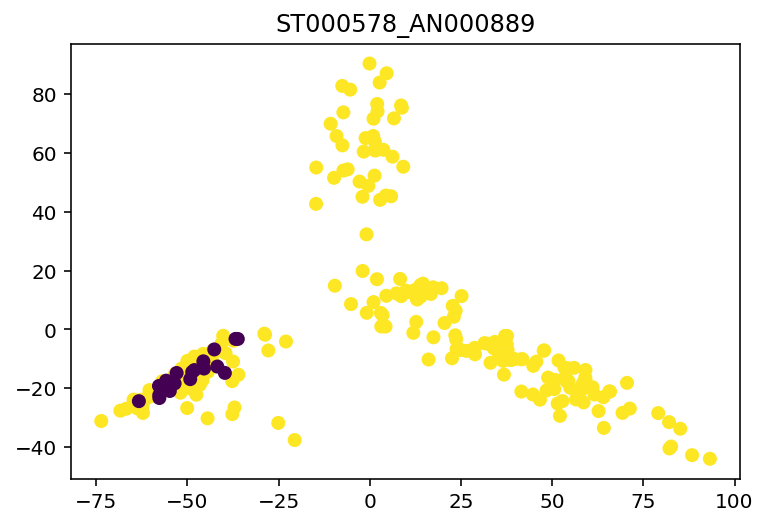

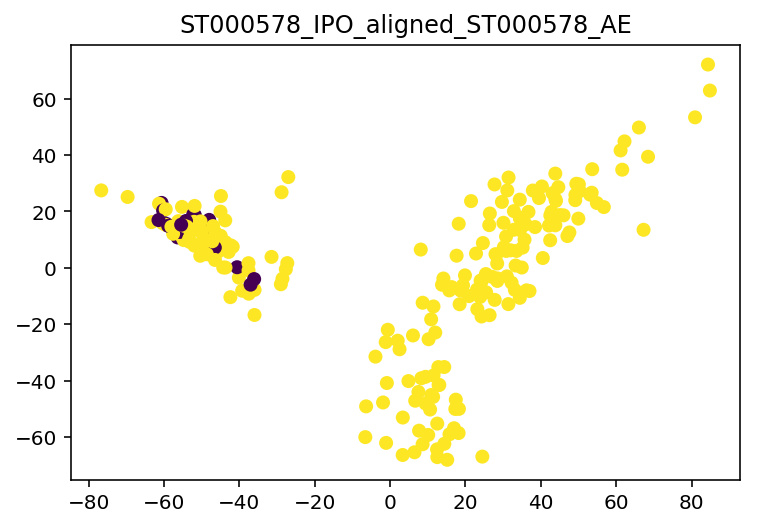

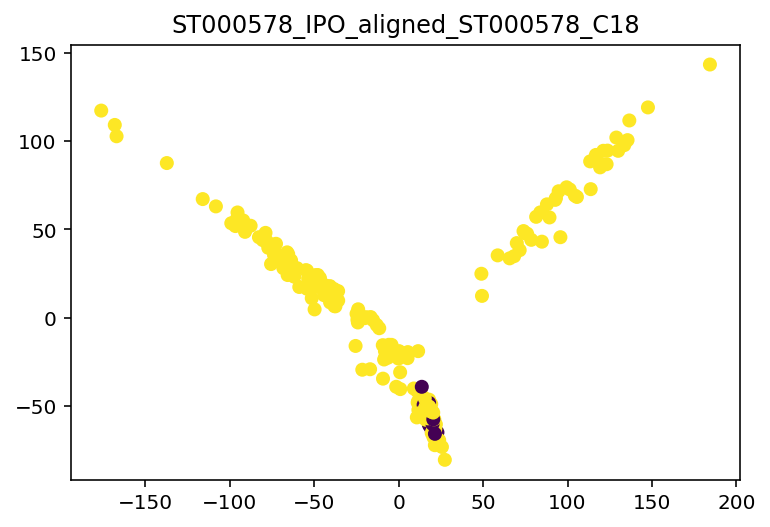

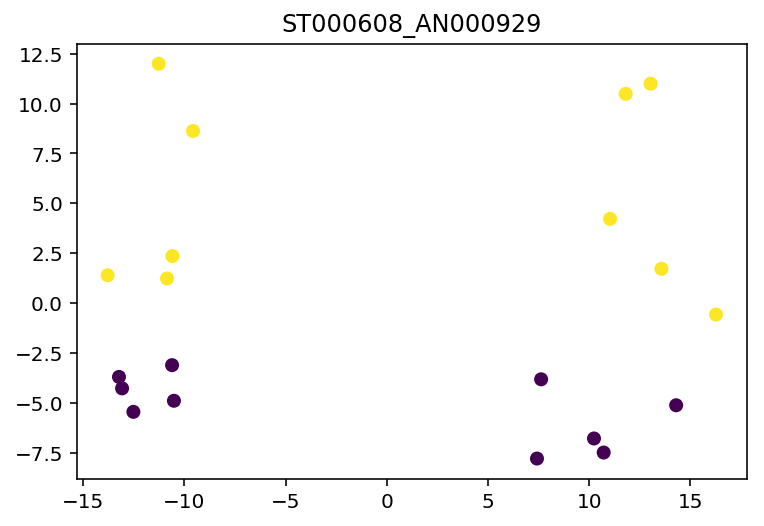

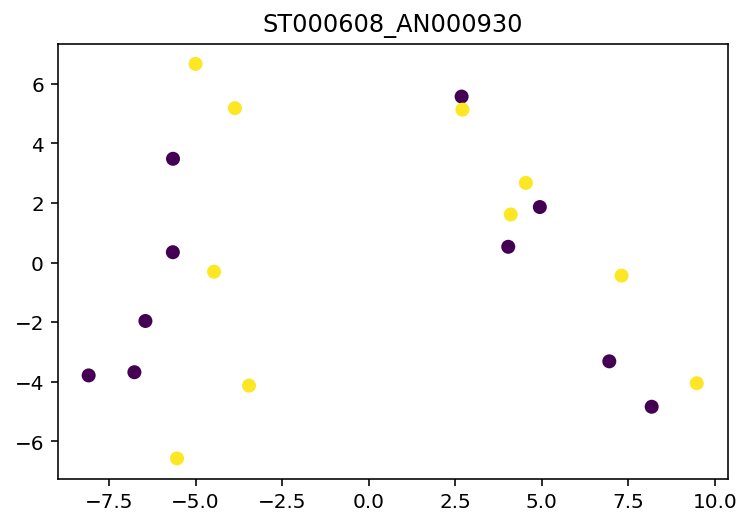

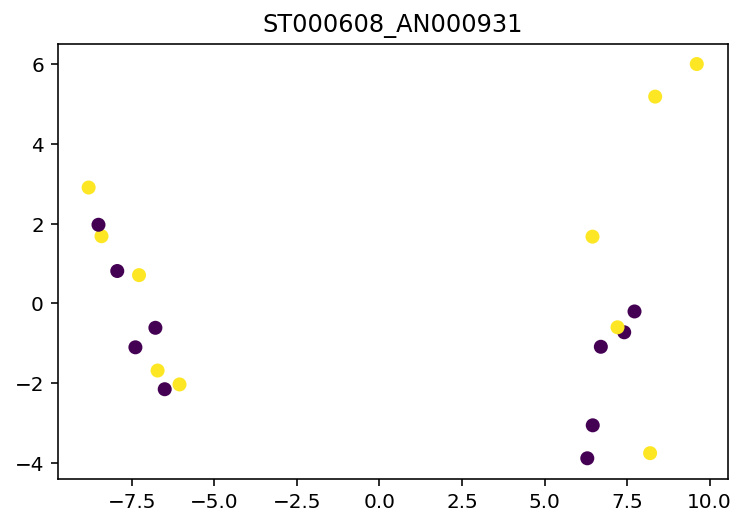

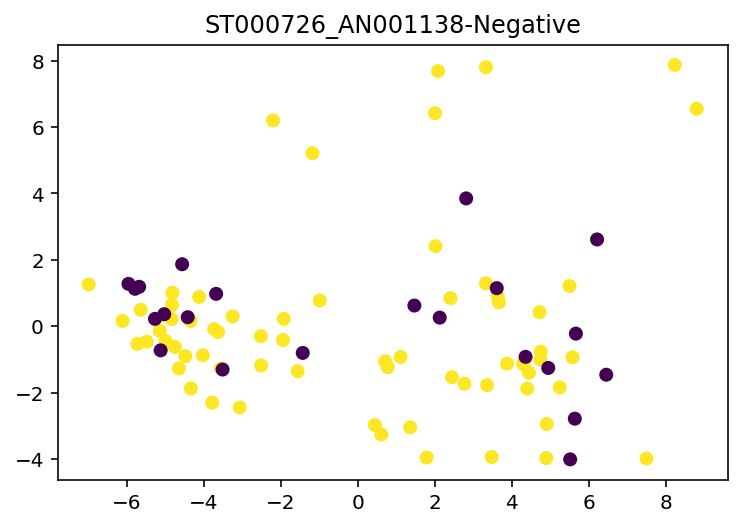

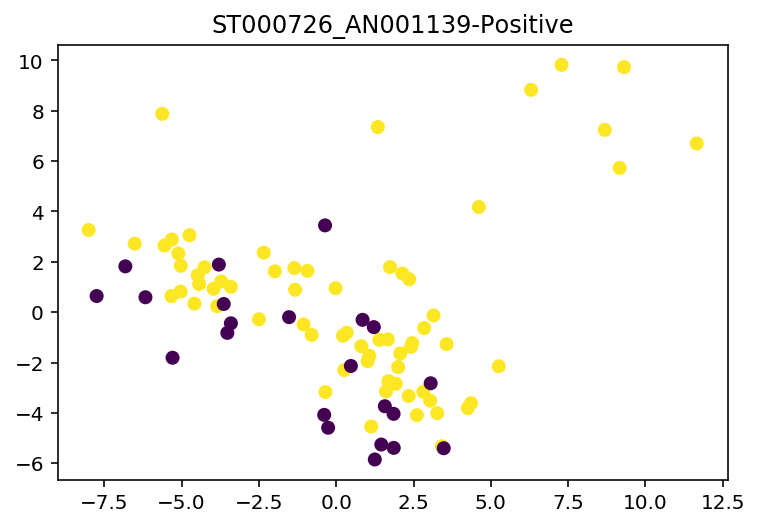

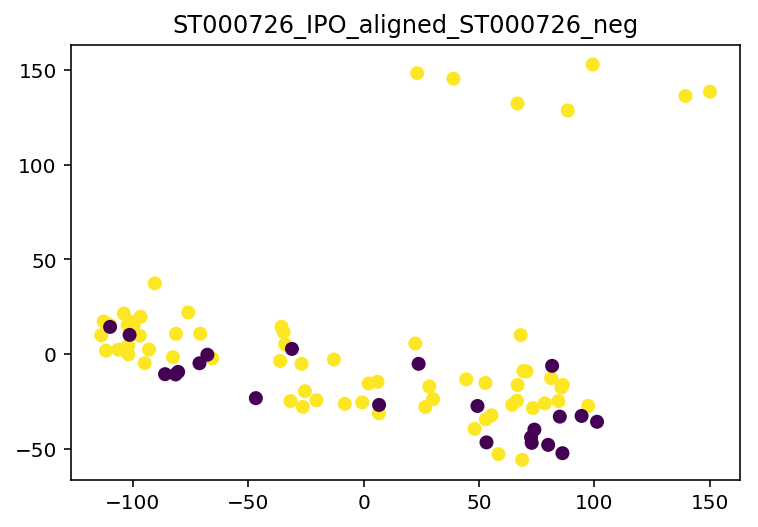

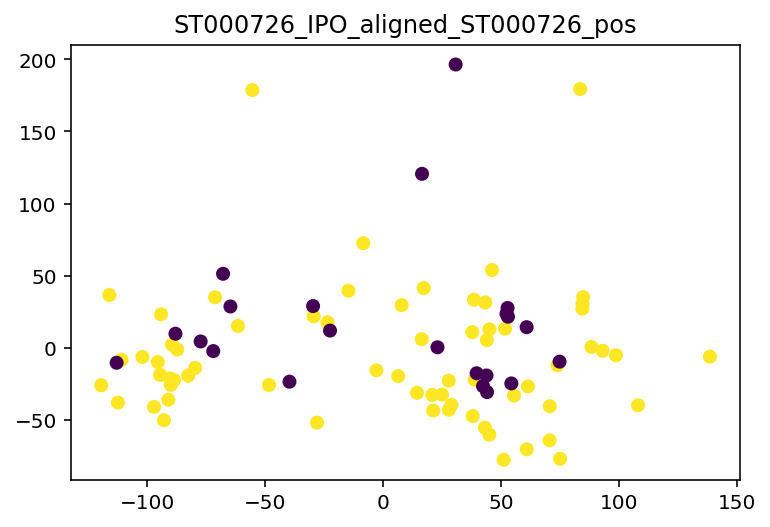

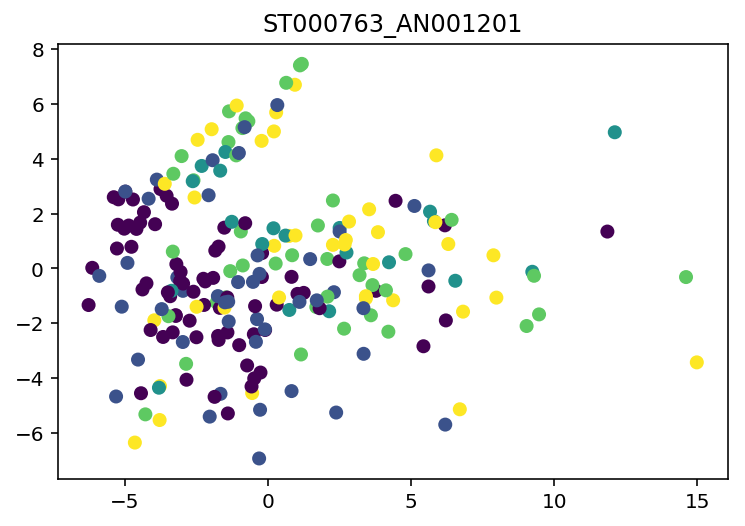

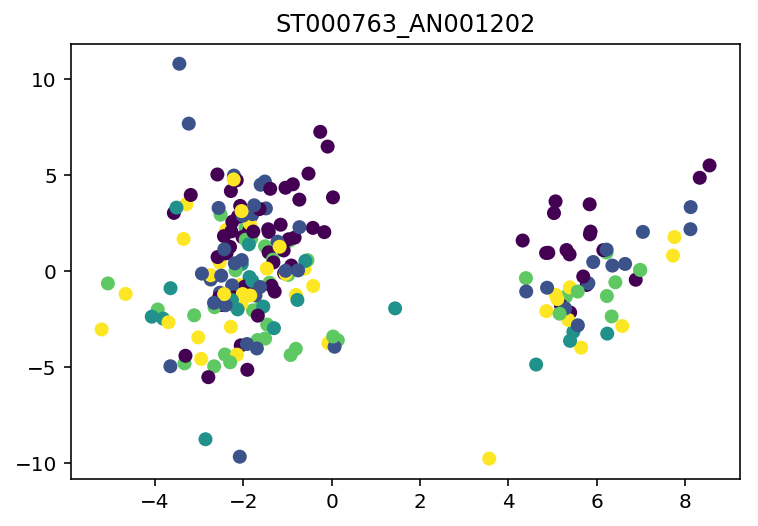

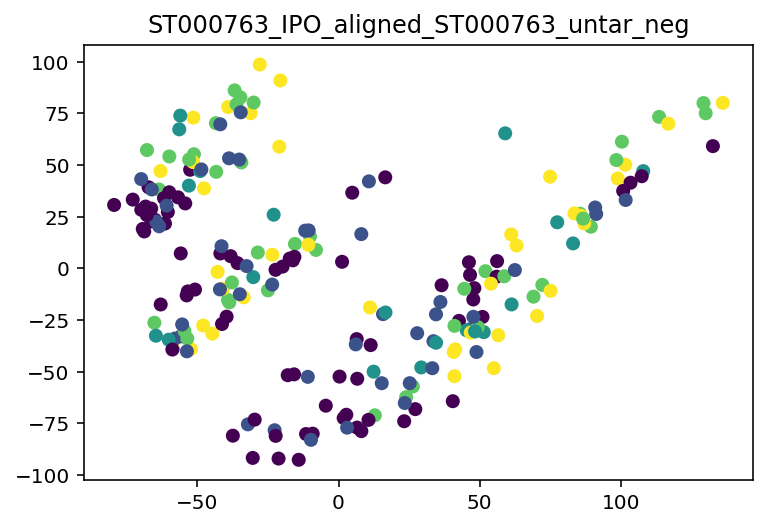

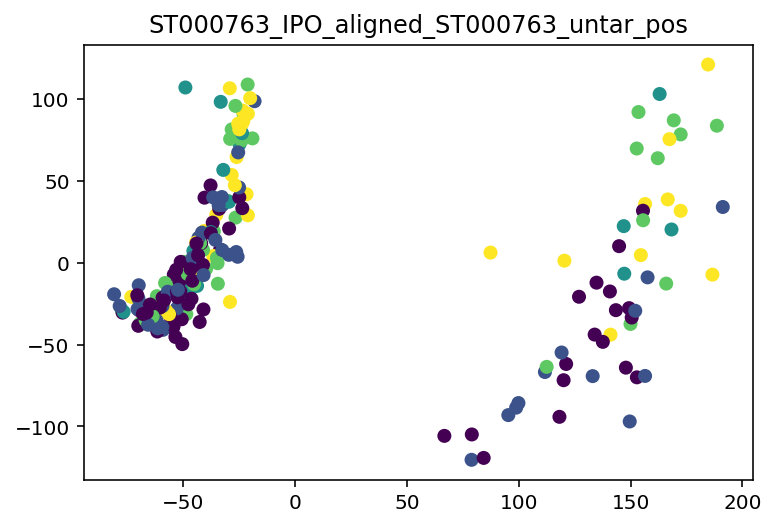

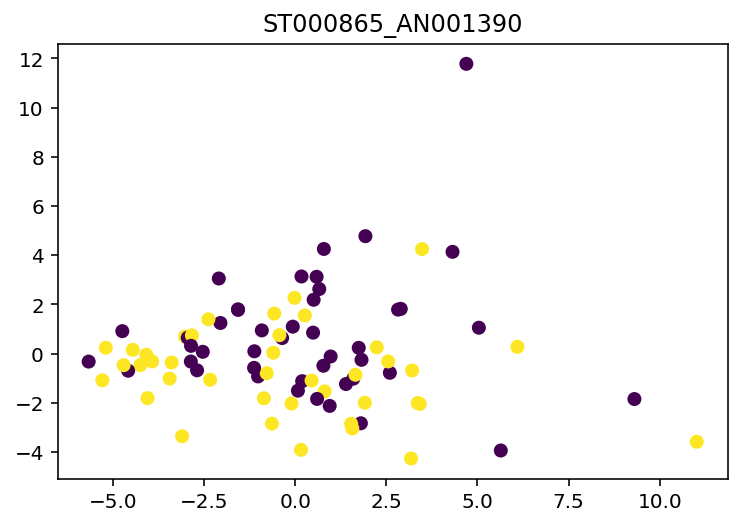

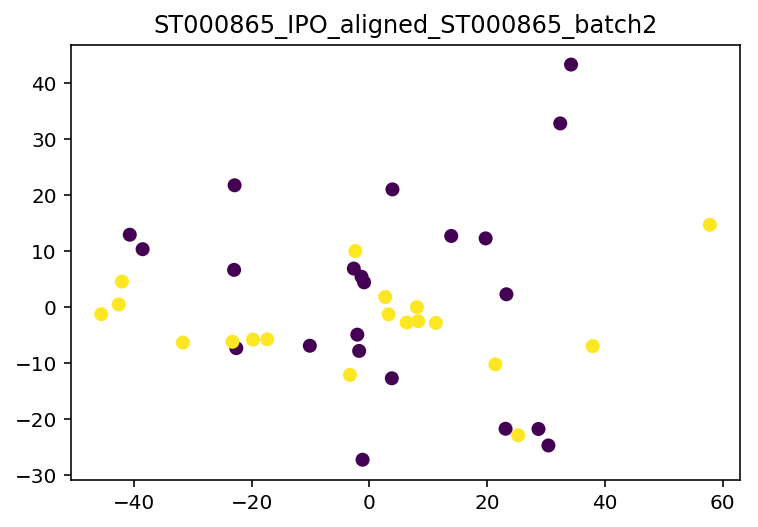

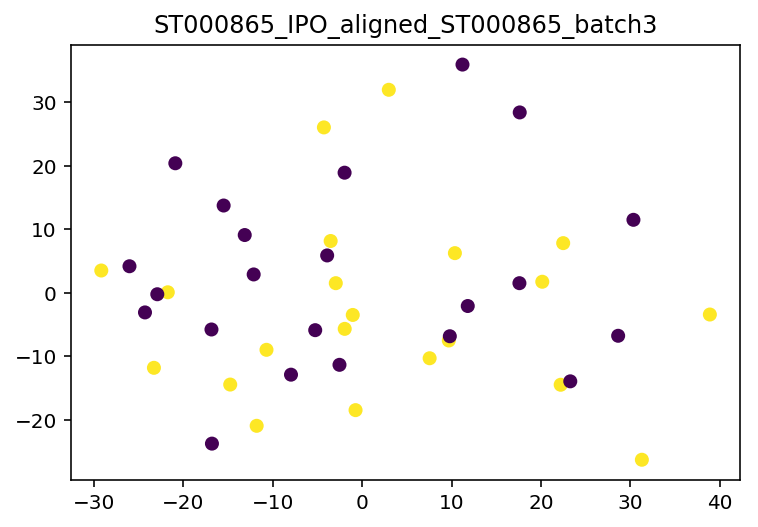

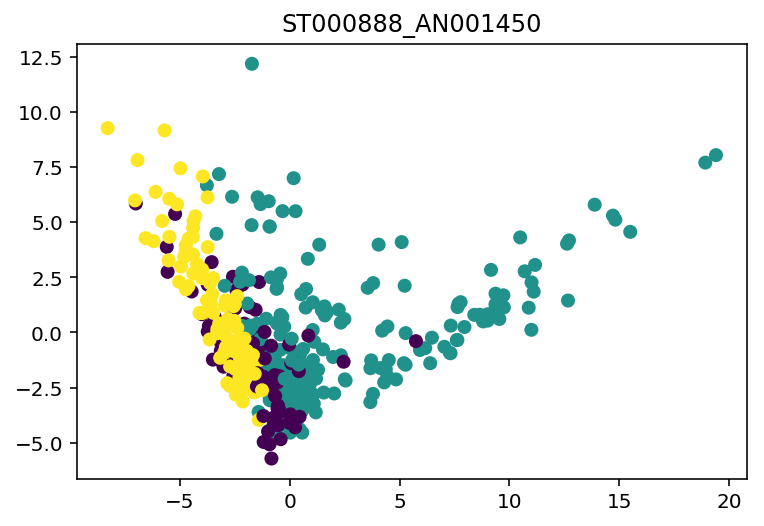

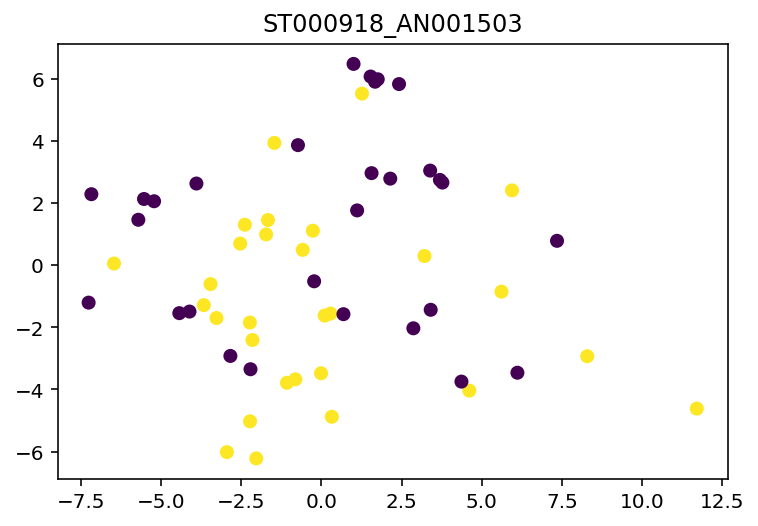

snyder IPO_aligned_snyderome_b1_neg cannot do PCA since no labels
snyder IPO_aligned_snyderome_b1_neg (<class 'AttributeError'>, AttributeError("'str' object has no attribute 'values'",), <traceback object at 0x7f8c344b8488>)
snyder IPO_aligned_snyderome_b2_neg cannot do PCA since no labels
snyder IPO_aligned_snyderome_b2_neg (<class 'AttributeError'>, AttributeError("'str' object has no attribute 'values'",), <traceback object at 0x7f8c2b2f5fc8>)


In [43]:
#### NOTE: this is old code, I have changed the code significant since it was written and have not looked to see if it actually works anymore...
#### caveat emptor lol
# use this to look at PCA of all datasets - ie a rough way of look at batch effects (but only OBVIOUS ones) so not terribly useful
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
for k, v in datasets.items():  
    for ds in v:
        try:
            ds['labels'] = ds['labels']*1
            vals = ds['labels'].values    
        except:
            print(k, ds['data_set'], 'cannot do PCA since no labels')
        X = ds['features'].values.copy()
        X = convert_nan_to_val(X, value=0)
        X[np.isinf(X)] = 0
        value = min(X.shape[1], 50)
        pca = PCA(n_components=value)
        ss = StandardScaler()
        try:
            X = ss.fit_transform(X)
            X_pca = pca.fit_transform(X)
            y = ds['labels'].values.ravel()
            plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
            plt.title(ds['study'] +'_'+ ds['data_set'])
            plt.show()
            #looking at one speific example for batch effects, mapping the batch label to the data in the PCA plot 
            if 'IPO' in ds['data_set'] and ds['study'] == 'MTBLS404':
                files = list(ds['labels'].index)
                filt_samp_extract = ds['samples']['Extract Name'].loc[files]
#                 print(list(filt_samp_extract))
                mask = {f:1 for f in list(filt_samp_extract) if 'b2' in f}
                filt_samp_extract = filt_samp_extract.replace(mask)
                filt_samp_extract[filt_samp_extract!=1] = 0
                plt.scatter(X_pca[:,0], X_pca[:,1], c=filt_samp_extract)
                plt.title(ds['study'] +'_'+ ds['data_set']+'_BATCH_MAP')
                plt.show()
        except: 
            print(ds['study'], ds['data_set'], sys.exc_info())
